## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib qt
def camera_cali():
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Make a list of calibration images
    images = glob.glob('../camera_cal/calibration*.jpg')

    # Step through the list and search for chessboard corners
    for fname in images:
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

            # Draw and display the corners
            img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
            #cv2.imshow('img',img) # this will a window showing the images with corners drawed
            #cv2.waitKey(100)

    #cv2.destroyAllWindows()
    return objpoints, imgpoints

objpoints, imgpoints = camera_cali()

## Apply the camera calibration given objpoints and image points

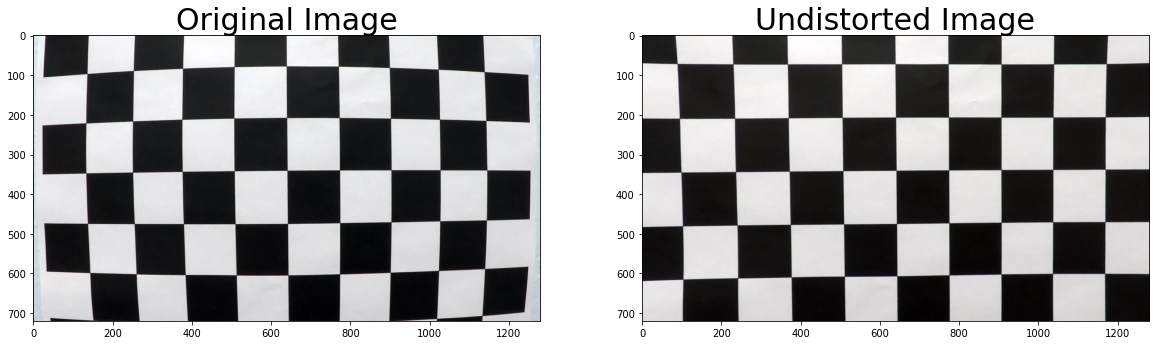

In [2]:
import pickle
%matplotlib inline

# Test undistortion on an image
img = cv2.imread('../camera_cal/calibration1.jpg')

def undistort(img,objpoints, imgpoints):
    img_size = (img.shape[1], img.shape[0])

    # Do camera calibration given object points and image points
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)


    dst = cv2.undistort(img, mtx, dist, None, mtx)
    cv2.imwrite('../output_images/camera_cal_out.jpg',dst)

    # Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
    dist_pickle = {}
    dist_pickle["mtx"] = mtx
    dist_pickle["dist"] = dist
    pickle.dump( dist_pickle, open( "../output_images/wide_dist_pickle.p", "wb" ) )
    return img,dst

img,dst = undistort(img,objpoints, imgpoints)
dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
# Visualize undistortion


f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)
plt.savefig('image1.jpg')


In [3]:
## Use color transforms, gradients, etc., to create a thresholded binary image.

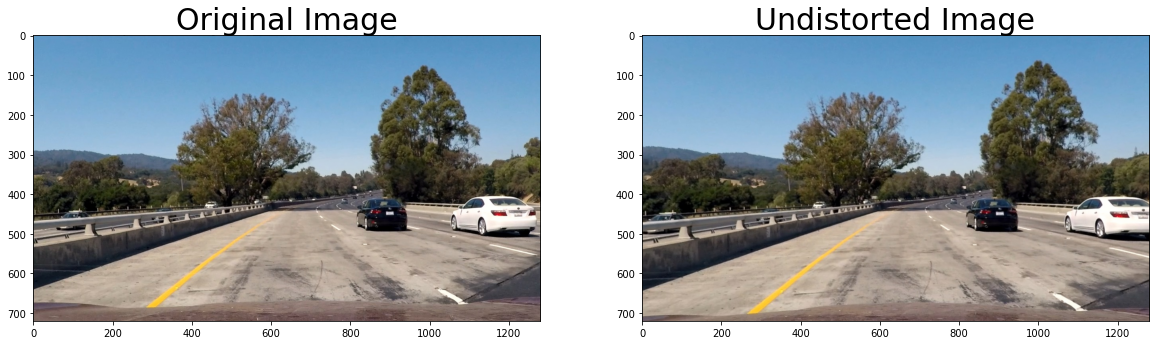

In [4]:


img = cv2.imread('../test_images/test1.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)


dst = cv2.undistort(img, mtx, dist, None, mtx)
cv2.imwrite('../output_images/test1_out.jpg',dst)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
#pickle.dump( dist_pickle, open( "../output_images/test1_wide_dist_pickle.p", "wb" ) )
#dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)
plt.savefig('image2.jpg')


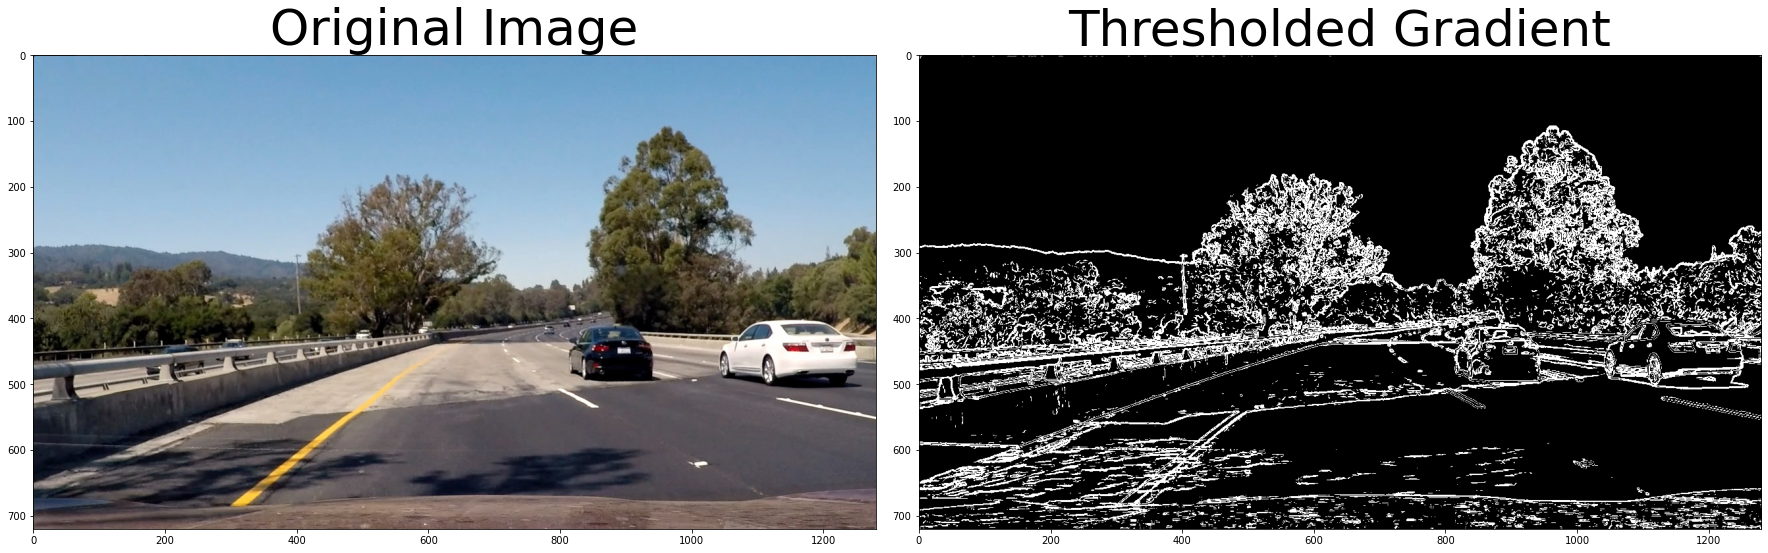

In [5]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle



# Define a function that takes an image, gradient orientation,
# and threshold min / max values.
def abs_sobel_thresh(img, orient='x',sobel_kernel=3, thresh=(0,255)):
    # Convert to grayscale
    thresh_min = thresh[0]
    thresh_max = thresh[1]
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Return the result
    return binary_output


# Define a function to return the magnitude of the gradient
# for a given sobel kernel size and threshold values
def mag_thresh(img, sobel_kernel=3, thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= thresh[0]) & (gradmag <= thresh[1])] = 1

    # Return the binary image
    return binary_output


# Define a function to threshold an image for a given range and Sobel kernel
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

# Read in an image and grayscale it
image = mpimg.imread('../test_images/test4.jpg')
ksize = 3
# Run the function
grad_binary = mag_thresh(image, sobel_kernel=ksize, thresh=(20,100))
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(grad_binary, cmap='gray')
ax2.set_title('Thresholded Gradient', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.savefig('image3.jpg')



In [6]:
# Choose a Sobel kernel size

def thresh_image(image,ksize=3,threshx=(0,255),threshy=(0,255),thresh_mag=(50, 200)):
    ksize = 3 # Choose a larger odd number to smooth gradient measurements

    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=ksize, thresh=threshx)
    grady = abs_sobel_thresh(image, orient='y', sobel_kernel=ksize, thresh=threshy)
    mag_binary = mag_thresh(image, sobel_kernel=ksize, thresh=thresh_mag)
    dir_binary = dir_threshold(image, sobel_kernel=ksize, thresh=(0, np.pi/2))

    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    
    return image,mag_binary


"""
image,mag_binary = thresh_image(img,ksize=3,threshx=(0,255),threshy=(0,255),thresh_mag=(50, 200))
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(mag_binary, cmap='gray')
ax2.set_title('Thresholded Gradient', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
"""


"\nimage,mag_binary = thresh_image(img,ksize=3,threshx=(0,255),threshy=(0,255),thresh_mag=(50, 200))\nf, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))\nf.tight_layout()\nax1.imshow(image)\nax1.set_title('Original Image', fontsize=50)\nax2.imshow(mag_binary, cmap='gray')\nax2.set_title('Thresholded Gradient', fontsize=50)\nplt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)\n"

In [7]:
## Perspective Transformation


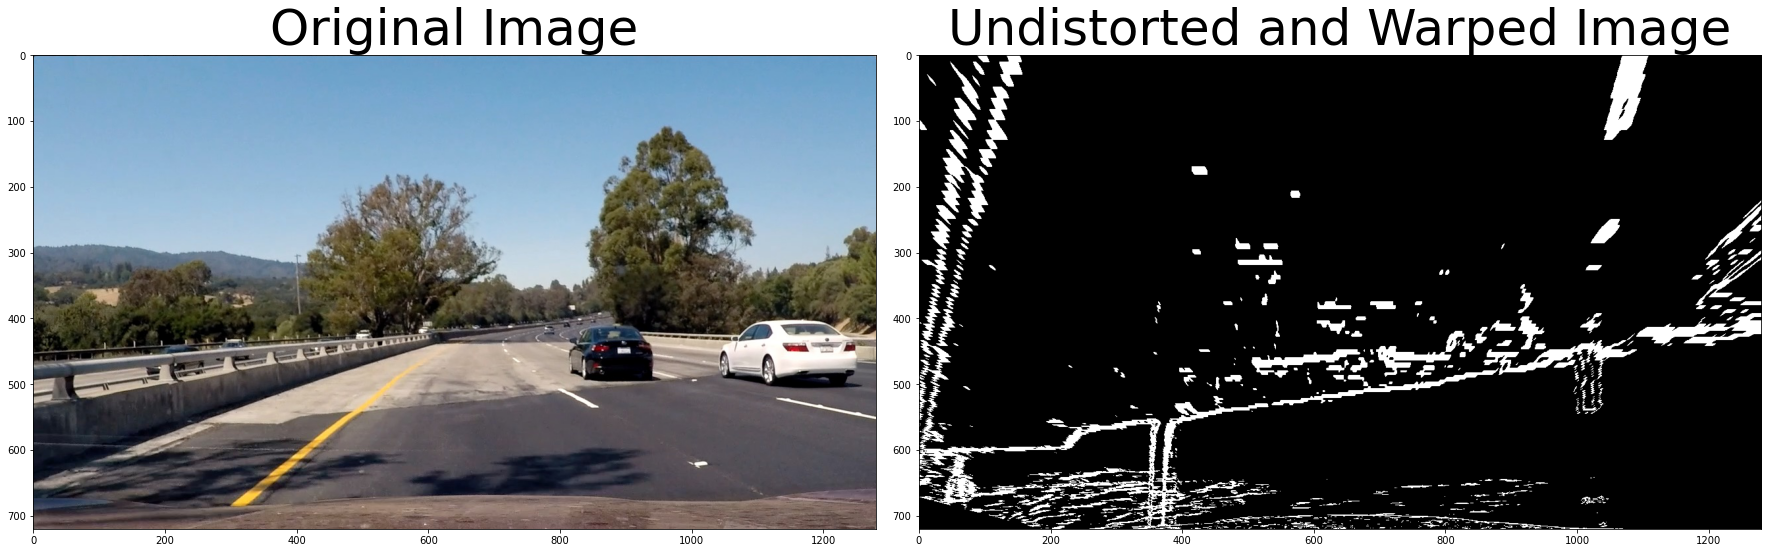

In [8]:
import pickle
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Define a function that takes an image, number of x and y points, 
# camera matrix and distortion coefficients
def corners_unwarp(img, mtx, dist):
    # Use the OpenCV undistort() function to remove distortion
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    # Convert undistorted image to grayscale
    # gray = cv2.cvtColor(undist, cv2.COLOR_BGR2GRAY)
    gray = img
    # Search for corners in the grayscaled image
    #ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    
    ret = 1

    if ret == True:
        
        # If we found corners, draw them! (just for fun)
        # cv2.drawChessboardCorners(undist, (nx, ny), corners, ret)
        # Choose offset from image corners to plot detected corners
        # This should be chosen to present the result at the proper aspect ratio
        # My choice of 100 pixels is not exact, but close enough for our purpose here
        offset = 100 # offset for dst points
        # Grab the image shape
        img_size = (gray.shape[1], gray.shape[0])

        """
        # For source points I'm grabbing the outer four detected corners
        src = np.float32([corners[0], corners[nx-1], corners[-1], corners[-nx]])
        # For destination points, I'm arbitrarily choosing some points to be
        # a nice fit for displaying our warped result 
        # again, not exact, but close enough for our purposes
        dst = np.float32([[offset, offset], [img_size[0]-offset, offset], 
                                     [img_size[0]-offset, img_size[1]-offset], 
                                     [offset, img_size[1]-offset]])
                                     
        """
        
        src = np.float32(
            [[(img_size[0] / 2) - 63, img_size[1] / 2 + 100],
            [((img_size[0] / 6) - 20), img_size[1]],
            [(img_size[0] * 5 / 6) + 60, img_size[1]],
            [(img_size[0] / 2 + 65), img_size[1] / 2 + 100]])
        dst = np.float32(
            [[(img_size[0] / 4), 0],
            [(img_size[0] / 4), img_size[1]],
            [(img_size[0] * 3 / 4), img_size[1]],
            [(img_size[0] * 3 / 4), 0]])
        
        #print("src=\n",src)
        
        #print("dst=\n",dst)
        
      
        
        """
        src = np.float32(
            [[(img_size[0] / 2) - 55, img_size[1] / 2 + 100],
            [((img_size[0] / 6) - 10), img_size[1]],
            [(img_size[0] * 5 / 6) + 60, img_size[1]],
            [(img_size[0] / 2 + 55), img_size[1] / 2 + 100]])
        dst = np.float32(
            [[(img_size[0] / 4), 0],
            [(img_size[0] / 4), img_size[1]],
            [(img_size[0] * 3 / 4), img_size[1]],
            [(img_size[0] * 3 / 4), 0]])
            
        """
        

        
        
        # Given src and dst points, calculate the perspective transform matrix
        M = cv2.getPerspectiveTransform(src, dst)
        Minv = cv2.getPerspectiveTransform(dst, src)
        # print("M is",M)
        # Warp the image using OpenCV warpPerspective()
        
        warped = cv2.warpPerspective(undist, M, img_size)

    # Return the resulting image and matrix
    return warped, M, Minv




# Read in the saved camera matrix and distortion coefficients
# These are the arrays you calculated using cv2.calibrateCamera()
dist_pickle = pickle.load(open( "./wide_dist_pickle.p", "rb"))
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]
#print("mtx,dist",mtx,dist)

# Read in an image
# img = cv2.imread('../test_images/test_image2.png')
# img = cv2.imread('../test_images/straight_lines1.jpg')


top_down, perspective_M, Minv = corners_unwarp(grad_binary, mtx, dist)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
#img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(top_down,cmap='gray')
ax2.set_title('Undistorted and Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.savefig('image4.jpg')

In [9]:


## locate the lane lines

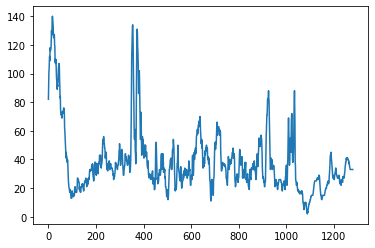

In [10]:
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

# Load our image
# `mpimg.imread` will load .jpg as 0-255, so normalize back to 0-1
# img = mpimg.imread('warped_example.jpg')/255

def hist(img):
    # TO-DO: Grab only the bottom half of the image
    # Lane lines are likely to be mostly vertical nearest to the car
    bottom_half = None
    bottom_half = img[img.shape[0]//2:,:]

    # TO-DO: Sum across image pixels vertically - make sure to set `axis`
    # i.e. the highest areas of vertical lines should be larger values
    histogram = None
    histogram = np.sum(bottom_half, axis=0)
    
    return histogram

# Create histogram of image binary activations
histogram = hist(top_down)

# Visualize the resulting histogram
plt.plot(histogram)

In [11]:
class Line():
    def __init__(self):
        self.recent_fit=[] # list of list of x coordinates
        
    def get_recent_fit(self):
        print(len(self.recent_fit))
        sum_list =  [0 for i in self.recent_fit[0]]
        for line in range(len(self.recent_fit)):
            for col in range(len(self.recent_fit[line])):
                sum_list[col] += self.recent_fit[line][col]
        for i in range(len(sum_list)):
            sum_list[i] = sum_list[i]//len(self.recent_fit)
        return sum_list
    
    def add_recent_fit(self,fit_list):
        self.recent_fit.append(fit_list)
        if len(self.recent_fit) > 15:
            self.recent_fit.pop(0)
            

leftline = Line()
rightline = Line()

"""left.add_recent_fit([1,2,3])
left.add_recent_fit([3,2,1])
left.add_recent_fit([6,6,6])
left.get_recent_fit()"""
            
            
        
        

'left.add_recent_fit([1,2,3])\nleft.add_recent_fit([3,2,1])\nleft.add_recent_fit([6,6,6])\nleft.get_recent_fit()'

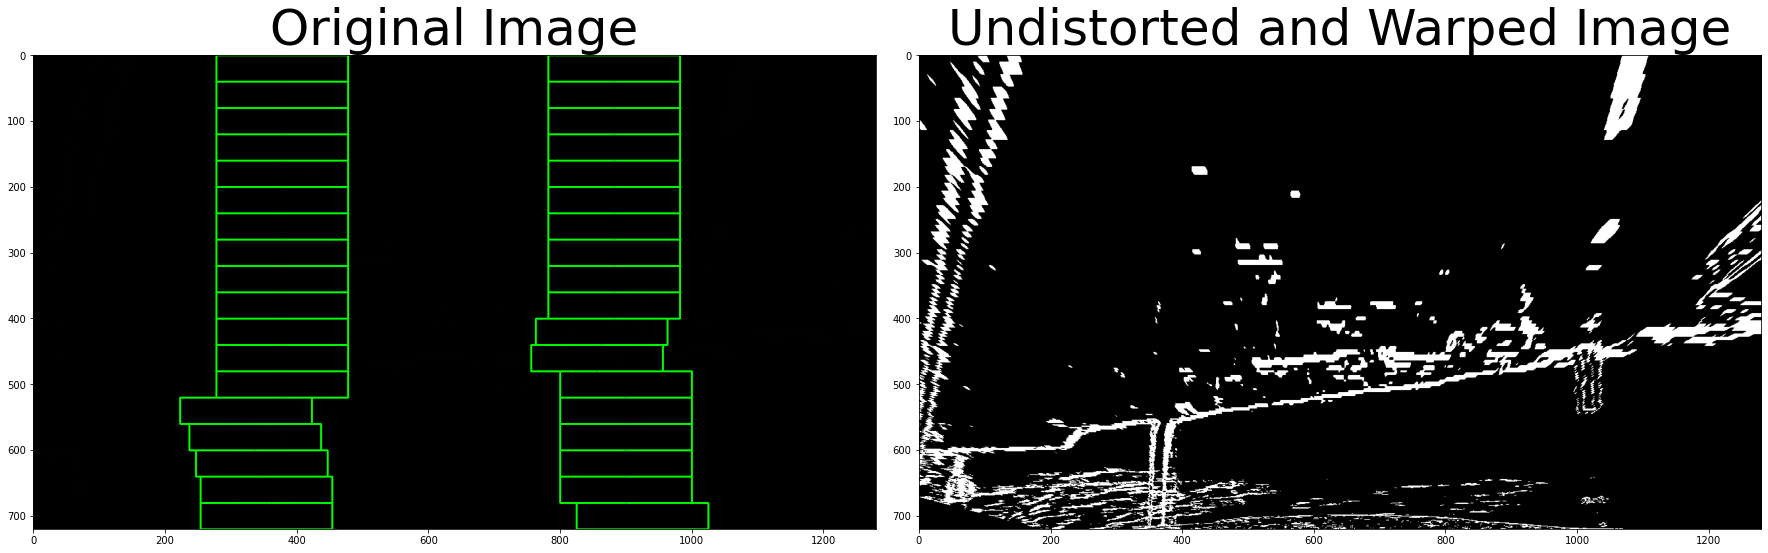

In [12]:

import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import cv2

# Load our image
# binary_warped = mpimg.imread('warped_example.jpg')
# binary_warped = top_down
def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # plt.imshow(out_img)
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = int(histogram.shape[0]//2)
    fourthpoint = midpoint//2
    # print("histogram[fourthpoint:midpoint] is\n",histogram[fourthpoint:midpoint])
    leftx_base = np.argmax(histogram[fourthpoint:midpoint]) + fourthpoint
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    #print("leftx_base is\n",leftx_base)
    #print("rightx_base is\n",rightx_base)

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 18
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 500

    # Set height of windows - based on nwindows above and image shape
    window_height = int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    # print("nonezero is\n",nonzero)
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    leftx,lefty,rightx,righty = [],[],[],[]

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        # left_lane_inds.append(good_left_inds)
        # right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        
        # print("len(good_left_inds) > minpix",len(good_left_inds),minpix)
        if len(good_left_inds) > minpix:
            leftx_current = int(np.mean(nonzerox[good_left_inds]))
            left_lane_inds.append(good_left_inds)
            
            #print("left found")
        else:
            pass
            #print("left not found",left_lane_inds[-1])
            #left_lane_inds.append(left_lane_inds[-1])
        leftx.append(leftx_current)
        lefty.append(win_y_low)
        
            
            
        # print("len(good_right_inds) > minpix",len(good_right_inds),minpix)
        if len(good_right_inds) > minpix:        
            rightx_current = int(np.mean(nonzerox[good_right_inds]))
            right_lane_inds.append(good_right_inds)
            # print("right found")
        else:
            pass
            # print("right not found",right_lane_inds[-1])
            # right_lane_inds.append(right_lane_inds[-1])
            
        rightx.append(rightx_current)
        righty.append(win_y_low)

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    
    """    
    leftx  = nonzerox[left_lane_inds]
    lefty  = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    """

    return leftx, lefty, rightx, righty, out_img


def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)
    # plt.imshow(out_img)
    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    # plt.plot(left_fitx, ploty, color='yellow')
    # plt.plot(right_fitx, ploty, color='yellow')
    
    # left_fit, right_fit is the coefficient
    # left_fitx, right_fitx the ploted points from coefficient.
    

    return out_img,ploty,left_fitx, right_fitx,left_fit, right_fit


out_img,ploty,left_fitx, right_fitx,left_fit, right_fit = fit_polynomial(top_down)

# plt.imshow(top_down)
# plt.imshow(out_img)
# plt.savefig('image5.jpg')


f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(out_img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(top_down,cmap='gray')
ax2.set_title('Undistorted and Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
#plt.savefig('image4.jpg')




#img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

In [13]:
# calculate the curvature


In [14]:
def measure_curvature_pixels(ploty,left_fit, right_fit, ym_per_pix=30/720, xm_per_pix=3.7/700):
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    
   

    y_eval = np.max(ploty)*ym_per_pix
    print("y_eval is",y_eval)
    #print("left_fit\n",left_fit)
    #print("right_fit\n",right_fit)
    # print("the car position respect to center of the two line is",(left_fit[0]+right_fit[1])/2 - binary_warped.shape[1]/2)
    left_a_new = xm_per_pix/(ym_per_pix**2)*left_fit[0]
    left_b_new = xm_per_pix/(ym_per_pix)*left_fit[1]
    right_a_new = xm_per_pix/(ym_per_pix**2)*right_fit[0]
    right_b_new = xm_per_pix/(ym_per_pix)*right_fit[1]
    # Calculation of R_curve (radius of curvature)
    left_curverad = ((1 + (2*left_a_new*y_eval + left_b_new)**2)**1.5) / np.absolute(2*left_a_new)
    right_curverad = ((1 + (2*right_a_new*y_eval + right_b_new)**2)**1.5) / np.absolute(2*right_a_new)
    
    return left_curverad, right_curverad
    
def measure_offset(img,left_fitx, right_fitx):
    ym_per_pix=30/720
    xm_per_pix=3.7/700
    print(right_fitx[-1],left_fitx[-1],img.shape[1]/2)
    if (len(right_fitx)>0 and len(left_fitx)>0):
        pix_off = (np.mean(right_fitx) - np.mean(left_fitx))/2 - img.shape[1]/2
        dis_off = pix_off *  xm_per_pix
    else:
        dis_off = 0
        
    return dis_off
    
    

In [15]:
# Define conversions in x and y from pixels space to meters
#ym_per_pix = 30/720 # meters per pixel in y dimension
#xm_per_pix = 3.7/700 # meters per pixel in x dimension
#left_curverad, right_curverad = measure_curvature_pixels(ploty,left_fitx, right_fitx, ym_per_pix=ym_per_pix, xm_per_pix=xm_per_pix)

#print(left_curverad, right_curverad)

In [16]:
def add_curve_on_pic(image, left_curverad, right_curverad, offset, color=(255,0,0)):
    direction = "right" if offset < 0 else "left"
    str_left_curve = "left curverad = {}(m)".format(int(left_curverad))
    str_right_curve = "right curverad = {}(m)".format(int(right_curverad))
    
    str_offset = "Car is {0:.2f}m ".format(abs(offset)) + "{} away off center".format(direction)
    cv2.putText(image, str_left_curve, (50,60), cv2.FONT_HERSHEY_SIMPLEX,2,color,2)
    cv2.putText(image, str_right_curve, (50,120), cv2.FONT_HERSHEY_SIMPLEX,2,color,2)
    cv2.putText(image, str_offset, (50,180), cv2.FONT_HERSHEY_SIMPLEX,2,color,2)
    
    
    

In [17]:


# transform back to real world curvature

In [18]:
## plot area between the lane back to the image

In [19]:
def draw_lane_fit(undist, warped ,Minv, left_fitx, right_fitx, ploty):
    # Drawing
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255,0))
    

    # Warp the blank back to original image space using inverse perspective matrix(Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (undist.shape[1], undist.shape[0]))
    print("shape of newwarp",newwarp[-1,:,1].shape)
    nonzero_list = newwarp[-1,:,1].nonzero()[0]
    print("the nonzero x range is",nonzero_list[0],nonzero_list[-1])
    #plt.imshow(newwarp)
    # Combine the result with the original image
    #print("newwarp",newwarp.shape[0],newwarp.shape[1],newwarp.shape[2])
    #print("undist",undist.shape[0],undist.shape[1],newwarp.shape[2])
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)

    return result,nonzero_list

#exampleImg_out1 = project_fit_lane_info(img, binary_warped, left_fitx, right_fitx, Minv)
#plt.imshow(exampleImg_out1)
#left_fitx, right_fitx
# print("Minv=\n",Minv)



#result = draw_lane_fit(img,top_down,Minv,left_fitx, right_fitx, ploty)
#plt.imshow(result)
#plt.savefig('image6.jpg')

In [20]:
def pipeline(img):
    objpoints, imgpoints = camera_cali() # calibrate the camera 
       
    img,dst = undistort(img,objpoints, imgpoints) # apply the calibration on img
        
    img,mag_binary = thresh_image(img,ksize=3,threshx=(0,255),threshy=(0,255),thresh_mag=(50, 200))
    # img is the original image, mag_binary is the magnitude of x_derivative and y_derivative
    
    # Read in the saved camera matrix and distortion coefficients
    # These are the arrays you calculated using cv2.calibrateCamera()
    dist_pickle = pickle.load(open("./wide_dist_pickle.p", "rb"))
    mtx = dist_pickle["mtx"]
    dist = dist_pickle["dist"]
    top_down, perspective_M, Minv = corners_unwarp(mag_binary, mtx, dist)

    out_img,ploty,left_fitx, right_fitx ,left_fit, right_fit = fit_polynomial(top_down)
    
    left_curverad, right_curverad = measure_curvature_pixels(ploty,left_fit, right_fit)
    
    print("left_curverad, right_curverad",left_curverad, right_curverad)
    
    leftline.add_recent_fit(left_fitx)
    rightline.add_recent_fit(right_fitx)
    
    left_fitx = leftline.get_recent_fit()
    right_fitx = rightline.get_recent_fit()
    
    #offset = measure_offset(img,left_fitx, right_fitx)
    #print("offset is",offset)
    
    
    result, nonzero_list = draw_lane_fit(img,top_down,Minv,left_fitx, right_fitx, ploty)
    
    offset = -((nonzero_list[-1] - nonzero_list[0]) - img.shape[1])*(3.7/700)/2
    
    add_curve_on_pic(result, left_curverad, right_curverad, offset, color=(0,255,255))
    
    plt.imshow(result)
    
    #plt.savefig('image_pitfall.jpg')
    
    return result

img.shape[0] 720
y_eval is 29.958333333333332
left_curverad, right_curverad 348.7193798163953 1195.0862971661697
1
1
shape of newwarp (1280,)
the nonzero x range is 256 1178


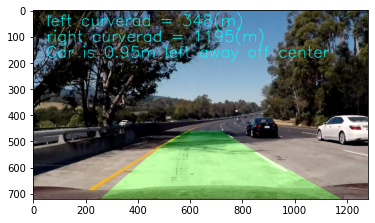

In [21]:
#img = cv2.imread('../camera_cal/calibration1.jpg')
img = mpimg.imread('../test_images/test5.jpg')
print("img.shape[0]",img.shape[0])

result = pipeline(img)
#plt.imshow(result)
#plt.savefig('image_pitfall.jpg')

In [22]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML


In [23]:
def process_image(image):
    return pipeline(image)

t:   0%|          | 0/1260 [00:00<?, ?it/s, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 800.2316298047524 520.7466472428664
2
2
shape of newwarp (1280,)
the nonzero x range is 267 1178
Moviepy - Building video ../project_video_out.mp4.
Moviepy - Writing video ../project_video_out.mp4



t:   0%|          | 2/1260 [00:02<23:14,  1.11s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 800.2316298047524 520.7466472428664
3
3
shape of newwarp (1280,)
the nonzero x range is 269 1178


t:   0%|          | 3/1260 [00:04<33:09,  1.58s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 497.74004281041573 469.7323233619801
4
4
shape of newwarp (1280,)
the nonzero x range is 264 1178


t:   0%|          | 4/1260 [00:06<38:04,  1.82s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 544.8828572675206 357.20223997630336
5
5
shape of newwarp (1280,)
the nonzero x range is 262 1178


t:   0%|          | 5/1260 [00:08<41:24,  1.98s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 547.058275266358 610.1556736451641
6
6
shape of newwarp (1280,)
the nonzero x range is 261 1181


t:   0%|          | 6/1260 [00:11<43:01,  2.06s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 790.2807295653276 487.2362977711014
7
7
shape of newwarp (1280,)
the nonzero x range is 265 1183


t:   1%|          | 7/1260 [00:13<44:00,  2.11s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 745.318818707338 436.6273640877245
8
8
shape of newwarp (1280,)
the nonzero x range is 268 1184


t:   1%|          | 8/1260 [00:15<44:34,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 823.0048782859626 541.0473141618417
9
9
shape of newwarp (1280,)
the nonzero x range is 271 1184


t:   1%|          | 9/1260 [00:17<44:57,  2.16s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 837.7290042813416 526.8246461155029
10
10
shape of newwarp (1280,)
the nonzero x range is 274 1181


t:   1%|          | 10/1260 [00:20<45:19,  2.18s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 554.225262068939 478.5807158407305
11
11
shape of newwarp (1280,)
the nonzero x range is 272 1178


t:   1%|          | 11/1260 [00:22<45:33,  2.19s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 560.7718907158795 546.1373223343155
12
12
shape of newwarp (1280,)
the nonzero x range is 272 1175


t:   1%|          | 12/1260 [00:24<46:00,  2.21s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 581.2271063774593 361.0412333020843
13
13
shape of newwarp (1280,)
the nonzero x range is 271 1172


t:   1%|          | 13/1260 [00:27<48:06,  2.31s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 587.498835202992 740.7265503573223
14
14
shape of newwarp (1280,)
the nonzero x range is 271 1172


t:   1%|          | 14/1260 [00:29<47:38,  2.29s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 613.6695603180698 437.5250250656064
15
15
shape of newwarp (1280,)
the nonzero x range is 269 1172


t:   1%|          | 15/1260 [00:31<47:15,  2.28s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 614.0401016742711 558.3401842194991
15
15
shape of newwarp (1280,)
the nonzero x range is 271 1172


t:   1%|▏         | 16/1260 [00:33<46:51,  2.26s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 644.4338942866169 437.4089917619899
15
15
shape of newwarp (1280,)
the nonzero x range is 269 1172


t:   1%|▏         | 17/1260 [00:35<46:34,  2.25s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 719.9030553610546 597.7214826101708
15
15
shape of newwarp (1280,)
the nonzero x range is 269 1174


t:   1%|▏         | 18/1260 [00:38<46:13,  2.23s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 663.0979178785069 588.6723204429754
15
15
shape of newwarp (1280,)
the nonzero x range is 271 1178


t:   2%|▏         | 19/1260 [00:40<46:20,  2.24s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 663.3164846294568 364.90200387732796
15
15
shape of newwarp (1280,)
the nonzero x range is 272 1171


t:   2%|▏         | 20/1260 [00:42<46:13,  2.24s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 725.9364238969256 613.6332699056796
15
15
shape of newwarp (1280,)
the nonzero x range is 272 1171


t:   2%|▏         | 21/1260 [00:44<46:16,  2.24s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 769.0963235486195 359.9616972391708
15
15
shape of newwarp (1280,)
the nonzero x range is 271 1162


t:   2%|▏         | 22/1260 [00:47<45:59,  2.23s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 771.8642857497241 541.2299457174418
15
15
shape of newwarp (1280,)
the nonzero x range is 268 1159


t:   2%|▏         | 23/1260 [00:49<45:47,  2.22s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 718.2630574714001 404.5418897354344
15
15
shape of newwarp (1280,)
the nonzero x range is 265 1155


t:   2%|▏         | 24/1260 [00:51<45:36,  2.21s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 752.6204423188863 693.2008258304433
15
15
shape of newwarp (1280,)
the nonzero x range is 262 1155


t:   2%|▏         | 25/1260 [00:53<45:31,  2.21s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 796.1506809422409 440.70637451734694
15
15
shape of newwarp (1280,)
the nonzero x range is 262 1155


t:   2%|▏         | 26/1260 [00:55<45:47,  2.23s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 696.5428352009301 655.7046969873325
15
15
shape of newwarp (1280,)
the nonzero x range is 261 1158


t:   2%|▏         | 27/1260 [00:58<45:42,  2.22s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 719.9194890528546 589.4601255157221
15
15
shape of newwarp (1280,)
the nonzero x range is 259 1159


t:   2%|▏         | 28/1260 [01:00<45:40,  2.22s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 701.3390018222146 501.1402123742295
15
15
shape of newwarp (1280,)
the nonzero x range is 258 1158


t:   2%|▏         | 29/1260 [01:02<45:36,  2.22s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 662.1518427886614 782.2431907377994
15
15
shape of newwarp (1280,)
the nonzero x range is 256 1159


t:   2%|▏         | 30/1260 [01:04<45:30,  2.22s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 746.834914410134 978.8308180623969
15
15
shape of newwarp (1280,)
the nonzero x range is 255 1161


t:   2%|▏         | 31/1260 [01:07<45:27,  2.22s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 577.5698025107939 504.2614223310097
15
15
shape of newwarp (1280,)
the nonzero x range is 252 1161


t:   3%|▎         | 32/1260 [01:09<45:23,  2.22s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 901.4992092222054 490.72918826624436
15
15
shape of newwarp (1280,)
the nonzero x range is 252 1161


t:   3%|▎         | 33/1260 [01:11<45:21,  2.22s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 791.6651256620258 531.2888994458144
15
15
shape of newwarp (1280,)
the nonzero x range is 252 1158


t:   3%|▎         | 34/1260 [01:13<45:35,  2.23s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 856.9362801908768 421.51189051558356
15
15
shape of newwarp (1280,)
the nonzero x range is 252 1162


t:   3%|▎         | 35/1260 [01:15<45:29,  2.23s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 808.791933412264 496.7203855714186
15
15
shape of newwarp (1280,)
the nonzero x range is 252 1159


t:   3%|▎         | 36/1260 [01:18<45:23,  2.23s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 778.9477107416199 617.1695167112167
15
15
shape of newwarp (1280,)
the nonzero x range is 252 1167


t:   3%|▎         | 37/1260 [01:20<45:16,  2.22s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 745.182491611031 439.0670802774291
15
15
shape of newwarp (1280,)
the nonzero x range is 253 1167


t:   3%|▎         | 38/1260 [01:22<45:11,  2.22s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 700.2345055997943 583.4857212597467
15
15
shape of newwarp (1280,)
the nonzero x range is 255 1172


t:   3%|▎         | 39/1260 [01:24<45:06,  2.22s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 643.6145545436909 468.832037478069
15
15
shape of newwarp (1280,)
the nonzero x range is 255 1170


t:   3%|▎         | 40/1260 [01:27<44:59,  2.21s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 605.1052248575581 289.61009366455033
15
15
shape of newwarp (1280,)
the nonzero x range is 256 1170


t:   3%|▎         | 41/1260 [01:29<45:21,  2.23s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 515.667954037778 370.44824077649685
15
15
shape of newwarp (1280,)
the nonzero x range is 258 1168


t:   3%|▎         | 42/1260 [01:31<45:20,  2.23s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 500.4709773251985 391.6011108397425
15
15
shape of newwarp (1280,)
the nonzero x range is 258 1168


t:   3%|▎         | 43/1260 [01:33<45:11,  2.23s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 507.1682690548951 339.68593460845636
15
15
shape of newwarp (1280,)
the nonzero x range is 259 1170


t:   3%|▎         | 44/1260 [01:35<45:00,  2.22s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 576.8124526149905 486.6155561386219
15
15
shape of newwarp (1280,)
the nonzero x range is 262 1170


t:   4%|▎         | 45/1260 [01:38<45:00,  2.22s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 613.6353766644822 350.02085996747496
15
15
shape of newwarp (1280,)
the nonzero x range is 265 1165


t:   4%|▎         | 46/1260 [01:40<44:54,  2.22s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 428.4178842318162 398.76249240175156
15
15
shape of newwarp (1280,)
the nonzero x range is 265 1162


t:   4%|▎         | 47/1260 [01:42<44:47,  2.22s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 444.7008951312163 352.9293469132212
15
15
shape of newwarp (1280,)
the nonzero x range is 264 1156


t:   4%|▍         | 48/1260 [01:44<45:10,  2.24s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 475.08712830996905 364.86906338929424
15
15
shape of newwarp (1280,)
the nonzero x range is 264 1152


t:   4%|▍         | 49/1260 [01:47<45:02,  2.23s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 468.5351236296813 622.5383154436684
15
15
shape of newwarp (1280,)
the nonzero x range is 262 1154


t:   4%|▍         | 50/1260 [01:49<45:00,  2.23s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 489.2043619531411 404.3854578153132
15
15
shape of newwarp (1280,)
the nonzero x range is 261 1152


t:   4%|▍         | 51/1260 [01:51<44:48,  2.22s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 509.29990523719647 534.2890202435681
15
15
shape of newwarp (1280,)
the nonzero x range is 259 1154


t:   4%|▍         | 52/1260 [01:53<44:39,  2.22s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 547.161007170144 422.71040033545705
15
15
shape of newwarp (1280,)
the nonzero x range is 258 1154


t:   4%|▍         | 53/1260 [01:55<44:34,  2.22s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 575.596729954087 639.7517980038908
15
15
shape of newwarp (1280,)
the nonzero x range is 258 1155


t:   4%|▍         | 54/1260 [01:58<44:32,  2.22s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 586.2816514161766 365.9147026069609
15
15
shape of newwarp (1280,)
the nonzero x range is 256 1155


t:   4%|▍         | 55/1260 [02:00<44:37,  2.22s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 692.2476360240518 331.1480446229136
15
15
shape of newwarp (1280,)
the nonzero x range is 256 1159


t:   4%|▍         | 56/1260 [02:02<44:32,  2.22s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 639.6540683031985 337.4031120881108
15
15
shape of newwarp (1280,)
the nonzero x range is 256 1161


t:   5%|▍         | 57/1260 [02:04<44:34,  2.22s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 680.1183457241832 394.01837310659334
15
15
shape of newwarp (1280,)
the nonzero x range is 256 1158


t:   5%|▍         | 58/1260 [02:07<44:25,  2.22s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 691.9005867282939 341.2205883581631
15
15
shape of newwarp (1280,)
the nonzero x range is 256 1151


t:   5%|▍         | 59/1260 [02:09<44:21,  2.22s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 752.0546788300717 344.6305497297804
15
15
shape of newwarp (1280,)
the nonzero x range is 253 1145


t:   5%|▍         | 60/1260 [02:11<44:13,  2.21s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 716.8621886610953 426.66843937456093
15
15
shape of newwarp (1280,)
the nonzero x range is 252 1143


t:   5%|▍         | 61/1260 [02:13<44:07,  2.21s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 724.3853677272342 336.3358697049368
15
15
shape of newwarp (1280,)
the nonzero x range is 253 1142


t:   5%|▍         | 62/1260 [02:15<44:17,  2.22s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 693.8068315043007 399.26158939252934
15
15
shape of newwarp (1280,)
the nonzero x range is 253 1143


t:   5%|▌         | 63/1260 [02:18<44:15,  2.22s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 648.2401267634448 486.2111050349602
15
15
shape of newwarp (1280,)
the nonzero x range is 253 1146


t:   5%|▌         | 64/1260 [02:20<44:23,  2.23s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 636.3030246763991 544.7823159100373
15
15
shape of newwarp (1280,)
the nonzero x range is 252 1145


t:   5%|▌         | 65/1260 [02:22<44:32,  2.24s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 618.1703442723693 352.00254314377395
15
15
shape of newwarp (1280,)
the nonzero x range is 252 1145


t:   5%|▌         | 66/1260 [02:24<44:24,  2.23s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 597.3446503992453 542.1730515417381
15
15
shape of newwarp (1280,)
the nonzero x range is 251 1143


t:   5%|▌         | 67/1260 [02:27<44:11,  2.22s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 600.0786632698483 447.80425898666215
15
15
shape of newwarp (1280,)
the nonzero x range is 251 1143


t:   5%|▌         | 68/1260 [02:29<44:00,  2.21s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 658.7230608426775 569.8220040870035
15
15
shape of newwarp (1280,)
the nonzero x range is 249 1142


t:   5%|▌         | 69/1260 [02:31<43:58,  2.22s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 914.8622141971359 515.2283646769537
15
15
shape of newwarp (1280,)
the nonzero x range is 249 1142


t:   6%|▌         | 70/1260 [02:33<44:06,  2.22s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 857.4773617676095 549.9298160655691
15
15
shape of newwarp (1280,)
the nonzero x range is 249 1139


t:   6%|▌         | 71/1260 [02:35<44:07,  2.23s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 890.6595255147126 446.60774449576195
15
15
shape of newwarp (1280,)
the nonzero x range is 249 1135


t:   6%|▌         | 72/1260 [02:38<44:01,  2.22s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 566.029986422453 400.15706981416685
15
15
shape of newwarp (1280,)
the nonzero x range is 248 1130


t:   6%|▌         | 73/1260 [02:40<43:53,  2.22s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 608.0501996598956 443.65064657238685
15
15
shape of newwarp (1280,)
the nonzero x range is 246 1130


t:   6%|▌         | 74/1260 [02:42<43:53,  2.22s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 667.4800667955103 764.6159788600379
15
15
shape of newwarp (1280,)
the nonzero x range is 245 1133


t:   6%|▌         | 75/1260 [02:44<43:46,  2.22s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 684.4046006143769 478.4102665233807
15
15
shape of newwarp (1280,)
the nonzero x range is 243 1132


t:   6%|▌         | 76/1260 [02:47<43:40,  2.21s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 711.8874892817241 433.7211063955562
15
15
shape of newwarp (1280,)
the nonzero x range is 240 1132


t:   6%|▌         | 77/1260 [02:49<43:58,  2.23s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 812.0338599484185 487.4627087013539
15
15
shape of newwarp (1280,)
the nonzero x range is 240 1130


t:   6%|▌         | 78/1260 [02:51<43:56,  2.23s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 788.7631550249562 418.77974877553214
15
15
shape of newwarp (1280,)
the nonzero x range is 239 1129


t:   6%|▋         | 79/1260 [02:53<43:48,  2.23s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 906.3158693616741 692.8457635453035
15
15
shape of newwarp (1280,)
the nonzero x range is 237 1129


t:   6%|▋         | 80/1260 [02:55<43:37,  2.22s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1061.4592257912457 486.4561272474112
15
15
shape of newwarp (1280,)
the nonzero x range is 237 1130


t:   6%|▋         | 81/1260 [02:58<43:31,  2.21s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1177.7725859381937 530.4317911637537
15
15
shape of newwarp (1280,)
the nonzero x range is 237 1129


t:   7%|▋         | 82/1260 [03:00<43:28,  2.21s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 914.4636392485542 612.9898483006024
15
15
shape of newwarp (1280,)
the nonzero x range is 236 1130


t:   7%|▋         | 83/1260 [03:02<43:24,  2.21s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 916.5248946673889 392.4486267175096
15
15
shape of newwarp (1280,)
the nonzero x range is 233 1120


t:   7%|▋         | 84/1260 [03:04<43:35,  2.22s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 872.0057399518631 414.82981649665794
15
15
shape of newwarp (1280,)
the nonzero x range is 230 1116


t:   7%|▋         | 85/1260 [03:07<43:31,  2.22s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 874.994543644316 416.91064275613445
15
15
shape of newwarp (1280,)
the nonzero x range is 226 1111


t:   7%|▋         | 86/1260 [03:09<43:31,  2.22s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 931.40656961694 457.32398581102916
15
15
shape of newwarp (1280,)
the nonzero x range is 223 1111


t:   7%|▋         | 87/1260 [03:11<43:26,  2.22s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 848.2435065514069 800.5259485828593
15
15
shape of newwarp (1280,)
the nonzero x range is 221 1117


t:   7%|▋         | 88/1260 [03:13<43:20,  2.22s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 719.7714241001178 465.69391426835335
15
15
shape of newwarp (1280,)
the nonzero x range is 219 1122


t:   7%|▋         | 89/1260 [03:15<43:14,  2.22s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 651.2936630687133 529.9305522965117
15
15
shape of newwarp (1280,)
the nonzero x range is 217 1122


t:   7%|▋         | 90/1260 [03:18<43:08,  2.21s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 637.6500637180765 489.45026215976065
15
15
shape of newwarp (1280,)
the nonzero x range is 214 1123


t:   7%|▋         | 91/1260 [03:20<43:23,  2.23s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 918.4066861202868 464.99536600212537
15
15
shape of newwarp (1280,)
the nonzero x range is 214 1126


t:   7%|▋         | 92/1260 [03:22<43:27,  2.23s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 732.708438093731 374.69358322689294
15
15
shape of newwarp (1280,)
the nonzero x range is 214 1127


t:   7%|▋         | 93/1260 [03:24<43:26,  2.23s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 641.2295266175286 378.0172553807378
15
15
shape of newwarp (1280,)
the nonzero x range is 213 1127


t:   7%|▋         | 94/1260 [03:27<43:14,  2.23s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 561.0338686383034 495.4909145262808
15
15
shape of newwarp (1280,)
the nonzero x range is 211 1129


t:   8%|▊         | 95/1260 [03:29<43:09,  2.22s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 559.1010979412376 654.9739635849519
15
15
shape of newwarp (1280,)
the nonzero x range is 210 1129


t:   8%|▊         | 96/1260 [03:31<43:14,  2.23s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 585.7324086015237 464.25637864611025
15
15
shape of newwarp (1280,)
the nonzero x range is 207 1125


t:   8%|▊         | 97/1260 [03:33<43:10,  2.23s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 577.6826524605423 424.75882519177105
15
15
shape of newwarp (1280,)
the nonzero x range is 207 1119


t:   8%|▊         | 98/1260 [03:35<43:09,  2.23s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 597.6467957422839 575.8744082768777
15
15
shape of newwarp (1280,)
the nonzero x range is 207 1123


t:   8%|▊         | 99/1260 [03:38<43:20,  2.24s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 979.5367747631697 498.6133949274987
15
15
shape of newwarp (1280,)
the nonzero x range is 210 1123


t:   8%|▊         | 100/1260 [03:40<43:05,  2.23s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 607.8744159622534 355.3909862306601
15
15
shape of newwarp (1280,)
the nonzero x range is 210 1123


t:   8%|▊         | 101/1260 [03:42<42:57,  2.22s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1108.5371405912015 677.1832365036421
15
15
shape of newwarp (1280,)
the nonzero x range is 213 1126


t:   8%|▊         | 102/1260 [03:44<42:52,  2.22s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1106.730438552335 532.2108304915023
15
15
shape of newwarp (1280,)
the nonzero x range is 216 1125


t:   8%|▊         | 103/1260 [03:47<42:44,  2.22s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 639.1135570769511 537.4441562024158
15
15
shape of newwarp (1280,)
the nonzero x range is 217 1123


t:   8%|▊         | 104/1260 [03:49<42:42,  2.22s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 790.6442566159362 443.6586606650732
15
15
shape of newwarp (1280,)
the nonzero x range is 220 1122


t:   8%|▊         | 105/1260 [03:51<42:55,  2.23s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 688.5014153656657 611.2374589390065
15
15
shape of newwarp (1280,)
the nonzero x range is 223 1125


t:   8%|▊         | 106/1260 [03:53<42:54,  2.23s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 667.7521318361281 418.294427000093
15
15
shape of newwarp (1280,)
the nonzero x range is 221 1125


t:   8%|▊         | 107/1260 [03:56<42:45,  2.22s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1007.1387718878191 560.6938062882464
15
15
shape of newwarp (1280,)
the nonzero x range is 224 1127


t:   9%|▊         | 108/1260 [03:58<42:35,  2.22s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 984.2662884777985 518.0667084220325
15
15
shape of newwarp (1280,)
the nonzero x range is 227 1127


t:   9%|▊         | 109/1260 [04:00<42:30,  2.22s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 977.6533904771628 417.64102898401404
15
15
shape of newwarp (1280,)
the nonzero x range is 230 1122


t:   9%|▊         | 110/1260 [04:02<42:24,  2.21s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 944.5617229784967 531.126568388619
15
15
shape of newwarp (1280,)
the nonzero x range is 235 1120


t:   9%|▉         | 111/1260 [04:04<42:41,  2.23s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 931.1791146451242 580.660560696986
15
15
shape of newwarp (1280,)
the nonzero x range is 237 1123


t:   9%|▉         | 112/1260 [04:07<42:44,  2.23s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 914.867016139998 583.6228047445827
15
15
shape of newwarp (1280,)
the nonzero x range is 240 1126


t:   9%|▉         | 113/1260 [04:09<42:35,  2.23s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 979.5326538720831 846.9669383927037
15
15
shape of newwarp (1280,)
the nonzero x range is 243 1130


t:   9%|▉         | 114/1260 [04:11<42:26,  2.22s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 899.9124711623955 712.9669478210155
15
15
shape of newwarp (1280,)
the nonzero x range is 243 1135


t:   9%|▉         | 115/1260 [04:13<42:21,  2.22s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 560.8033041685471 494.1143014651489
15
15
shape of newwarp (1280,)
the nonzero x range is 245 1139


t:   9%|▉         | 116/1260 [04:15<42:21,  2.22s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 555.0757618646059 331.69826478576454
15
15
shape of newwarp (1280,)
the nonzero x range is 243 1139


t:   9%|▉         | 117/1260 [04:18<42:18,  2.22s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 641.975117576559 413.1680679402083
15
15
shape of newwarp (1280,)
the nonzero x range is 243 1141


t:   9%|▉         | 118/1260 [04:20<42:34,  2.24s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 564.5040957867483 372.89754383009875
15
15
shape of newwarp (1280,)
the nonzero x range is 245 1142


t:   9%|▉         | 119/1260 [04:22<42:42,  2.25s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 783.4553122176214 369.46050626292885
15
15
shape of newwarp (1280,)
the nonzero x range is 246 1145


t:  10%|▉         | 120/1260 [04:24<42:30,  2.24s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 811.6989162967709 411.0160987523209
15
15
shape of newwarp (1280,)
the nonzero x range is 249 1146


t:  10%|▉         | 121/1260 [04:27<42:22,  2.23s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 818.547788891164 476.89648289599427
15
15
shape of newwarp (1280,)
the nonzero x range is 252 1146


t:  10%|▉         | 122/1260 [04:29<42:12,  2.23s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 812.1809887670995 349.2033597335328
15
15
shape of newwarp (1280,)
the nonzero x range is 253 1141


t:  10%|▉         | 123/1260 [04:31<42:12,  2.23s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 512.7872048547024 505.06959334358044
15
15
shape of newwarp (1280,)
the nonzero x range is 252 1142


t:  10%|▉         | 124/1260 [04:33<42:17,  2.23s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 505.79385988320166 426.13965668771027
15
15
shape of newwarp (1280,)
the nonzero x range is 252 1146


t:  10%|▉         | 125/1260 [04:36<42:12,  2.23s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 509.6970425333229 326.0003385574936
15
15
shape of newwarp (1280,)
the nonzero x range is 251 1145


t:  10%|█         | 126/1260 [04:38<42:03,  2.23s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 787.9897816321292 550.8971145648693
15
15
shape of newwarp (1280,)
the nonzero x range is 252 1146


t:  10%|█         | 127/1260 [04:40<43:51,  2.32s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 807.3513269926675 457.89581311116115
15
15
shape of newwarp (1280,)
the nonzero x range is 253 1149


t:  10%|█         | 128/1260 [04:43<43:13,  2.29s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 764.4828487644647 392.22618187192876
15
15
shape of newwarp (1280,)
the nonzero x range is 255 1151


t:  10%|█         | 129/1260 [04:45<42:42,  2.27s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 520.7343253553457 397.94214227072837
15
15
shape of newwarp (1280,)
the nonzero x range is 253 1149


t:  10%|█         | 130/1260 [04:47<42:21,  2.25s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 553.1118522378821 327.0800440681625
15
15
shape of newwarp (1280,)
the nonzero x range is 256 1151


t:  10%|█         | 131/1260 [04:49<42:25,  2.25s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 814.6119993068553 441.1919867576589
15
15
shape of newwarp (1280,)
the nonzero x range is 259 1155


t:  10%|█         | 132/1260 [04:51<42:06,  2.24s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 862.0148440830542 405.4970233784461
15
15
shape of newwarp (1280,)
the nonzero x range is 262 1158


t:  11%|█         | 133/1260 [04:54<41:55,  2.23s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 878.7518748851343 505.2553486218595
15
15
shape of newwarp (1280,)
the nonzero x range is 267 1159


t:  11%|█         | 134/1260 [04:56<41:46,  2.23s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 935.2431270839149 345.12439079888594
15
15
shape of newwarp (1280,)
the nonzero x range is 268 1154


t:  11%|█         | 135/1260 [04:58<41:38,  2.22s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 580.347678021872 436.78307364137555
15
15
shape of newwarp (1280,)
the nonzero x range is 268 1151


t:  11%|█         | 136/1260 [05:00<42:09,  2.25s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 594.1266088178326 483.2550463133808
15
15
shape of newwarp (1280,)
the nonzero x range is 268 1148


t:  11%|█         | 137/1260 [05:03<42:11,  2.25s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 637.6040603240441 435.3714674310843
15
15
shape of newwarp (1280,)
the nonzero x range is 267 1154


t:  11%|█         | 138/1260 [05:05<42:07,  2.25s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 624.8058562955024 611.4199509688915
15
15
shape of newwarp (1280,)
the nonzero x range is 268 1155


t:  11%|█         | 139/1260 [05:07<41:51,  2.24s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 645.0749478746776 363.47541140615687
15
15
shape of newwarp (1280,)
the nonzero x range is 269 1155


t:  11%|█         | 140/1260 [05:09<41:42,  2.23s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 672.972201140458 499.0883032431297
15
15
shape of newwarp (1280,)
the nonzero x range is 271 1158


t:  11%|█         | 141/1260 [05:12<41:36,  2.23s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 654.290841827581 410.4523527986546
15
15
shape of newwarp (1280,)
the nonzero x range is 269 1158


t:  11%|█▏        | 142/1260 [05:14<41:24,  2.22s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 660.8693176736069 439.4560635814188
15
15
shape of newwarp (1280,)
the nonzero x range is 268 1158


t:  11%|█▏        | 143/1260 [05:16<41:13,  2.21s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 726.339038316979 604.8902472073003
15
15
shape of newwarp (1280,)
the nonzero x range is 268 1159


t:  11%|█▏        | 144/1260 [05:18<41:14,  2.22s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 636.6341711612182 435.39896885691695
15
15
shape of newwarp (1280,)
the nonzero x range is 268 1161


t:  12%|█▏        | 145/1260 [05:20<40:51,  2.20s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 612.8148991829502 486.92955202636506
15
15
shape of newwarp (1280,)
the nonzero x range is 268 1162


t:  12%|█▏        | 146/1260 [05:23<40:30,  2.18s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 625.9889280004857 657.400068726954
15
15
shape of newwarp (1280,)
the nonzero x range is 265 1162


t:  12%|█▏        | 147/1260 [05:25<40:08,  2.16s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1125.4031700532155 458.4737620876827
15
15
shape of newwarp (1280,)
the nonzero x range is 265 1158


t:  12%|█▏        | 148/1260 [05:27<39:52,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1164.9893338334953 506.79194369301996
15
15
shape of newwarp (1280,)
the nonzero x range is 264 1155


t:  12%|█▏        | 149/1260 [05:29<39:42,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1147.5849900030478 386.6602066221608
15
15
shape of newwarp (1280,)
the nonzero x range is 264 1156


t:  12%|█▏        | 150/1260 [05:31<39:47,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 642.2909170723134 307.58423136538585
15
15
shape of newwarp (1280,)
the nonzero x range is 264 1156


t:  12%|█▏        | 151/1260 [05:33<40:00,  2.16s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 704.542575696082 670.7082029423434
15
15
shape of newwarp (1280,)
the nonzero x range is 264 1159


t:  12%|█▏        | 152/1260 [05:35<39:48,  2.16s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 726.507106231114 539.0859179185944
15
15
shape of newwarp (1280,)
the nonzero x range is 262 1159


t:  12%|█▏        | 153/1260 [05:38<39:49,  2.16s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 722.3849072915167 548.8728096373103
15
15
shape of newwarp (1280,)
the nonzero x range is 262 1158


t:  12%|█▏        | 154/1260 [05:40<39:45,  2.16s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 669.7161929086338 435.00003930982956
15
15
shape of newwarp (1280,)
the nonzero x range is 262 1159


t:  12%|█▏        | 155/1260 [05:42<39:31,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 741.5652064673762 458.8702870973503
15
15
shape of newwarp (1280,)
the nonzero x range is 261 1161


t:  12%|█▏        | 156/1260 [05:44<39:20,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 670.3521865070857 432.37533350697197
15
15
shape of newwarp (1280,)
the nonzero x range is 261 1161


t:  12%|█▏        | 157/1260 [05:46<39:13,  2.13s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1245.1173173327684 531.4252287340906
15
15
shape of newwarp (1280,)
the nonzero x range is 262 1162


t:  13%|█▎        | 158/1260 [05:48<39:31,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1266.4048757675137 424.23132730333873
15
15
shape of newwarp (1280,)
the nonzero x range is 264 1158


t:  13%|█▎        | 159/1260 [05:50<39:25,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1115.5314642503606 430.8606014931789
15
15
shape of newwarp (1280,)
the nonzero x range is 265 1155


t:  13%|█▎        | 160/1260 [05:53<39:16,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1095.1404943566336 477.24197507356666
15
15
shape of newwarp (1280,)
the nonzero x range is 267 1151


t:  13%|█▎        | 161/1260 [05:55<39:15,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 572.9709771896964 543.919175618228
15
15
shape of newwarp (1280,)
the nonzero x range is 265 1146


t:  13%|█▎        | 162/1260 [05:57<39:11,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 595.1100036037747 370.95337045003976
15
15
shape of newwarp (1280,)
the nonzero x range is 262 1145


t:  13%|█▎        | 163/1260 [05:59<39:01,  2.13s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 584.8634073588314 715.0927255106076
15
15
shape of newwarp (1280,)
the nonzero x range is 258 1148


t:  13%|█▎        | 164/1260 [06:01<39:01,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 568.4679245187988 705.3106894511571
15
15
shape of newwarp (1280,)
the nonzero x range is 253 1152


t:  13%|█▎        | 165/1260 [06:03<38:59,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 567.6686748386462 521.8871559816985
15
15
shape of newwarp (1280,)
the nonzero x range is 252 1155


t:  13%|█▎        | 166/1260 [06:05<38:51,  2.13s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 682.2021427520682 504.5883884962191
15
15
shape of newwarp (1280,)
the nonzero x range is 252 1154


t:  13%|█▎        | 167/1260 [06:08<39:12,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 593.7821927347283 395.286097904287
15
15
shape of newwarp (1280,)
the nonzero x range is 251 1154


t:  13%|█▎        | 168/1260 [06:10<39:12,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 897.331626147701 468.4782358275598
15
15
shape of newwarp (1280,)
the nonzero x range is 251 1156


t:  13%|█▎        | 169/1260 [06:12<39:10,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 929.4803950406551 562.6900516763075
15
15
shape of newwarp (1280,)
the nonzero x range is 252 1158


t:  13%|█▎        | 170/1260 [06:14<38:55,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 574.9279846414552 467.7982616109452
15
15
shape of newwarp (1280,)
the nonzero x range is 251 1158


t:  14%|█▎        | 171/1260 [06:16<38:44,  2.13s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 594.1065683826924 589.0537089341077
15
15
shape of newwarp (1280,)
the nonzero x range is 249 1159


t:  14%|█▎        | 172/1260 [06:18<38:44,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 612.2158067112819 443.8957844472346
15
15
shape of newwarp (1280,)
the nonzero x range is 245 1155


t:  14%|█▎        | 173/1260 [06:20<38:44,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 690.397011368315 514.6678189112511
15
15
shape of newwarp (1280,)
the nonzero x range is 242 1155


t:  14%|█▍        | 174/1260 [06:23<39:00,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 657.5520555128279 399.6998441298405
15
15
shape of newwarp (1280,)
the nonzero x range is 239 1155


t:  14%|█▍        | 175/1260 [06:25<39:00,  2.16s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 631.9716209492826 403.1033855673425
15
15
shape of newwarp (1280,)
the nonzero x range is 236 1156


t:  14%|█▍        | 176/1260 [06:27<38:59,  2.16s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 624.4282679804662 368.14934270310073
15
15
shape of newwarp (1280,)
the nonzero x range is 235 1156


t:  14%|█▍        | 177/1260 [06:29<38:47,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 621.8499737681146 268.5595708354724
15
15
shape of newwarp (1280,)
the nonzero x range is 235 1156


t:  14%|█▍        | 178/1260 [06:31<38:48,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 664.2012181081805 274.388804960444
15
15
shape of newwarp (1280,)
the nonzero x range is 233 1152


t:  14%|█▍        | 179/1260 [06:33<38:39,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 696.5442762753372 338.1413501681787
15
15
shape of newwarp (1280,)
the nonzero x range is 233 1151


t:  14%|█▍        | 180/1260 [06:35<38:27,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 728.4104517457432 290.98397872824825
15
15
shape of newwarp (1280,)
the nonzero x range is 233 1151


t:  14%|█▍        | 181/1260 [06:38<38:43,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 625.0041710692215 359.23829339865057
15
15
shape of newwarp (1280,)
the nonzero x range is 230 1151


t:  14%|█▍        | 182/1260 [06:40<38:42,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 565.2427782039696 359.3127792449479
15
15
shape of newwarp (1280,)
the nonzero x range is 229 1152


t:  15%|█▍        | 183/1260 [06:42<38:44,  2.16s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 572.8682553262852 352.68958961223547
15
15
shape of newwarp (1280,)
the nonzero x range is 226 1148


t:  15%|█▍        | 184/1260 [06:44<38:32,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 728.67513833982 341.48890750348164
15
15
shape of newwarp (1280,)
the nonzero x range is 223 1143


t:  15%|█▍        | 185/1260 [06:46<38:19,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 743.6993758440282 378.79731279847067
15
15
shape of newwarp (1280,)
the nonzero x range is 224 1139


t:  15%|█▍        | 186/1260 [06:48<38:11,  2.13s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 464.7545454997966 337.18953057748814
15
15
shape of newwarp (1280,)
the nonzero x range is 223 1135


t:  15%|█▍        | 187/1260 [06:50<38:14,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 429.04436952619125 693.5446035778268
15
15
shape of newwarp (1280,)
the nonzero x range is 221 1136


t:  15%|█▍        | 188/1260 [06:53<38:26,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 433.9536470579272 311.30964148227287
15
15
shape of newwarp (1280,)
the nonzero x range is 220 1136


t:  15%|█▌        | 189/1260 [06:55<38:27,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 438.15375755518824 309.6236549730552
15
15
shape of newwarp (1280,)
the nonzero x range is 220 1136


t:  15%|█▌        | 190/1260 [06:57<38:25,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 448.87648406653904 339.86527988573016
15
15
shape of newwarp (1280,)
the nonzero x range is 220 1138


t:  15%|█▌        | 191/1260 [06:59<38:19,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 525.6022090656627 292.99182600604763
15
15
shape of newwarp (1280,)
the nonzero x range is 221 1139


t:  15%|█▌        | 192/1260 [07:01<38:05,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 555.3467180968521 382.2724728130866
15
15
shape of newwarp (1280,)
the nonzero x range is 223 1145


t:  15%|█▌        | 193/1260 [07:03<38:02,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 656.1446500633587 383.2073785527857
15
15
shape of newwarp (1280,)
the nonzero x range is 226 1151


t:  15%|█▌        | 194/1260 [07:05<38:01,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 678.5394621677534 484.9482649823949
15
15
shape of newwarp (1280,)
the nonzero x range is 229 1154


t:  15%|█▌        | 195/1260 [07:08<37:55,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 699.6261436088105 423.3978859490249
15
15
shape of newwarp (1280,)
the nonzero x range is 232 1154


t:  16%|█▌        | 196/1260 [07:10<38:20,  2.16s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 727.8721363020001 284.93556168251416
15
15
shape of newwarp (1280,)
the nonzero x range is 236 1148


t:  16%|█▌        | 197/1260 [07:12<38:16,  2.16s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 528.7176705098435 403.4350609105296
15
15
shape of newwarp (1280,)
the nonzero x range is 237 1145


t:  16%|█▌        | 198/1260 [07:14<38:09,  2.16s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 557.5457515827604 396.09583737727934
15
15
shape of newwarp (1280,)
the nonzero x range is 239 1143


t:  16%|█▌        | 199/1260 [07:16<37:55,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 587.2409209487892 510.0080595581902
15
15
shape of newwarp (1280,)
the nonzero x range is 239 1146


t:  16%|█▌        | 200/1260 [07:18<37:49,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 625.5322238541331 697.8278349778656
15
15
shape of newwarp (1280,)
the nonzero x range is 239 1151


t:  16%|█▌        | 201/1260 [07:21<37:43,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 638.6656933699797 1118.9693573655543
15
15
shape of newwarp (1280,)
the nonzero x range is 240 1155


t:  16%|█▌        | 202/1260 [07:23<37:39,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 638.5705248817936 538.4117209983846
15
15
shape of newwarp (1280,)
the nonzero x range is 242 1159


t:  16%|█▌        | 203/1260 [07:25<37:59,  2.16s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 590.5669163290144 479.46325619707756
15
15
shape of newwarp (1280,)
the nonzero x range is 242 1161


t:  16%|█▌        | 204/1260 [07:27<38:04,  2.16s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 636.2854681516723 586.5157465519518
15
15
shape of newwarp (1280,)
the nonzero x range is 242 1164


t:  16%|█▋        | 205/1260 [07:29<38:02,  2.16s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 588.1910355607961 498.90710220699117
15
15
shape of newwarp (1280,)
the nonzero x range is 242 1165


t:  16%|█▋        | 206/1260 [07:31<38:00,  2.16s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 565.9186706427015 416.138342215414
15
15
shape of newwarp (1280,)
the nonzero x range is 240 1165


t:  16%|█▋        | 207/1260 [07:33<37:50,  2.16s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 563.25854943804 389.0012693541835
15
15
shape of newwarp (1280,)
the nonzero x range is 237 1164


t:  17%|█▋        | 208/1260 [07:36<37:38,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 536.2397641010944 456.406999297474
15
15
shape of newwarp (1280,)
the nonzero x range is 235 1162


t:  17%|█▋        | 209/1260 [07:38<37:30,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 519.9764093038459 392.55518478425245
15
15
shape of newwarp (1280,)
the nonzero x range is 232 1156


t:  17%|█▋        | 210/1260 [07:40<37:55,  2.17s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 523.3723665931371 400.46390599767375
15
15
shape of newwarp (1280,)
the nonzero x range is 227 1154


t:  17%|█▋        | 211/1260 [07:42<37:50,  2.16s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 532.5210595395693 317.7380473793405
15
15
shape of newwarp (1280,)
the nonzero x range is 224 1155


t:  17%|█▋        | 212/1260 [07:44<37:36,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 557.855163777329 572.0286364129096
15
15
shape of newwarp (1280,)
the nonzero x range is 223 1158


t:  17%|█▋        | 213/1260 [07:46<37:25,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 523.6281856171746 369.71189090712994
15
15
shape of newwarp (1280,)
the nonzero x range is 221 1158


t:  17%|█▋        | 214/1260 [07:48<37:14,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 514.9584790798846 382.52058235071297
15
15
shape of newwarp (1280,)
the nonzero x range is 221 1156


t:  17%|█▋        | 215/1260 [07:51<37:11,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 597.913443781878 358.7600817527125
15
15
shape of newwarp (1280,)
the nonzero x range is 221 1154


t:  17%|█▋        | 216/1260 [07:53<37:17,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 560.3545027766696 391.08277328560894
15
15
shape of newwarp (1280,)
the nonzero x range is 221 1151


t:  17%|█▋        | 217/1260 [07:55<37:26,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 721.0400104878203 605.8847825408833
15
15
shape of newwarp (1280,)
the nonzero x range is 223 1151


t:  17%|█▋        | 218/1260 [07:57<37:22,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 469.49949917639975 497.3107286761054
15
15
shape of newwarp (1280,)
the nonzero x range is 223 1152


t:  17%|█▋        | 219/1260 [07:59<37:08,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 482.707770287843 544.4901268895692
15
15
shape of newwarp (1280,)
the nonzero x range is 221 1151


t:  17%|█▋        | 220/1260 [08:01<37:07,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 490.3055971751021 533.7200554872986
15
15
shape of newwarp (1280,)
the nonzero x range is 221 1151


t:  18%|█▊        | 221/1260 [08:04<37:00,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 520.3118150415507 364.54021388168746
15
15
shape of newwarp (1280,)
the nonzero x range is 221 1143


t:  18%|█▊        | 222/1260 [08:06<36:51,  2.13s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 535.8253134554761 437.4196042114094
15
15
shape of newwarp (1280,)
the nonzero x range is 221 1139


t:  18%|█▊        | 223/1260 [08:08<37:02,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 551.257893349435 385.32522243711935
15
15
shape of newwarp (1280,)
the nonzero x range is 221 1133


t:  18%|█▊        | 224/1260 [08:10<37:06,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 556.825823599023 497.4165420638173
15
15
shape of newwarp (1280,)
the nonzero x range is 220 1133


t:  18%|█▊        | 225/1260 [08:12<37:07,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 556.3004033239532 353.1423378574486
15
15
shape of newwarp (1280,)
the nonzero x range is 220 1132


t:  18%|█▊        | 226/1260 [08:14<36:58,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 573.1885109524966 653.5989123744183
15
15
shape of newwarp (1280,)
the nonzero x range is 220 1135


t:  18%|█▊        | 227/1260 [08:16<37:01,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 573.5995560616117 360.4094543863242
15
15
shape of newwarp (1280,)
the nonzero x range is 220 1132


t:  18%|█▊        | 228/1260 [08:19<36:52,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 557.6748605122648 525.5276898414271
15
15
shape of newwarp (1280,)
the nonzero x range is 220 1133


t:  18%|█▊        | 229/1260 [08:21<36:52,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 667.3105334260002 782.1792368720348
15
15
shape of newwarp (1280,)
the nonzero x range is 220 1136


t:  18%|█▊        | 230/1260 [08:23<37:02,  2.16s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 587.913810081341 388.66972155080185
15
15
shape of newwarp (1280,)
the nonzero x range is 219 1138


t:  18%|█▊        | 231/1260 [08:25<37:19,  2.18s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 599.5800992487145 691.4374049768627
15
15
shape of newwarp (1280,)
the nonzero x range is 217 1138


t:  18%|█▊        | 232/1260 [08:27<37:11,  2.17s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 620.4847211207915 490.1565016611417
15
15
shape of newwarp (1280,)
the nonzero x range is 216 1133


t:  18%|█▊        | 233/1260 [08:29<36:56,  2.16s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 651.0104958090017 450.27991959138404
15
15
shape of newwarp (1280,)
the nonzero x range is 214 1126


t:  19%|█▊        | 234/1260 [08:32<36:52,  2.16s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 652.576129354134 495.102372677422
15
15
shape of newwarp (1280,)
the nonzero x range is 214 1122


t:  19%|█▊        | 235/1260 [08:34<36:54,  2.16s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 677.6442405565942 405.88674785763294
15
15
shape of newwarp (1280,)
the nonzero x range is 213 1116


t:  19%|█▊        | 236/1260 [08:36<36:40,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 713.100892936782 344.45802764796775
15
15
shape of newwarp (1280,)
the nonzero x range is 211 1116


t:  19%|█▉        | 237/1260 [08:38<36:44,  2.16s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 646.7961595678618 585.4990854849752
15
15
shape of newwarp (1280,)
the nonzero x range is 210 1117


t:  19%|█▉        | 238/1260 [08:40<36:51,  2.16s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 669.6393263406799 725.9546274017555
15
15
shape of newwarp (1280,)
the nonzero x range is 208 1120


t:  19%|█▉        | 239/1260 [08:42<36:47,  2.16s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 625.5556076661308 315.41285968372256
15
15
shape of newwarp (1280,)
the nonzero x range is 207 1120


t:  19%|█▉        | 240/1260 [08:44<36:32,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 674.6312724243019 304.2084532119678
15
15
shape of newwarp (1280,)
the nonzero x range is 206 1120


t:  19%|█▉        | 241/1260 [08:47<36:26,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 675.3034242530334 387.3867120853739
15
15
shape of newwarp (1280,)
the nonzero x range is 204 1119


t:  19%|█▉        | 242/1260 [08:49<36:18,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1007.1584707423 321.0241278500842
15
15
shape of newwarp (1280,)
the nonzero x range is 204 1119


t:  19%|█▉        | 243/1260 [08:51<36:15,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1064.821167219804 491.89494084044577
15
15
shape of newwarp (1280,)
the nonzero x range is 206 1119


t:  19%|█▉        | 244/1260 [08:53<36:21,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 981.6679353801019 463.79124741097814
15
15
shape of newwarp (1280,)
the nonzero x range is 204 1116


t:  19%|█▉        | 245/1260 [08:55<36:29,  2.16s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 916.3051345848194 354.37672463136374
15
15
shape of newwarp (1280,)
the nonzero x range is 204 1110


t:  20%|█▉        | 246/1260 [08:57<36:13,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 932.8799561109735 345.9803526092026
15
15
shape of newwarp (1280,)
the nonzero x range is 206 1101


t:  20%|█▉        | 247/1260 [08:59<36:14,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 908.5362456166647 466.84039224613423
15
15
shape of newwarp (1280,)
the nonzero x range is 206 1098


t:  20%|█▉        | 248/1260 [09:02<36:02,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 906.9181791037 331.6367068674496
15
15
shape of newwarp (1280,)
the nonzero x range is 206 1097


t:  20%|█▉        | 249/1260 [09:04<35:57,  2.13s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 862.9267781359061 341.1050163412221
15
15
shape of newwarp (1280,)
the nonzero x range is 206 1095


t:  20%|█▉        | 250/1260 [09:06<35:54,  2.13s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 838.5935378835795 297.0727290312357
15
15
shape of newwarp (1280,)
the nonzero x range is 207 1095


t:  20%|█▉        | 251/1260 [09:08<35:56,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 698.4536628215933 297.25138287884755
15
15
shape of newwarp (1280,)
the nonzero x range is 207 1097


t:  20%|██        | 252/1260 [09:10<36:24,  2.17s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 760.7788749421919 332.3645934360882
15
15
shape of newwarp (1280,)
the nonzero x range is 207 1094


t:  20%|██        | 253/1260 [09:12<36:25,  2.17s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 991.9392936214603 335.91434633302697
15
15
shape of newwarp (1280,)
the nonzero x range is 207 1093


t:  20%|██        | 254/1260 [09:15<36:22,  2.17s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1008.8889466458362 348.1912877131391
15
15
shape of newwarp (1280,)
the nonzero x range is 208 1093


t:  20%|██        | 255/1260 [09:17<36:13,  2.16s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 987.6091374133966 450.3244979379477
15
15
shape of newwarp (1280,)
the nonzero x range is 210 1094


t:  20%|██        | 256/1260 [09:19<36:08,  2.16s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1001.6919232504948 431.2562607343204
15
15
shape of newwarp (1280,)
the nonzero x range is 211 1091


t:  20%|██        | 257/1260 [09:21<36:04,  2.16s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 946.093001381949 438.02086699764294
15
15
shape of newwarp (1280,)
the nonzero x range is 210 1088


t:  20%|██        | 258/1260 [09:23<35:56,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1004.1592219472899 527.9002663854145
15
15
shape of newwarp (1280,)
the nonzero x range is 210 1084


t:  21%|██        | 259/1260 [09:25<35:44,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 985.9343613116379 440.1078760649982
15
15
shape of newwarp (1280,)
the nonzero x range is 208 1081


t:  21%|██        | 260/1260 [09:27<36:04,  2.16s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1133.2079033442794 375.9177500823397
15
15
shape of newwarp (1280,)
the nonzero x range is 208 1082


t:  21%|██        | 261/1260 [09:30<36:01,  2.16s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1029.018255455946 527.4530261789226
15
15
shape of newwarp (1280,)
the nonzero x range is 208 1087


t:  21%|██        | 262/1260 [09:32<35:59,  2.16s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1072.637254701001 531.0510071454054
15
15
shape of newwarp (1280,)
the nonzero x range is 208 1090


t:  21%|██        | 263/1260 [09:34<35:57,  2.16s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 930.7695057755026 452.9023424025542
15
15
shape of newwarp (1280,)
the nonzero x range is 208 1094


t:  21%|██        | 264/1260 [09:36<35:47,  2.16s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 851.4375105819934 466.6362246519988
15
15
shape of newwarp (1280,)
the nonzero x range is 208 1097


t:  21%|██        | 265/1260 [09:38<35:38,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 803.7535979499036 303.91238292729497
15
15
shape of newwarp (1280,)
the nonzero x range is 207 1098


t:  21%|██        | 266/1260 [09:40<35:36,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1054.0450500547418 361.52266207058614
15
15
shape of newwarp (1280,)
the nonzero x range is 208 1101


t:  21%|██        | 267/1260 [09:43<35:49,  2.17s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1109.7460199497943 570.7457247392906
15
15
shape of newwarp (1280,)
the nonzero x range is 210 1104


t:  21%|██▏       | 268/1260 [09:45<35:41,  2.16s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1081.4674323540826 482.68302838161145
15
15
shape of newwarp (1280,)
the nonzero x range is 210 1107


t:  21%|██▏       | 269/1260 [09:47<35:45,  2.17s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1148.5417658737645 600.696073563334
15
15
shape of newwarp (1280,)
the nonzero x range is 210 1110


t:  21%|██▏       | 270/1260 [09:49<35:30,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1101.9426723953734 509.8206895992333
15
15
shape of newwarp (1280,)
the nonzero x range is 210 1109


t:  22%|██▏       | 271/1260 [09:51<35:20,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1105.5339590490898 697.2381147121001
15
15
shape of newwarp (1280,)
the nonzero x range is 210 1113


t:  22%|██▏       | 272/1260 [09:53<35:16,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1164.631693094935 554.3103815583665
15
15
shape of newwarp (1280,)
the nonzero x range is 210 1117


t:  22%|██▏       | 273/1260 [09:55<35:10,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1135.7453807242102 641.3544056562338
15
15
shape of newwarp (1280,)
the nonzero x range is 210 1122


t:  22%|██▏       | 274/1260 [09:58<35:12,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 676.7079124531217 568.9193696593107
15
15
shape of newwarp (1280,)
the nonzero x range is 210 1125


t:  22%|██▏       | 275/1260 [10:00<35:31,  2.16s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 643.4202353402299 349.6250815184663
15
15
shape of newwarp (1280,)
the nonzero x range is 207 1126


t:  22%|██▏       | 276/1260 [10:02<35:24,  2.16s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 669.8279265341504 421.56323008742635
15
15
shape of newwarp (1280,)
the nonzero x range is 207 1126


t:  22%|██▏       | 277/1260 [10:04<35:10,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 715.2766180612767 399.5809134953556
15
15
shape of newwarp (1280,)
the nonzero x range is 206 1127


t:  22%|██▏       | 278/1260 [10:06<35:04,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 701.4993977066142 556.9540865444991
15
15
shape of newwarp (1280,)
the nonzero x range is 206 1129


t:  22%|██▏       | 279/1260 [10:08<34:53,  2.13s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 732.6192635498791 554.8869378126739
15
15
shape of newwarp (1280,)
the nonzero x range is 206 1132


t:  22%|██▏       | 280/1260 [10:10<34:54,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 718.0736845106463 708.3766340733106
15
15
shape of newwarp (1280,)
the nonzero x range is 204 1135


t:  22%|██▏       | 281/1260 [10:13<35:15,  2.16s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 743.8780752326742 554.083135466072
15
15
shape of newwarp (1280,)
the nonzero x range is 204 1135


t:  22%|██▏       | 282/1260 [10:15<35:01,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 741.5851873996506 718.2730549253397
15
15
shape of newwarp (1280,)
the nonzero x range is 203 1133


t:  22%|██▏       | 283/1260 [10:17<35:01,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 764.1126682663346 1040.3214277915426
15
15
shape of newwarp (1280,)
the nonzero x range is 203 1133


t:  23%|██▎       | 284/1260 [10:19<34:51,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 780.0428744331663 666.8907011100364
15
15
shape of newwarp (1280,)
the nonzero x range is 201 1133


t:  23%|██▎       | 285/1260 [10:21<34:53,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 820.7191871116361 1168.007769850865
15
15
shape of newwarp (1280,)
the nonzero x range is 201 1136


t:  23%|██▎       | 286/1260 [10:23<34:44,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 840.4998982460583 710.9819131287857
15
15
shape of newwarp (1280,)
the nonzero x range is 201 1138


t:  23%|██▎       | 287/1260 [10:25<34:38,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 861.9978165862894 647.2570398269424
15
15
shape of newwarp (1280,)
the nonzero x range is 201 1138


t:  23%|██▎       | 288/1260 [10:28<34:31,  2.13s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 851.5783482061524 751.8222186043744
15
15
shape of newwarp (1280,)
the nonzero x range is 200 1139


t:  23%|██▎       | 289/1260 [10:30<34:30,  2.13s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 893.3666565358726 637.2201390900925
15
15
shape of newwarp (1280,)
the nonzero x range is 201 1141


t:  23%|██▎       | 290/1260 [10:32<34:27,  2.13s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 969.2321972866641 647.923197075701
15
15
shape of newwarp (1280,)
the nonzero x range is 203 1145


t:  23%|██▎       | 291/1260 [10:34<34:39,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 958.3064257242087 834.4710265823791
15
15
shape of newwarp (1280,)
the nonzero x range is 204 1148


t:  23%|██▎       | 292/1260 [10:36<34:31,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 3663.589194263076 877.0451460655972
15
15
shape of newwarp (1280,)
the nonzero x range is 207 1151


t:  23%|██▎       | 293/1260 [10:38<34:30,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1035.2518005048335 687.2980528024805
15
15
shape of newwarp (1280,)
the nonzero x range is 210 1151


t:  23%|██▎       | 294/1260 [10:40<34:35,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1069.1867138977416 931.8196630492354
15
15
shape of newwarp (1280,)
the nonzero x range is 211 1149


t:  23%|██▎       | 295/1260 [10:43<34:23,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1061.401107863953 787.7288805992566
15
15
shape of newwarp (1280,)
the nonzero x range is 213 1149


t:  23%|██▎       | 296/1260 [10:45<34:14,  2.13s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1239.9217883655592 764.6434022697231
15
15
shape of newwarp (1280,)
the nonzero x range is 214 1152


t:  24%|██▎       | 297/1260 [10:47<34:12,  2.13s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1055.9060465403327 776.8673380752336
15
15
shape of newwarp (1280,)
the nonzero x range is 216 1155


t:  24%|██▎       | 298/1260 [10:49<34:12,  2.13s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1152.2980350419766 792.2814838606215
15
15
shape of newwarp (1280,)
the nonzero x range is 217 1158


t:  24%|██▎       | 299/1260 [10:51<34:05,  2.13s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1029.2159981483433 464.8417679566313
15
15
shape of newwarp (1280,)
the nonzero x range is 219 1156


t:  24%|██▍       | 300/1260 [10:53<34:17,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1052.8878556120826 630.8910024791168
15
15
shape of newwarp (1280,)
the nonzero x range is 220 1156


t:  24%|██▍       | 301/1260 [10:55<34:14,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1106.6186646995209 518.6785814179693
15
15
shape of newwarp (1280,)
the nonzero x range is 220 1156


t:  24%|██▍       | 302/1260 [10:58<34:05,  2.13s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1084.5273950528558 641.3974877518755
15
15
shape of newwarp (1280,)
the nonzero x range is 221 1158


t:  24%|██▍       | 303/1260 [11:00<34:13,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1039.1580507614397 742.74038519326
15
15
shape of newwarp (1280,)
the nonzero x range is 221 1161


t:  24%|██▍       | 304/1260 [11:02<34:10,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1059.973847447384 708.0334534114088
15
15
shape of newwarp (1280,)
the nonzero x range is 221 1161


t:  24%|██▍       | 305/1260 [11:04<34:04,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1112.3346323752319 820.5517515792477
15
15
shape of newwarp (1280,)
the nonzero x range is 221 1161


t:  24%|██▍       | 306/1260 [11:06<33:54,  2.13s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1164.104100243774 810.3008599329127
15
15
shape of newwarp (1280,)
the nonzero x range is 223 1159


t:  24%|██▍       | 307/1260 [11:08<33:47,  2.13s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1198.724234226868 1005.15372416531
15
15
shape of newwarp (1280,)
the nonzero x range is 220 1159


t:  24%|██▍       | 308/1260 [11:10<33:57,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1205.8007480628028 2535.27568344632
15
15
shape of newwarp (1280,)
the nonzero x range is 220 1161


t:  25%|██▍       | 309/1260 [11:13<34:08,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1317.3200766012553 647.1909403043034
15
15
shape of newwarp (1280,)
the nonzero x range is 220 1161


t:  25%|██▍       | 310/1260 [11:15<33:59,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1335.457563260916 2216.70488345827
15
15
shape of newwarp (1280,)
the nonzero x range is 220 1162


t:  25%|██▍       | 311/1260 [11:17<33:52,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1502.3553894149297 680.0698352424174
15
15
shape of newwarp (1280,)
the nonzero x range is 220 1162


t:  25%|██▍       | 312/1260 [11:19<33:50,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1409.9290818828702 984.2672793455899
15
15
shape of newwarp (1280,)
the nonzero x range is 220 1162


t:  25%|██▍       | 313/1260 [11:21<33:58,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1589.757389004884 682.214929388493
15
15
shape of newwarp (1280,)
the nonzero x range is 220 1161


t:  25%|██▍       | 314/1260 [11:23<33:50,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 2016.0558171674008 897.1315873922259
15
15
shape of newwarp (1280,)
the nonzero x range is 221 1164


t:  25%|██▌       | 315/1260 [11:25<33:58,  2.16s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 2118.7596910149027 2073.4065868250755
15
15
shape of newwarp (1280,)
the nonzero x range is 223 1165


t:  25%|██▌       | 316/1260 [11:28<33:48,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 2253.531731375287 2954.6656325082636
15
15
shape of newwarp (1280,)
the nonzero x range is 223 1167


t:  25%|██▌       | 317/1260 [11:30<33:51,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 2798.232790761514 1655.4016059924386
15
15
shape of newwarp (1280,)
the nonzero x range is 224 1168


t:  25%|██▌       | 318/1260 [11:32<33:40,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 2782.9264707031457 2552.5801125169382
15
15
shape of newwarp (1280,)
the nonzero x range is 226 1165


t:  25%|██▌       | 319/1260 [11:34<33:44,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 4501.812894017269 1938.109633220951
15
15
shape of newwarp (1280,)
the nonzero x range is 229 1165


t:  25%|██▌       | 320/1260 [11:36<33:39,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 5453.934362619098 2130.713592538121
15
15
shape of newwarp (1280,)
the nonzero x range is 230 1165


t:  25%|██▌       | 321/1260 [11:38<33:33,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 6689.894627137064 1459.1243545667207
15
15
shape of newwarp (1280,)
the nonzero x range is 232 1165


t:  26%|██▌       | 322/1260 [11:41<33:54,  2.17s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 7353.963475242804 574.0661026515753
15
15
shape of newwarp (1280,)
the nonzero x range is 235 1164


t:  26%|██▌       | 323/1260 [11:43<33:57,  2.17s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 6296.977584207015 745.7535808021205
15
15
shape of newwarp (1280,)
the nonzero x range is 236 1161


t:  26%|██▌       | 324/1260 [11:45<33:44,  2.16s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 5112.00307739715 761.8520736917646
15
15
shape of newwarp (1280,)
the nonzero x range is 237 1162


t:  26%|██▌       | 325/1260 [11:47<33:27,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 6126.496442088045 673.886467248252
15
15
shape of newwarp (1280,)
the nonzero x range is 239 1159


t:  26%|██▌       | 326/1260 [11:49<33:30,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 6723.024192721732 1155.7420414371547
15
15
shape of newwarp (1280,)
the nonzero x range is 239 1161


t:  26%|██▌       | 327/1260 [11:51<33:23,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 6928.877483032071 1256.22319665796
15
15
shape of newwarp (1280,)
the nonzero x range is 240 1161


t:  26%|██▌       | 328/1260 [11:53<33:32,  2.16s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 7185.461990366347 1199.6612912852609
15
15
shape of newwarp (1280,)
the nonzero x range is 242 1161


t:  26%|██▌       | 329/1260 [11:56<33:27,  2.16s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1603.4260991313208 1946.4302148034683
15
15
shape of newwarp (1280,)
the nonzero x range is 243 1162


t:  26%|██▌       | 330/1260 [11:58<33:21,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 5787.12711824276 2025.8020652419614
15
15
shape of newwarp (1280,)
the nonzero x range is 243 1162


t:  26%|██▋       | 331/1260 [12:00<33:15,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 7110.2697613174405 2233.483488065892
15
15
shape of newwarp (1280,)
the nonzero x range is 243 1162


t:  26%|██▋       | 332/1260 [12:02<33:06,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 5635.216835008059 1892.1848460950073
15
15
shape of newwarp (1280,)
the nonzero x range is 243 1162


t:  26%|██▋       | 333/1260 [12:04<32:59,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 13490.74850518925 2801.9258244750167
15
15
shape of newwarp (1280,)
the nonzero x range is 243 1162


t:  27%|██▋       | 334/1260 [12:06<32:55,  2.13s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 17118.47857316007 1866.240916442236
15
15
shape of newwarp (1280,)
the nonzero x range is 243 1165


t:  27%|██▋       | 335/1260 [12:08<32:49,  2.13s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 2014.8161811739792 892.3225313774051
15
15
shape of newwarp (1280,)
the nonzero x range is 246 1164


t:  27%|██▋       | 336/1260 [12:11<33:09,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 3577.411850313362 957.0215141911597
15
15
shape of newwarp (1280,)
the nonzero x range is 245 1164


t:  27%|██▋       | 337/1260 [12:13<33:02,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 4506.994957918053 966.8112988676818
15
15
shape of newwarp (1280,)
the nonzero x range is 245 1167


t:  27%|██▋       | 338/1260 [12:15<33:00,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 3634.6258424145117 1366.1776269929073
15
15
shape of newwarp (1280,)
the nonzero x range is 243 1168


t:  27%|██▋       | 339/1260 [12:17<32:50,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 2773.6967689151343 1580.2482761914905
15
15
shape of newwarp (1280,)
the nonzero x range is 243 1171


t:  27%|██▋       | 340/1260 [12:19<32:45,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 6477.254362131929 2134.0371697295377
15
15
shape of newwarp (1280,)
the nonzero x range is 243 1172


t:  27%|██▋       | 341/1260 [12:21<32:46,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1545.038624784685 2360.2977647015055
15
15
shape of newwarp (1280,)
the nonzero x range is 246 1172


t:  27%|██▋       | 342/1260 [12:23<32:39,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1475.6610677926585 3754.750029850811
15
15
shape of newwarp (1280,)
the nonzero x range is 249 1172


t:  27%|██▋       | 343/1260 [12:26<32:52,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 4511.548328092646 1061.375667723152
15
15
shape of newwarp (1280,)
the nonzero x range is 251 1171


t:  27%|██▋       | 344/1260 [12:28<32:46,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1214.0887713769293 3793.2649590699148
15
15
shape of newwarp (1280,)
the nonzero x range is 252 1170


t:  27%|██▋       | 345/1260 [12:30<32:41,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 8705.082422783866 9474.842595448454
15
15
shape of newwarp (1280,)
the nonzero x range is 253 1171


t:  27%|██▋       | 346/1260 [12:32<32:33,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 41571.94449238629 1482.052466014163
15
15
shape of newwarp (1280,)
the nonzero x range is 253 1170


t:  28%|██▊       | 347/1260 [12:34<32:23,  2.13s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 23824.50041356743 1402.4728769243138
15
15
shape of newwarp (1280,)
the nonzero x range is 255 1168


t:  28%|██▊       | 348/1260 [12:36<32:20,  2.13s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 3554.8651490930206 1297.059809039004
15
15
shape of newwarp (1280,)
the nonzero x range is 255 1167


t:  28%|██▊       | 349/1260 [12:38<32:14,  2.12s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 10339.927379705858 1241.759234517031
15
15
shape of newwarp (1280,)
the nonzero x range is 256 1165


t:  28%|██▊       | 350/1260 [12:40<32:13,  2.12s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 8668.52600405276 1242.4631840691154
15
15
shape of newwarp (1280,)
the nonzero x range is 253 1167


t:  28%|██▊       | 351/1260 [12:43<32:34,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 2020.8681394831754 2484.074223910469
15
15
shape of newwarp (1280,)
the nonzero x range is 256 1168


t:  28%|██▊       | 352/1260 [12:45<32:31,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 2135.2412771602085 1935.3336388715425
15
15
shape of newwarp (1280,)
the nonzero x range is 259 1170


t:  28%|██▊       | 353/1260 [12:47<32:19,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 3847.41598278002 5746.062397491756
15
15
shape of newwarp (1280,)
the nonzero x range is 259 1170


t:  28%|██▊       | 354/1260 [12:49<32:25,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 2453.100981286333 37722.84972783639
15
15
shape of newwarp (1280,)
the nonzero x range is 259 1171


t:  28%|██▊       | 355/1260 [12:51<32:16,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 2961.0942168593006 6812.53440115056
15
15
shape of newwarp (1280,)
the nonzero x range is 258 1171


t:  28%|██▊       | 356/1260 [12:53<32:09,  2.13s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 2294.244784773306 4058.1008484018616
15
15
shape of newwarp (1280,)
the nonzero x range is 255 1172


t:  28%|██▊       | 357/1260 [12:55<32:01,  2.13s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 2181.27914221913 6365.503924949401
15
15
shape of newwarp (1280,)
the nonzero x range is 252 1174


t:  28%|██▊       | 358/1260 [12:58<31:59,  2.13s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 3024.7701864369205 3811.645878454554
15
15
shape of newwarp (1280,)
the nonzero x range is 251 1180


t:  28%|██▊       | 359/1260 [13:00<32:13,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 2502.733049396072 1730.719596122945
15
15
shape of newwarp (1280,)
the nonzero x range is 248 1178


t:  29%|██▊       | 360/1260 [13:02<32:20,  2.16s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 2377.2547590912263 1063.7917958722787
15
15
shape of newwarp (1280,)
the nonzero x range is 248 1177


t:  29%|██▊       | 361/1260 [13:04<32:12,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 2225.3791198720214 1414.1527177475707
15
15
shape of newwarp (1280,)
the nonzero x range is 246 1178


t:  29%|██▊       | 362/1260 [13:06<32:09,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 4867.520019225844 1234.2066316308178
15
15
shape of newwarp (1280,)
the nonzero x range is 246 1178


t:  29%|██▉       | 363/1260 [13:08<32:03,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 28893.63241976973 2247.0347308588116
15
15
shape of newwarp (1280,)
the nonzero x range is 246 1180


t:  29%|██▉       | 364/1260 [13:11<31:59,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 60805.44720985505 2115.214120710911
15
15
shape of newwarp (1280,)
the nonzero x range is 248 1180


t:  29%|██▉       | 365/1260 [13:13<31:57,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 4045.5712613904684 6689.761159031498
15
15
shape of newwarp (1280,)
the nonzero x range is 249 1181


t:  29%|██▉       | 366/1260 [13:15<31:56,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 3464.184642902216 2049.3199789181936
15
15
shape of newwarp (1280,)
the nonzero x range is 248 1180


t:  29%|██▉       | 367/1260 [13:17<31:53,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 2586.5865878943196 4587.910162269111
15
15
shape of newwarp (1280,)
the nonzero x range is 248 1180


t:  29%|██▉       | 368/1260 [13:19<32:14,  2.17s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 2550.955320176434 8452.351884826845
15
15
shape of newwarp (1280,)
the nonzero x range is 248 1180


t:  29%|██▉       | 369/1260 [13:21<32:23,  2.18s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 2645.3758612782744 2595.507840953073
15
15
shape of newwarp (1280,)
the nonzero x range is 249 1180


t:  29%|██▉       | 370/1260 [13:24<32:20,  2.18s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 2327.935958194723 1064.1256371748732
15
15
shape of newwarp (1280,)
the nonzero x range is 251 1178


t:  29%|██▉       | 371/1260 [13:26<32:14,  2.18s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 2172.7335318671144 1063.8436000039771
15
15
shape of newwarp (1280,)
the nonzero x range is 252 1175


t:  30%|██▉       | 372/1260 [13:28<32:02,  2.16s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 2308.155575575053 1770.5050468246254
15
15
shape of newwarp (1280,)
the nonzero x range is 252 1174


t:  30%|██▉       | 373/1260 [13:30<31:47,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 2809.6002438112587 1019.3755064005614
15
15
shape of newwarp (1280,)
the nonzero x range is 252 1171


t:  30%|██▉       | 374/1260 [13:32<31:42,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 2050.2641519269278 2463.0438114183858
15
15
shape of newwarp (1280,)
the nonzero x range is 253 1172


t:  30%|██▉       | 375/1260 [13:34<32:12,  2.18s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 7701.701537522674 5811.763850698407
15
15
shape of newwarp (1280,)
the nonzero x range is 252 1174


t:  30%|██▉       | 376/1260 [13:37<32:02,  2.17s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 679077.9620690484 5284.020655016226
15
15
shape of newwarp (1280,)
the nonzero x range is 252 1175


t:  30%|██▉       | 377/1260 [13:39<31:51,  2.17s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 2204.485683884905 20787.957809232594
15
15
shape of newwarp (1280,)
the nonzero x range is 252 1177


t:  30%|███       | 378/1260 [13:41<31:43,  2.16s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 2678.4527339481965 452674.135994185
15
15
shape of newwarp (1280,)
the nonzero x range is 251 1177


t:  30%|███       | 379/1260 [13:43<31:32,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 3482.0564973610444 1355.900046001678
15
15
shape of newwarp (1280,)
the nonzero x range is 251 1174


t:  30%|███       | 380/1260 [13:45<31:25,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 3126.5752690275026 194005.34308676413
15
15
shape of newwarp (1280,)
the nonzero x range is 251 1172


t:  30%|███       | 381/1260 [13:47<31:18,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 4815.587145119013 61729.69054347354
15
15
shape of newwarp (1280,)
the nonzero x range is 249 1175


t:  30%|███       | 382/1260 [13:49<31:42,  2.17s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 31100.4981645276 1887.9259137827462
15
15
shape of newwarp (1280,)
the nonzero x range is 248 1172


t:  30%|███       | 383/1260 [13:52<31:41,  2.17s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 94747.89649715196 2244.643878332312
15
15
shape of newwarp (1280,)
the nonzero x range is 248 1171


t:  30%|███       | 384/1260 [13:54<31:35,  2.16s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 4542.543801557913 1576.0288300269692
15
15
shape of newwarp (1280,)
the nonzero x range is 246 1168


t:  31%|███       | 385/1260 [13:56<31:18,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 2550.130748770936 936.8827967151706
15
15
shape of newwarp (1280,)
the nonzero x range is 245 1168


t:  31%|███       | 386/1260 [13:58<31:12,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 3895.4729755550184 1760.5612067714198
15
15
shape of newwarp (1280,)
the nonzero x range is 243 1170


t:  31%|███       | 387/1260 [14:00<31:06,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 16427.9028607667 2403.4654144780393
15
15
shape of newwarp (1280,)
the nonzero x range is 245 1170


t:  31%|███       | 388/1260 [14:02<30:57,  2.13s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 9770.024713407502 3663.5558608295732
15
15
shape of newwarp (1280,)
the nonzero x range is 245 1171


t:  31%|███       | 389/1260 [14:04<31:12,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 10034.760188976712 8434.726161103401
15
15
shape of newwarp (1280,)
the nonzero x range is 245 1171


t:  31%|███       | 390/1260 [14:07<31:13,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 6009.101144178639 291008.20166228287
15
15
shape of newwarp (1280,)
the nonzero x range is 245 1171


t:  31%|███       | 391/1260 [14:09<31:09,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 5311.777659513172 27714.20019016355
15
15
shape of newwarp (1280,)
the nonzero x range is 246 1171


t:  31%|███       | 392/1260 [14:11<30:58,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 3936.4577587244207 3017.7885449133983
15
15
shape of newwarp (1280,)
the nonzero x range is 245 1170


t:  31%|███       | 393/1260 [14:13<30:54,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 3259.4038754755848 26454.135178381548
15
15
shape of newwarp (1280,)
the nonzero x range is 243 1170


t:  31%|███▏      | 394/1260 [14:15<30:48,  2.13s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 3178.094792352853 14978.780786202056
15
15
shape of newwarp (1280,)
the nonzero x range is 242 1174


t:  31%|███▏      | 395/1260 [14:17<30:43,  2.13s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 2786.7807192576024 1948.3862307226384
15
15
shape of newwarp (1280,)
the nonzero x range is 240 1172


t:  31%|███▏      | 396/1260 [14:19<31:04,  2.16s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 2664.7070006744425 2140.8407527835843
15
15
shape of newwarp (1280,)
the nonzero x range is 239 1171


t:  32%|███▏      | 397/1260 [14:22<31:01,  2.16s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 3022.3849558744428 8131.495889937909
15
15
shape of newwarp (1280,)
the nonzero x range is 239 1171


t:  32%|███▏      | 398/1260 [14:24<30:49,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 2463.2581163049076 2202.1157947484903
15
15
shape of newwarp (1280,)
the nonzero x range is 237 1172


t:  32%|███▏      | 399/1260 [14:26<30:40,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1648.325487539832 4562.024622771279
15
15
shape of newwarp (1280,)
the nonzero x range is 236 1172


t:  32%|███▏      | 400/1260 [14:28<30:35,  2.13s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1509.7100829516146 5196.280951669638
15
15
shape of newwarp (1280,)
the nonzero x range is 236 1174


t:  32%|███▏      | 401/1260 [14:30<30:31,  2.13s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1642.3331551989113 7558.309594294394
15
15
shape of newwarp (1280,)
the nonzero x range is 235 1174


t:  32%|███▏      | 402/1260 [14:32<30:25,  2.13s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1786.281118839411 26628.29072993366
15
15
shape of newwarp (1280,)
the nonzero x range is 233 1174


t:  32%|███▏      | 403/1260 [14:34<30:41,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 2036.1353696089272 2252.2033399289267
15
15
shape of newwarp (1280,)
the nonzero x range is 232 1171


t:  32%|███▏      | 404/1260 [14:37<30:36,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 2116.548758192814 3312.232208163682
15
15
shape of newwarp (1280,)
the nonzero x range is 230 1168


t:  32%|███▏      | 405/1260 [14:39<30:34,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 2426.577151087738 5870.224368745577
15
15
shape of newwarp (1280,)
the nonzero x range is 229 1165


t:  32%|███▏      | 406/1260 [14:41<30:29,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 2513.412214162591 1542.155872642293
15
15
shape of newwarp (1280,)
the nonzero x range is 227 1162


t:  32%|███▏      | 407/1260 [14:43<30:21,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 2716.0900465925315 3065.4372517088345
15
15
shape of newwarp (1280,)
the nonzero x range is 226 1161


t:  32%|███▏      | 408/1260 [14:45<30:16,  2.13s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 2792.408363644472 2624.995845049046
15
15
shape of newwarp (1280,)
the nonzero x range is 226 1159


t:  32%|███▏      | 409/1260 [14:47<30:10,  2.13s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 3650.5567244626345 5105.124172400384
15
15
shape of newwarp (1280,)
the nonzero x range is 224 1156


t:  33%|███▎      | 410/1260 [14:49<30:31,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1357958.1102792555 9093.502357284478
15
15
shape of newwarp (1280,)
the nonzero x range is 224 1156


t:  33%|███▎      | 411/1260 [14:52<30:28,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 2572.0906392824613 3630.906580934593
15
15
shape of newwarp (1280,)
the nonzero x range is 226 1156


t:  33%|███▎      | 412/1260 [14:54<30:25,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 3506.0834201033663 3350.2253256855593
15
15
shape of newwarp (1280,)
the nonzero x range is 226 1156


t:  33%|███▎      | 413/1260 [14:56<30:11,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 4005.910734291158 2451.208376114449
15
15
shape of newwarp (1280,)
the nonzero x range is 227 1155


t:  33%|███▎      | 414/1260 [14:58<30:06,  2.13s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 2449.9978056626524 1876.6789931205979
15
15
shape of newwarp (1280,)
the nonzero x range is 226 1152


t:  33%|███▎      | 415/1260 [15:00<30:04,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 2303.2196712001414 7211.030169910122
15
15
shape of newwarp (1280,)
the nonzero x range is 226 1152


t:  33%|███▎      | 416/1260 [15:02<30:00,  2.13s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 2510.4688348888417 3110.4275120471416
15
15
shape of newwarp (1280,)
the nonzero x range is 224 1152


t:  33%|███▎      | 417/1260 [15:04<30:11,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 2341.6036258982017 3223.109771192404
15
15
shape of newwarp (1280,)
the nonzero x range is 223 1149


t:  33%|███▎      | 418/1260 [15:07<30:12,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 2450.0288559133796 4090.8913555735935
15
15
shape of newwarp (1280,)
the nonzero x range is 223 1151


t:  33%|███▎      | 419/1260 [15:09<30:09,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 2207.1630571448827 1584.0832276754625
15
15
shape of newwarp (1280,)
the nonzero x range is 221 1151


t:  33%|███▎      | 420/1260 [15:11<30:02,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 2058.821695609713 2136.352509038526
15
15
shape of newwarp (1280,)
the nonzero x range is 220 1151


t:  33%|███▎      | 421/1260 [15:13<29:56,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 2183.476102313945 3564.206062253664
15
15
shape of newwarp (1280,)
the nonzero x range is 220 1151


t:  33%|███▎      | 422/1260 [15:15<29:51,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 2156.886136247555 2158.978231286022
15
15
shape of newwarp (1280,)
the nonzero x range is 219 1149


t:  34%|███▎      | 423/1260 [15:17<29:47,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 2067.2259214694786 1657.4561203095338
15
15
shape of newwarp (1280,)
the nonzero x range is 219 1148


t:  34%|███▎      | 424/1260 [15:19<29:58,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1687.9330180126447 3072.3034854283474
15
15
shape of newwarp (1280,)
the nonzero x range is 217 1148


t:  34%|███▎      | 425/1260 [15:22<30:02,  2.16s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1925.5408124599107 8417.292713513949
15
15
shape of newwarp (1280,)
the nonzero x range is 216 1148


t:  34%|███▍      | 426/1260 [15:24<29:56,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1778.4827214594245 75447.53610228255
15
15
shape of newwarp (1280,)
the nonzero x range is 211 1148


t:  34%|███▍      | 427/1260 [15:26<29:50,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1911.0402264750142 3441.2718569321864
15
15
shape of newwarp (1280,)
the nonzero x range is 208 1149


t:  34%|███▍      | 428/1260 [15:28<29:43,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1942.0052092521794 5189.9813712674995
15
15
shape of newwarp (1280,)
the nonzero x range is 207 1149


t:  34%|███▍      | 429/1260 [15:30<29:43,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1907.4925137889243 2289.128164890139
15
15
shape of newwarp (1280,)
the nonzero x range is 206 1152


t:  34%|███▍      | 430/1260 [15:32<29:47,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1935.5766974824242 2718.2452106863493
15
15
shape of newwarp (1280,)
the nonzero x range is 206 1151


t:  34%|███▍      | 431/1260 [15:35<29:56,  2.17s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 2040.229418911717 2286.228005529581
15
15
shape of newwarp (1280,)
the nonzero x range is 204 1146


t:  34%|███▍      | 432/1260 [15:37<29:57,  2.17s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 2051.4737451354486 2204.610890570801
15
15
shape of newwarp (1280,)
the nonzero x range is 204 1146


t:  34%|███▍      | 433/1260 [15:39<29:48,  2.16s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 2535.236882565336 4399.4599507916655
15
15
shape of newwarp (1280,)
the nonzero x range is 203 1143


t:  34%|███▍      | 434/1260 [15:41<29:39,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 6689.453143347443 1535.4592185117235
15
15
shape of newwarp (1280,)
the nonzero x range is 203 1146


t:  35%|███▍      | 435/1260 [15:43<29:31,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 6497.609835967005 2585.01485229242
15
15
shape of newwarp (1280,)
the nonzero x range is 204 1145


t:  35%|███▍      | 436/1260 [15:45<29:26,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 7789.632630386781 3779.1090546634796
15
15
shape of newwarp (1280,)
the nonzero x range is 204 1145


t:  35%|███▍      | 437/1260 [15:47<29:24,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 4029.70286782025 3939.9207465850727
15
15
shape of newwarp (1280,)
the nonzero x range is 206 1145


t:  35%|███▍      | 438/1260 [15:50<29:35,  2.16s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 4119.436413387193 1830.307153278468
15
15
shape of newwarp (1280,)
the nonzero x range is 204 1143


t:  35%|███▍      | 439/1260 [15:52<29:32,  2.16s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 2250.9599114699176 22021.650415092794
15
15
shape of newwarp (1280,)
the nonzero x range is 206 1143


t:  35%|███▍      | 440/1260 [15:54<29:27,  2.16s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 14000.037336737394 2285.0058925830494
15
15
shape of newwarp (1280,)
the nonzero x range is 206 1141


t:  35%|███▌      | 441/1260 [15:56<29:19,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 370365.9546425944 1917.208969027762
15
15
shape of newwarp (1280,)
the nonzero x range is 204 1136


t:  35%|███▌      | 442/1260 [15:58<29:10,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 19873.079619748416 1129.9544945442676
15
15
shape of newwarp (1280,)
the nonzero x range is 204 1132


t:  35%|███▌      | 443/1260 [16:00<29:04,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 50925.18972588555 1285.6783757170297
15
15
shape of newwarp (1280,)
the nonzero x range is 204 1129


t:  35%|███▌      | 444/1260 [16:02<29:03,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 3107.4990915457297 2174.0317938809876
15
15
shape of newwarp (1280,)
the nonzero x range is 204 1126


t:  35%|███▌      | 445/1260 [16:05<29:21,  2.16s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 5650.311469071499 4005.8010315379884
15
15
shape of newwarp (1280,)
the nonzero x range is 204 1123


t:  35%|███▌      | 446/1260 [16:07<29:16,  2.16s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 4413.7365835576575 1809.1397605214975
15
15
shape of newwarp (1280,)
the nonzero x range is 204 1125


t:  35%|███▌      | 447/1260 [16:09<29:12,  2.16s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 2113.092088384598 1630.9573351068937
15
15
shape of newwarp (1280,)
the nonzero x range is 204 1125


t:  36%|███▌      | 448/1260 [16:11<29:04,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1886.992443447983 1696.7781558252832
15
15
shape of newwarp (1280,)
the nonzero x range is 206 1123


t:  36%|███▌      | 449/1260 [16:13<28:53,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1869.6688539393258 3643.896386095282
15
15
shape of newwarp (1280,)
the nonzero x range is 206 1120


t:  36%|███▌      | 450/1260 [16:15<28:49,  2.13s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1427.5283502523826 4001.8514603179874
15
15
shape of newwarp (1280,)
the nonzero x range is 206 1122


t:  36%|███▌      | 451/1260 [16:17<28:44,  2.13s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1666.9391103842922 38076.24128042292
15
15
shape of newwarp (1280,)
the nonzero x range is 204 1122


t:  36%|███▌      | 452/1260 [16:20<29:01,  2.16s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 2630.002503870921 140485.19895665775
15
15
shape of newwarp (1280,)
the nonzero x range is 203 1122


t:  36%|███▌      | 453/1260 [16:22<28:58,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 5786.90576313484 8505.133706152563
15
15
shape of newwarp (1280,)
the nonzero x range is 203 1125


t:  36%|███▌      | 454/1260 [16:24<28:53,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1681.3771213819527 25148.235772789107
15
15
shape of newwarp (1280,)
the nonzero x range is 201 1125


t:  36%|███▌      | 455/1260 [16:26<28:48,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 5603.909597360726 1645.4479308116706
15
15
shape of newwarp (1280,)
the nonzero x range is 201 1126


t:  36%|███▌      | 456/1260 [16:28<28:42,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 14550.837723405042 1155.5266909960917
15
15
shape of newwarp (1280,)
the nonzero x range is 200 1126


t:  36%|███▋      | 457/1260 [16:30<28:40,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 15792.770600958265 1255.9447184849037
15
15
shape of newwarp (1280,)
the nonzero x range is 198 1127


t:  36%|███▋      | 458/1260 [16:33<28:38,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 52236.31944077057 1413.6285268818156
15
15
shape of newwarp (1280,)
the nonzero x range is 198 1129


t:  36%|███▋      | 459/1260 [16:35<28:33,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 7314.374836518556 2150.96068389448
15
15
shape of newwarp (1280,)
the nonzero x range is 197 1129


t:  37%|███▋      | 460/1260 [16:37<28:43,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 8132.164354809893 1972.8586149031435
15
15
shape of newwarp (1280,)
the nonzero x range is 198 1129


t:  37%|███▋      | 461/1260 [16:39<28:40,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 50300.32500481752 3595.6521780875432
15
15
shape of newwarp (1280,)
the nonzero x range is 197 1129


t:  37%|███▋      | 462/1260 [16:41<28:39,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 26456.21494795428 5611.883012233405
15
15
shape of newwarp (1280,)
the nonzero x range is 197 1132


t:  37%|███▋      | 463/1260 [16:43<28:30,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 150898.98437445352 2536.792541294825
15
15
shape of newwarp (1280,)
the nonzero x range is 195 1130


t:  37%|███▋      | 464/1260 [16:45<28:26,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 9302.078826883779 3091.2662415785007
15
15
shape of newwarp (1280,)
the nonzero x range is 195 1132


t:  37%|███▋      | 465/1260 [16:48<28:20,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 8470.705946354841 2762.428450791386
15
15
shape of newwarp (1280,)
the nonzero x range is 194 1135


t:  37%|███▋      | 466/1260 [16:50<28:24,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 5787.588272959518 2760.5091783543776
15
15
shape of newwarp (1280,)
the nonzero x range is 192 1135


t:  37%|███▋      | 467/1260 [16:52<28:18,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 8100.154060662511 2010.9334950587747
15
15
shape of newwarp (1280,)
the nonzero x range is 194 1133


t:  37%|███▋      | 468/1260 [16:54<28:30,  2.16s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 2792.9459854790866 8817.94671492743
15
15
shape of newwarp (1280,)
the nonzero x range is 194 1132


t:  37%|███▋      | 469/1260 [16:56<28:23,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1744.6986182064188 8954.182360700854
15
15
shape of newwarp (1280,)
the nonzero x range is 192 1132


t:  37%|███▋      | 470/1260 [16:58<28:23,  2.16s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 3231.2894108164114 2723.203519318605
15
15
shape of newwarp (1280,)
the nonzero x range is 192 1133


t:  37%|███▋      | 471/1260 [17:00<28:13,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 2756.7554875537407 61725.3619244713
15
15
shape of newwarp (1280,)
the nonzero x range is 194 1135


t:  37%|███▋      | 472/1260 [17:03<28:06,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 4492.067575918368 14760.421522825882
15
15
shape of newwarp (1280,)
the nonzero x range is 195 1135


t:  38%|███▊      | 473/1260 [17:05<28:01,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 4974.627411760961 4306.624439821444
15
15
shape of newwarp (1280,)
the nonzero x range is 197 1136


t:  38%|███▊      | 474/1260 [17:07<27:55,  2.13s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 4442.991153106504 2666.3352588076436
15
15
shape of newwarp (1280,)
the nonzero x range is 198 1138


t:  38%|███▊      | 475/1260 [17:09<27:53,  2.13s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 14294.936030675955 3998.0561076964227
15
15
shape of newwarp (1280,)
the nonzero x range is 198 1138


t:  38%|███▊      | 476/1260 [17:11<28:07,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 4119.515332070816 1719.173830144686
15
15
shape of newwarp (1280,)
the nonzero x range is 200 1139


t:  38%|███▊      | 477/1260 [17:13<28:03,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 4433.319132787451 3627.9983850626363
15
15
shape of newwarp (1280,)
the nonzero x range is 200 1138


t:  38%|███▊      | 478/1260 [17:15<27:59,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 3700.503237083448 2210.596392741162
15
15
shape of newwarp (1280,)
the nonzero x range is 200 1139


t:  38%|███▊      | 479/1260 [17:18<27:52,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 3608.7024209498813 13270.351528759064
15
15
shape of newwarp (1280,)
the nonzero x range is 200 1138


t:  38%|███▊      | 480/1260 [17:20<27:47,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 4195.827153648308 339490.3414918076
15
15
shape of newwarp (1280,)
the nonzero x range is 200 1138


t:  38%|███▊      | 481/1260 [17:22<27:40,  2.13s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 5912.955169655567 1254.8630350418787
15
15
shape of newwarp (1280,)
the nonzero x range is 200 1138


t:  38%|███▊      | 482/1260 [17:24<27:39,  2.13s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 4491.916661237339 2208.1891486377117
15
15
shape of newwarp (1280,)
the nonzero x range is 200 1141


t:  38%|███▊      | 483/1260 [17:26<27:52,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 2297.8920009375724 24106.213374041563
15
15
shape of newwarp (1280,)
the nonzero x range is 201 1142


t:  38%|███▊      | 484/1260 [17:28<27:48,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 2864.9974268327046 23686.27257524348
15
15
shape of newwarp (1280,)
the nonzero x range is 204 1141


t:  38%|███▊      | 485/1260 [17:30<27:45,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 3192.761499073026 58199.198161846805
15
15
shape of newwarp (1280,)
the nonzero x range is 206 1141


t:  39%|███▊      | 486/1260 [17:33<27:40,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 2357.6611366506877 7249.200931319783
15
15
shape of newwarp (1280,)
the nonzero x range is 206 1141


t:  39%|███▊      | 487/1260 [17:35<27:35,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 4798.918560920885 12535.317777213157
15
15
shape of newwarp (1280,)
the nonzero x range is 206 1141


t:  39%|███▊      | 488/1260 [17:37<27:38,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 5454.231851659172 7048.4676108441445
15
15
shape of newwarp (1280,)
the nonzero x range is 204 1141


t:  39%|███▉      | 489/1260 [17:39<27:32,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 14146.738720667858 3458.5340034542533
15
15
shape of newwarp (1280,)
the nonzero x range is 204 1142


t:  39%|███▉      | 490/1260 [17:41<27:32,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1476.1326366901458 3218.0584755464606
15
15
shape of newwarp (1280,)
the nonzero x range is 206 1141


t:  39%|███▉      | 491/1260 [17:43<27:38,  2.16s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1661.5186694184438 10692.710078297448
15
15
shape of newwarp (1280,)
the nonzero x range is 207 1139


t:  39%|███▉      | 492/1260 [17:46<27:35,  2.16s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 6679.398278457269 13809.748849168642
15
15
shape of newwarp (1280,)
the nonzero x range is 207 1142


t:  39%|███▉      | 493/1260 [17:48<27:36,  2.16s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 5754.100580185805 2059.764138616534
15
15
shape of newwarp (1280,)
the nonzero x range is 208 1141


t:  39%|███▉      | 494/1260 [17:50<27:30,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 5762.902291636158 2631.7904250059178
15
15
shape of newwarp (1280,)
the nonzero x range is 208 1141


t:  39%|███▉      | 495/1260 [17:52<27:31,  2.16s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 2160.1389635702867 2023.9959864542466
15
15
shape of newwarp (1280,)
the nonzero x range is 210 1139


t:  39%|███▉      | 496/1260 [17:54<27:22,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 3703.9382799932496 3197.8646933418754
15
15
shape of newwarp (1280,)
the nonzero x range is 210 1138


t:  39%|███▉      | 497/1260 [17:56<27:17,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 4366.887707238559 2515.0014972920176
15
15
shape of newwarp (1280,)
the nonzero x range is 210 1135


t:  40%|███▉      | 498/1260 [17:58<27:23,  2.16s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 4306.896448664687 2034.2601971178185
15
15
shape of newwarp (1280,)
the nonzero x range is 208 1133


t:  40%|███▉      | 499/1260 [18:01<27:19,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1970.033937303868 4094.5153782317
15
15
shape of newwarp (1280,)
the nonzero x range is 208 1133


t:  40%|███▉      | 500/1260 [18:03<27:18,  2.16s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 2272.169800242065 4029.7070907050806
15
15
shape of newwarp (1280,)
the nonzero x range is 210 1133


t:  40%|███▉      | 501/1260 [18:05<27:10,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 2662.75028367656 3074.8784485990323
15
15
shape of newwarp (1280,)
the nonzero x range is 210 1133


t:  40%|███▉      | 502/1260 [18:07<27:02,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 3298.769015799859 3241.132614597155
15
15
shape of newwarp (1280,)
the nonzero x range is 211 1136


t:  40%|███▉      | 503/1260 [18:09<26:59,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 4902.45696540557 1584.134436833201
15
15
shape of newwarp (1280,)
the nonzero x range is 213 1141


t:  40%|████      | 504/1260 [18:11<26:57,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 20891.6853712998 3220.593039892741
15
15
shape of newwarp (1280,)
the nonzero x range is 213 1142


t:  40%|████      | 505/1260 [18:13<26:53,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 4418.75011947529 13763.301348559586
15
15
shape of newwarp (1280,)
the nonzero x range is 211 1143


t:  40%|████      | 506/1260 [18:16<27:03,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 4199.948225192773 5745.971000746731
15
15
shape of newwarp (1280,)
the nonzero x range is 210 1146


t:  40%|████      | 507/1260 [18:18<26:59,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 2159.2241263501714 3913.450812015238
15
15
shape of newwarp (1280,)
the nonzero x range is 208 1148


t:  40%|████      | 508/1260 [18:20<26:58,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 7122.230080492421 29099.184822898696
15
15
shape of newwarp (1280,)
the nonzero x range is 210 1149


t:  40%|████      | 509/1260 [18:22<26:55,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 17189.386028783985 2805.949286528582
15
15
shape of newwarp (1280,)
the nonzero x range is 210 1149


t:  40%|████      | 510/1260 [18:24<26:53,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 12974.218689593652 6126.560471537391
15
15
shape of newwarp (1280,)
the nonzero x range is 210 1149


t:  41%|████      | 511/1260 [18:26<26:47,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 9013.092989937297 2779.21380435485
15
15
shape of newwarp (1280,)
the nonzero x range is 211 1149


t:  41%|████      | 512/1260 [18:28<26:44,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 4792.908302027167 5203.110475847806
15
15
shape of newwarp (1280,)
the nonzero x range is 213 1149


t:  41%|████      | 513/1260 [18:31<26:40,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 4645.349752350679 2885.420437799564
15
15
shape of newwarp (1280,)
the nonzero x range is 214 1154


t:  41%|████      | 514/1260 [18:33<26:58,  2.17s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 2422.3510553563888 7988.370808181294
15
15
shape of newwarp (1280,)
the nonzero x range is 211 1155


t:  41%|████      | 515/1260 [18:35<26:55,  2.17s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1969.2891597657863 2609.911748761504
15
15
shape of newwarp (1280,)
the nonzero x range is 210 1155


t:  41%|████      | 516/1260 [18:37<26:45,  2.16s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 2296.695075471417 2739.755296013866
15
15
shape of newwarp (1280,)
the nonzero x range is 207 1155


t:  41%|████      | 517/1260 [18:39<26:40,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 23685.48852948827 3058.5811116840036
15
15
shape of newwarp (1280,)
the nonzero x range is 207 1154


t:  41%|████      | 518/1260 [18:41<26:33,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 2014.9627275616735 2819.520520875334
15
15
shape of newwarp (1280,)
the nonzero x range is 207 1152


t:  41%|████      | 519/1260 [18:44<26:25,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1204.1091365063128 4248.157393544365
15
15
shape of newwarp (1280,)
the nonzero x range is 208 1149


t:  41%|████▏     | 520/1260 [18:46<26:39,  2.16s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 2123.083684259012 11379.771921995469
15
15
shape of newwarp (1280,)
the nonzero x range is 210 1149


t:  41%|████▏     | 521/1260 [18:48<26:37,  2.16s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 2756.426307269895 1894.2136028715108
15
15
shape of newwarp (1280,)
the nonzero x range is 210 1146


t:  41%|████▏     | 522/1260 [18:50<26:37,  2.16s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 2350.8752124899843 2078.781667821161
15
15
shape of newwarp (1280,)
the nonzero x range is 211 1143


t:  42%|████▏     | 523/1260 [18:52<26:28,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1827.8472890801356 1919.2309419732057
15
15
shape of newwarp (1280,)
the nonzero x range is 213 1142


t:  42%|████▏     | 524/1260 [18:54<26:24,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 3215.408686798239 2762.1851890529265
15
15
shape of newwarp (1280,)
the nonzero x range is 213 1142


t:  42%|████▏     | 525/1260 [18:57<26:16,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1452.3995146988977 2530.582093066869
15
15
shape of newwarp (1280,)
the nonzero x range is 211 1142


t:  42%|████▏     | 526/1260 [18:59<26:09,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 3536.8085752267216 2734.3840359029386
15
15
shape of newwarp (1280,)
the nonzero x range is 210 1143


t:  42%|████▏     | 527/1260 [19:01<26:17,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 2971.8194877708484 3640.83801554407
15
15
shape of newwarp (1280,)
the nonzero x range is 208 1143


t:  42%|████▏     | 528/1260 [19:03<26:11,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 5698.049557826102 7586.477988990861
15
15
shape of newwarp (1280,)
the nonzero x range is 207 1143


t:  42%|████▏     | 529/1260 [19:05<26:10,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 64664.80413912934 9322.403377070941
15
15
shape of newwarp (1280,)
the nonzero x range is 207 1145


t:  42%|████▏     | 530/1260 [19:07<26:03,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 3372.500750655758 38798.886297531455
15
15
shape of newwarp (1280,)
the nonzero x range is 208 1148


t:  42%|████▏     | 531/1260 [19:09<26:01,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 5374.858873038065 889.433957732784
15
15
shape of newwarp (1280,)
the nonzero x range is 208 1146


t:  42%|████▏     | 532/1260 [19:12<25:57,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 5697.766325984993 660.217802579065
15
15
shape of newwarp (1280,)
the nonzero x range is 210 1145


t:  42%|████▏     | 533/1260 [19:14<25:54,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1949.232137214523 1688.3384699080639
15
15
shape of newwarp (1280,)
the nonzero x range is 210 1143


t:  42%|████▏     | 534/1260 [19:16<25:49,  2.13s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1707.4116674000795 1112.981495598234
15
15
shape of newwarp (1280,)
the nonzero x range is 210 1141


t:  42%|████▏     | 535/1260 [19:18<26:04,  2.16s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 8132.099100697618 1133.2244654714102
15
15
shape of newwarp (1280,)
the nonzero x range is 208 1142


t:  43%|████▎     | 536/1260 [19:20<26:01,  2.16s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 3432.852409139668 3065.3855210770053
15
15
shape of newwarp (1280,)
the nonzero x range is 207 1143


t:  43%|████▎     | 537/1260 [19:22<25:56,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 8004.338823438093 30402.82764349637
15
15
shape of newwarp (1280,)
the nonzero x range is 206 1146


t:  43%|████▎     | 538/1260 [19:24<25:48,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 2568.954529283534 999.8724571254379
15
15
shape of newwarp (1280,)
the nonzero x range is 204 1151


t:  43%|████▎     | 539/1260 [19:27<25:43,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 2969.5543887996682 1586.133190530458
15
15
shape of newwarp (1280,)
the nonzero x range is 203 1154


t:  43%|████▎     | 540/1260 [19:29<25:42,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 4704.550062920591 22887.050859885647
15
15
shape of newwarp (1280,)
the nonzero x range is 204 1155


t:  43%|████▎     | 541/1260 [19:31<25:36,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1023.9741611265938 10980.977627311586
15
15
shape of newwarp (1280,)
the nonzero x range is 206 1154


t:  43%|████▎     | 542/1260 [19:33<25:49,  2.16s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1231.9773688133214 29521.04479055657
15
15
shape of newwarp (1280,)
the nonzero x range is 207 1154


t:  43%|████▎     | 543/1260 [19:35<25:43,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 10210.210429557485 4315.547901138517
15
15
shape of newwarp (1280,)
the nonzero x range is 210 1152


t:  43%|████▎     | 544/1260 [19:37<25:49,  2.16s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1700.575130619458 2854.976193207968
15
15
shape of newwarp (1280,)
the nonzero x range is 210 1151


t:  43%|████▎     | 545/1260 [19:40<25:49,  2.17s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 2065.062577880678 13226.8728881704
15
15
shape of newwarp (1280,)
the nonzero x range is 211 1149


t:  43%|████▎     | 546/1260 [19:42<25:43,  2.16s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 3411.967254265589 1808.4026949063448
15
15
shape of newwarp (1280,)
the nonzero x range is 213 1152


t:  43%|████▎     | 547/1260 [19:44<25:35,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 15608.783911880366 4144.433871564652
15
15
shape of newwarp (1280,)
the nonzero x range is 213 1155


t:  43%|████▎     | 548/1260 [19:46<25:28,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 604.0336463634796 3637.4401891505954
15
15
shape of newwarp (1280,)
the nonzero x range is 217 1156


t:  44%|████▎     | 549/1260 [19:48<25:23,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1915.9955270015612 1655.5692572005044
15
15
shape of newwarp (1280,)
the nonzero x range is 219 1161


t:  44%|████▎     | 550/1260 [19:50<25:36,  2.16s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 302.36007416072914 17946.63647808919
15
15
shape of newwarp (1280,)
the nonzero x range is 224 1162


t:  44%|████▎     | 551/1260 [19:52<25:33,  2.16s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 252.45105362623278 17189.4346958624
15
15
shape of newwarp (1280,)
the nonzero x range is 232 1162


t:  44%|████▍     | 552/1260 [19:55<25:25,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 244.2213901167783 14344.682418076105
15
15
shape of newwarp (1280,)
the nonzero x range is 237 1164


t:  44%|████▍     | 553/1260 [19:57<25:19,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 217.65269916077875 3296.111823656838
15
15
shape of newwarp (1280,)
the nonzero x range is 243 1164


t:  44%|████▍     | 554/1260 [19:59<25:17,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 9093.531844800065 3119.3945272671053
15
15
shape of newwarp (1280,)
the nonzero x range is 243 1164


t:  44%|████▍     | 555/1260 [20:01<25:10,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 7488.812001987467 3913.4477641040507
15
15
shape of newwarp (1280,)
the nonzero x range is 243 1164


t:  44%|████▍     | 556/1260 [20:03<25:02,  2.13s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 3.299930053195567e+17 2144.1489196892326
15
15
shape of newwarp (1280,)
the nonzero x range is 245 1165


t:  44%|████▍     | 557/1260 [20:05<25:12,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 7.912452490554956e+17 1845.0691092260251
15
15
shape of newwarp (1280,)
the nonzero x range is 248 1167


t:  44%|████▍     | 558/1260 [20:07<25:12,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1.8515636845853955e+17 1024.737082064556
15
15
shape of newwarp (1280,)
the nonzero x range is 262 1168


t:  44%|████▍     | 559/1260 [20:10<25:10,  2.16s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 4.2752801844951866e+17 1178.8699493979273
15
15
shape of newwarp (1280,)
the nonzero x range is 280 1167


t:  44%|████▍     | 560/1260 [20:12<25:04,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 3.544986771841238e+17 686.341921318897
15
15
shape of newwarp (1280,)
the nonzero x range is 297 1170


t:  45%|████▍     | 561/1260 [20:14<24:57,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 5.111075054100204e+17 589.7838992139233
15
15
shape of newwarp (1280,)
the nonzero x range is 313 1174


t:  45%|████▍     | 562/1260 [20:16<24:51,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 5.111075054100204e+17 462.05071588142505
15
15
shape of newwarp (1280,)
the nonzero x range is 329 1180


t:  45%|████▍     | 563/1260 [20:18<24:50,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 2.1136087807801674e+17 544.9220224175746
15
15
shape of newwarp (1280,)
the nonzero x range is 341 1186


t:  45%|████▍     | 564/1260 [20:20<24:47,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1.4839726395025354e+17 2794.344214259208
15
15
shape of newwarp (1280,)
the nonzero x range is 357 1186


t:  45%|████▍     | 565/1260 [20:22<24:55,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 7.714436551703091e+16 16975.446937377197
15
15
shape of newwarp (1280,)
the nonzero x range is 367 1186


t:  45%|████▍     | 566/1260 [20:25<24:52,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1.0779043038426966e+17 2758.331944590487
15
15
shape of newwarp (1280,)
the nonzero x range is 362 1187


t:  45%|████▌     | 567/1260 [20:27<24:48,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 5.394132243730976e+16 1489.2875352376657
15
15
shape of newwarp (1280,)
the nonzero x range is 370 1188


t:  45%|████▌     | 568/1260 [20:29<24:42,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 2.0673642854700394e+17 3077.221271668771
15
15
shape of newwarp (1280,)
the nonzero x range is 394 1187


t:  45%|████▌     | 569/1260 [20:31<24:37,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 4.783454134290161e+16 7172.501596466424
15
15
shape of newwarp (1280,)
the nonzero x range is 413 1186


t:  45%|████▌     | 570/1260 [20:33<24:30,  2.13s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 4.171796981945749e+17 1667.1003197058317
15
15
shape of newwarp (1280,)
the nonzero x range is 412 1188


t:  45%|████▌     | 571/1260 [20:35<24:28,  2.13s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 7.684936553742675e+16 2552.7273210160365
15
15
shape of newwarp (1280,)
the nonzero x range is 440 1190


t:  45%|████▌     | 572/1260 [20:37<24:40,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 6.980798818136618e+16 1467.6877279233897
15
15
shape of newwarp (1280,)
the nonzero x range is 440 1193


t:  45%|████▌     | 573/1260 [20:40<24:35,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 7.912452490554956e+17 2146.473052245183
15
15
shape of newwarp (1280,)
the nonzero x range is 425 1194


t:  46%|████▌     | 574/1260 [20:42<24:30,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 7.912452490554956e+17 1651.432051921203
15
15
shape of newwarp (1280,)
the nonzero x range is 412 1197


t:  46%|████▌     | 575/1260 [20:44<24:24,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 7.912452490554956e+17 6385.462901737801
15
15
shape of newwarp (1280,)
the nonzero x range is 397 1197


t:  46%|████▌     | 576/1260 [20:46<24:17,  2.13s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1.969093119535694e+18 8779.947159490031
15
15
shape of newwarp (1280,)
the nonzero x range is 384 1194


t:  46%|████▌     | 577/1260 [20:48<24:18,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 5.298272398749314e+17 2278.521829152967
15
15
shape of newwarp (1280,)
the nonzero x range is 371 1191


t:  46%|████▌     | 578/1260 [20:50<24:23,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 7.912452490554956e+17 2756.515986755147
15
15
shape of newwarp (1280,)
the nonzero x range is 358 1186


t:  46%|████▌     | 579/1260 [20:52<24:16,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 8.759140575377194e+16 4715.151403660913
15
15
shape of newwarp (1280,)
the nonzero x range is 345 1187


t:  46%|████▌     | 580/1260 [20:55<24:28,  2.16s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 3.390099889466437e+17 5403.0957527047385
15
15
shape of newwarp (1280,)
the nonzero x range is 328 1188


t:  46%|████▌     | 581/1260 [20:57<24:26,  2.16s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1.3836105988672855e+18 5922.004976983962
15
15
shape of newwarp (1280,)
the nonzero x range is 325 1188


t:  46%|████▌     | 582/1260 [20:59<24:18,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 8.269018874656123e+16 1299.2560653540168
15
15
shape of newwarp (1280,)
the nonzero x range is 328 1187


t:  46%|████▋     | 583/1260 [21:01<24:17,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 2.1503672380489002e+17 2784.676979758101
15
15
shape of newwarp (1280,)
the nonzero x range is 300 1186


t:  46%|████▋     | 584/1260 [21:03<24:09,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 3.4939008187991846e+17 37375.18076056609
15
15
shape of newwarp (1280,)
the nonzero x range is 283 1186


t:  46%|████▋     | 585/1260 [21:05<24:03,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 7.725467702151701e+16 17636.209920676785
15
15
shape of newwarp (1280,)
the nonzero x range is 287 1184


t:  47%|████▋     | 586/1260 [21:07<24:01,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 2.816760881911343e+17 8164.235782673552
15
15
shape of newwarp (1280,)
the nonzero x range is 258 1183


t:  47%|████▋     | 587/1260 [21:10<23:59,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 2.5622743171968493e+17 20369.620021970626
15
15
shape of newwarp (1280,)
the nonzero x range is 258 1181


t:  47%|████▋     | 588/1260 [21:12<24:10,  2.16s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 2.455177013961333e+17 3843.526341163956
15
15
shape of newwarp (1280,)
the nonzero x range is 253 1180


t:  47%|████▋     | 589/1260 [21:14<24:03,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1.4296984410285067e+17 3548.9387909044494
15
15
shape of newwarp (1280,)
the nonzero x range is 251 1178


t:  47%|████▋     | 590/1260 [21:16<24:02,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1.55860747066467e+18 3618.245158788249
15
15
shape of newwarp (1280,)
the nonzero x range is 246 1177


t:  47%|████▋     | 591/1260 [21:18<23:57,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1.3836105988672855e+18 1468.4120630529412
15
15
shape of newwarp (1280,)
the nonzero x range is 240 1177


t:  47%|████▋     | 592/1260 [21:20<23:52,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 2.716001433791592e+17 1207.767104880361
15
15
shape of newwarp (1280,)
the nonzero x range is 255 1178


t:  47%|████▋     | 593/1260 [21:22<23:44,  2.13s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 6.898968465764464e+16 1289.501554745707
15
15
shape of newwarp (1280,)
the nonzero x range is 255 1180


t:  47%|████▋     | 594/1260 [21:25<23:41,  2.13s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1.6928586315297997e+17 645.2454883299945
15
15
shape of newwarp (1280,)
the nonzero x range is 252 1180


t:  47%|████▋     | 595/1260 [21:27<23:40,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1.0150771132979666e+17 701.5745622850118
15
15
shape of newwarp (1280,)
the nonzero x range is 255 1180


t:  47%|████▋     | 596/1260 [21:29<23:49,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 2.214867645942998e+17 3624.472573655521
15
15
shape of newwarp (1280,)
the nonzero x range is 258 1178


t:  47%|████▋     | 597/1260 [21:31<23:47,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1.0670892999531328e+17 2165.8887989944074
15
15
shape of newwarp (1280,)
the nonzero x range is 243 1180


t:  47%|████▋     | 598/1260 [21:33<23:44,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 2.907503743117345e+17 2101.1217861290775
15
15
shape of newwarp (1280,)
the nonzero x range is 243 1181


t:  48%|████▊     | 599/1260 [21:35<23:37,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 2.1503672380489002e+17 4086.4275816790273
15
15
shape of newwarp (1280,)
the nonzero x range is 245 1180


t:  48%|████▊     | 600/1260 [21:37<23:29,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1222.8416458421893 23965.028402002234
15
15
shape of newwarp (1280,)
the nonzero x range is 243 1180


t:  48%|████▊     | 601/1260 [21:40<23:35,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 870.7247834432779 2332.234814778703
15
15
shape of newwarp (1280,)
the nonzero x range is 245 1178


t:  48%|████▊     | 602/1260 [21:42<23:32,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 3828.8737151577284 2043.0691620111086
15
15
shape of newwarp (1280,)
the nonzero x range is 243 1178


t:  48%|████▊     | 603/1260 [21:44<23:29,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 849.70226678273 1266.0376058668992
15
15
shape of newwarp (1280,)
the nonzero x range is 245 1178


t:  48%|████▊     | 604/1260 [21:46<23:40,  2.17s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 204.51964487394818 772.5285153395731
15
15
shape of newwarp (1280,)
the nonzero x range is 255 1180


t:  48%|████▊     | 605/1260 [21:48<23:36,  2.16s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 2.628513263925348e+17 1128.5110105944566
15
15
shape of newwarp (1280,)
the nonzero x range is 268 1180


t:  48%|████▊     | 606/1260 [21:50<23:34,  2.16s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 9.312983831227099e+16 936.2042290745347
15
15
shape of newwarp (1280,)
the nonzero x range is 283 1178


t:  48%|████▊     | 607/1260 [21:53<23:23,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 2265.93990089308 1523.6335807922962
15
15
shape of newwarp (1280,)
the nonzero x range is 267 1177


t:  48%|████▊     | 608/1260 [21:55<23:23,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 2079.808179281451 756.323601454034
15
15
shape of newwarp (1280,)
the nonzero x range is 287 1174


t:  48%|████▊     | 609/1260 [21:57<23:18,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 2205.054417957814 30864.258533135606
15
15
shape of newwarp (1280,)
the nonzero x range is 312 1171


t:  48%|████▊     | 610/1260 [21:59<23:12,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 943.9954218687842 4613.851292957477
15
15
shape of newwarp (1280,)
the nonzero x range is 333 1171


t:  48%|████▊     | 611/1260 [22:01<23:18,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 999.6501536906408 602.7057884260956
15
15
shape of newwarp (1280,)
the nonzero x range is 333 1170


t:  49%|████▊     | 612/1260 [22:03<23:14,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 761.9524851021289 704.1033747489382
15
15
shape of newwarp (1280,)
the nonzero x range is 332 1168


t:  49%|████▊     | 613/1260 [22:06<23:13,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 516.8916906036333 699.3461615876685
15
15
shape of newwarp (1280,)
the nonzero x range is 331 1167


t:  49%|████▊     | 614/1260 [22:08<23:11,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 486.27241725181466 916.5397759756896
15
15
shape of newwarp (1280,)
the nonzero x range is 329 1165


t:  49%|████▉     | 615/1260 [22:10<23:04,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 455.22039551387485 794.3567659848619
15
15
shape of newwarp (1280,)
the nonzero x range is 328 1164


t:  49%|████▉     | 616/1260 [22:12<22:56,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 451.5557566430705 822.3743174214911
15
15
shape of newwarp (1280,)
the nonzero x range is 326 1161


t:  49%|████▉     | 617/1260 [22:14<22:52,  2.13s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 412.6691202330772 750.7228113107626
15
15
shape of newwarp (1280,)
the nonzero x range is 323 1158


t:  49%|████▉     | 618/1260 [22:16<22:49,  2.13s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 406.17529309521444 540.7565121275635
15
15
shape of newwarp (1280,)
the nonzero x range is 322 1156


t:  49%|████▉     | 619/1260 [22:18<22:59,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 433.9251415647018 513.3107814756797
15
15
shape of newwarp (1280,)
the nonzero x range is 312 1154


t:  49%|████▉     | 620/1260 [22:21<22:57,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 448.7232907597438 431.9224022968391
15
15
shape of newwarp (1280,)
the nonzero x range is 297 1152


t:  49%|████▉     | 621/1260 [22:23<22:56,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 525.4649731643 1021.5371336341833
15
15
shape of newwarp (1280,)
the nonzero x range is 281 1148


t:  49%|████▉     | 622/1260 [22:25<22:48,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 756.9230192736289 502.59247138051757
15
15
shape of newwarp (1280,)
the nonzero x range is 275 1146


t:  49%|████▉     | 623/1260 [22:27<22:41,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 355.8818148358778 676.8984518933855
15
15
shape of newwarp (1280,)
the nonzero x range is 252 1145


t:  50%|████▉     | 624/1260 [22:29<22:44,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 381.9061821518455 626.4429490163152
15
15
shape of newwarp (1280,)
the nonzero x range is 224 1145


t:  50%|████▉     | 625/1260 [22:31<22:39,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 396.169277713947 554.8182222397418
15
15
shape of newwarp (1280,)
the nonzero x range is 201 1141


t:  50%|████▉     | 626/1260 [22:33<22:35,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 370.7309338984621 589.4195493815877
15
15
shape of newwarp (1280,)
the nonzero x range is 200 1139


t:  50%|████▉     | 627/1260 [22:36<22:45,  2.16s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 452.3542851603836 637.2265602154146
15
15
shape of newwarp (1280,)
the nonzero x range is 198 1138


t:  50%|████▉     | 628/1260 [22:38<22:43,  2.16s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 420.42303888883913 604.7045141093815
15
15
shape of newwarp (1280,)
the nonzero x range is 198 1138


t:  50%|████▉     | 629/1260 [22:40<22:41,  2.16s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 287.24720344307445 658.1088012426114
15
15
shape of newwarp (1280,)
the nonzero x range is 203 1138


t:  50%|█████     | 630/1260 [22:42<22:37,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 334.82551519793174 518.9905731149845
15
15
shape of newwarp (1280,)
the nonzero x range is 204 1142


t:  50%|█████     | 631/1260 [22:44<22:33,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 400.13748049901744 484.59431482349663
15
15
shape of newwarp (1280,)
the nonzero x range is 206 1149


t:  50%|█████     | 632/1260 [22:46<22:28,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 463.5639345467243 382.2051915413822
15
15
shape of newwarp (1280,)
the nonzero x range is 207 1156


t:  50%|█████     | 633/1260 [22:48<22:24,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 643.5819706415243 431.4024683458523
15
15
shape of newwarp (1280,)
the nonzero x range is 206 1161


t:  50%|█████     | 634/1260 [22:51<22:38,  2.17s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 587.3583238124761 466.92140950937585
15
15
shape of newwarp (1280,)
the nonzero x range is 207 1164


t:  50%|█████     | 635/1260 [22:53<22:40,  2.18s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 472.10597645472126 567.7300481614249
15
15
shape of newwarp (1280,)
the nonzero x range is 208 1167


t:  50%|█████     | 636/1260 [22:55<22:33,  2.17s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 399.7525052895614 465.25469772052406
15
15
shape of newwarp (1280,)
the nonzero x range is 214 1172


t:  51%|█████     | 637/1260 [22:57<22:23,  2.16s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 352.10540855867856 515.8648081922446
15
15
shape of newwarp (1280,)
the nonzero x range is 221 1172


t:  51%|█████     | 638/1260 [22:59<22:15,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 370.33332735260404 554.3960557240773
15
15
shape of newwarp (1280,)
the nonzero x range is 223 1175


t:  51%|█████     | 639/1260 [23:01<22:10,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 627.0952428697603 535.5165347312549
15
15
shape of newwarp (1280,)
the nonzero x range is 223 1177


t:  51%|█████     | 640/1260 [23:04<22:08,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 504.84072247189596 492.1057643846762
15
15
shape of newwarp (1280,)
the nonzero x range is 224 1180


t:  51%|█████     | 641/1260 [23:06<22:20,  2.17s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 742.7547280840145 519.7817650495309
15
15
shape of newwarp (1280,)
the nonzero x range is 224 1184


t:  51%|█████     | 642/1260 [23:08<22:21,  2.17s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 544.2829735370458 555.592356013366
15
15
shape of newwarp (1280,)
the nonzero x range is 227 1187


t:  51%|█████     | 643/1260 [23:10<22:20,  2.17s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 524.9595997385757 489.45353322547106
15
15
shape of newwarp (1280,)
the nonzero x range is 230 1190


t:  51%|█████     | 644/1260 [23:12<22:12,  2.16s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1022.5098489025755 389.39444267790344
15
15
shape of newwarp (1280,)
the nonzero x range is 226 1196


t:  51%|█████     | 645/1260 [23:14<22:03,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 548.4635841226068 539.500529541262
15
15
shape of newwarp (1280,)
the nonzero x range is 226 1197


t:  51%|█████▏    | 646/1260 [23:17<21:56,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 603.6262967122115 444.8070121691994
15
15
shape of newwarp (1280,)
the nonzero x range is 227 1196


t:  51%|█████▏    | 647/1260 [23:19<21:53,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 595.6829168104885 511.9928070316829
15
15
shape of newwarp (1280,)
the nonzero x range is 230 1194


t:  51%|█████▏    | 648/1260 [23:21<22:06,  2.17s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1031.12951711267 474.7793906500632
15
15
shape of newwarp (1280,)
the nonzero x range is 233 1191


t:  52%|█████▏    | 649/1260 [23:23<22:02,  2.16s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 888.6656348924162 558.7201803337327
15
15
shape of newwarp (1280,)
the nonzero x range is 236 1190


t:  52%|█████▏    | 650/1260 [23:25<21:57,  2.16s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 570.4966932862592 460.16736283046953
15
15
shape of newwarp (1280,)
the nonzero x range is 239 1190


t:  52%|█████▏    | 651/1260 [23:27<21:51,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1103.0713181900383 548.7864351723049
15
15
shape of newwarp (1280,)
the nonzero x range is 239 1190


t:  52%|█████▏    | 652/1260 [23:29<21:43,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1210.2743663487213 501.92955368211443
15
15
shape of newwarp (1280,)
the nonzero x range is 236 1193


t:  52%|█████▏    | 653/1260 [23:32<21:39,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 976.1346736241484 526.9709983802052
15
15
shape of newwarp (1280,)
the nonzero x range is 236 1194


t:  52%|█████▏    | 654/1260 [23:34<21:34,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 900.5908205103234 602.6246006768255
15
15
shape of newwarp (1280,)
the nonzero x range is 237 1194


t:  52%|█████▏    | 655/1260 [23:36<21:46,  2.16s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 523.9581300673563 604.7697719008265
15
15
shape of newwarp (1280,)
the nonzero x range is 242 1194


t:  52%|█████▏    | 656/1260 [23:38<21:44,  2.16s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 761.4938395678861 633.7265716599245
15
15
shape of newwarp (1280,)
the nonzero x range is 245 1193


t:  52%|█████▏    | 657/1260 [23:40<21:45,  2.17s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 717.9990765068811 589.4923511147626
15
15
shape of newwarp (1280,)
the nonzero x range is 246 1193


t:  52%|█████▏    | 658/1260 [23:42<21:42,  2.16s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 500.8470895562655 872.3498715500788
15
15
shape of newwarp (1280,)
the nonzero x range is 248 1190


t:  52%|█████▏    | 659/1260 [23:45<21:34,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 631.7068329549627 403.9654808259778
15
15
shape of newwarp (1280,)
the nonzero x range is 252 1188


t:  52%|█████▏    | 660/1260 [23:47<21:27,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 473.0734429325021 622.5543927684334
15
15
shape of newwarp (1280,)
the nonzero x range is 253 1187


t:  52%|█████▏    | 661/1260 [23:49<21:27,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 500.3961737427098 724.4418022503173
15
15
shape of newwarp (1280,)
the nonzero x range is 255 1186


t:  53%|█████▎    | 662/1260 [23:51<21:20,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 475.1084047889838 705.9813471596876
15
15
shape of newwarp (1280,)
the nonzero x range is 258 1184


t:  53%|█████▎    | 663/1260 [23:53<21:30,  2.16s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 526.5123611602453 595.0280370399363
15
15
shape of newwarp (1280,)
the nonzero x range is 259 1184


t:  53%|█████▎    | 664/1260 [23:55<21:27,  2.16s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 517.4221907864217 671.2384274877172
15
15
shape of newwarp (1280,)
the nonzero x range is 262 1184


t:  53%|█████▎    | 665/1260 [23:57<21:20,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 500.10920346890754 688.9573550324864
15
15
shape of newwarp (1280,)
the nonzero x range is 264 1186


t:  53%|█████▎    | 666/1260 [24:00<21:13,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 511.7170161480301 787.0846734939355
15
15
shape of newwarp (1280,)
the nonzero x range is 267 1184


t:  53%|█████▎    | 667/1260 [24:02<21:09,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 506.43578858193126 628.3980749960141
15
15
shape of newwarp (1280,)
the nonzero x range is 269 1183


t:  53%|█████▎    | 668/1260 [24:04<21:09,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 682.0546719800492 575.7657347307226
15
15
shape of newwarp (1280,)
the nonzero x range is 271 1184


t:  53%|█████▎    | 669/1260 [24:06<21:05,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 563.9538124798281 525.1403823879537
15
15
shape of newwarp (1280,)
the nonzero x range is 274 1187


t:  53%|█████▎    | 670/1260 [24:08<21:14,  2.16s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 545.8412786884702 594.4373379830131
15
15
shape of newwarp (1280,)
the nonzero x range is 272 1190


t:  53%|█████▎    | 671/1260 [24:10<21:13,  2.16s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 576.49138311988 573.5971824470452
15
15
shape of newwarp (1280,)
the nonzero x range is 275 1193


t:  53%|█████▎    | 672/1260 [24:13<21:11,  2.16s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 633.084227661369 640.0802861709954
15
15
shape of newwarp (1280,)
the nonzero x range is 275 1193


t:  53%|█████▎    | 673/1260 [24:15<21:04,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 835.3735683477755 665.2538063973426
15
15
shape of newwarp (1280,)
the nonzero x range is 272 1196


t:  53%|█████▎    | 674/1260 [24:17<20:56,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 824.5378359741189 663.3155941227539
15
15
shape of newwarp (1280,)
the nonzero x range is 272 1196


t:  54%|█████▎    | 675/1260 [24:19<20:51,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 817.7557529366939 739.6243425169425
15
15
shape of newwarp (1280,)
the nonzero x range is 269 1197


t:  54%|█████▎    | 676/1260 [24:21<20:48,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 886.6553832948705 765.6041975581165
15
15
shape of newwarp (1280,)
the nonzero x range is 268 1199


t:  54%|█████▎    | 677/1260 [24:23<20:45,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 776.5946378866821 1052.6822291121334
15
15
shape of newwarp (1280,)
the nonzero x range is 267 1199


t:  54%|█████▍    | 678/1260 [24:25<20:46,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 850.7246273404369 803.2550707268226
15
15
shape of newwarp (1280,)
the nonzero x range is 265 1197


t:  54%|█████▍    | 679/1260 [24:28<21:07,  2.18s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 914.1027711070553 785.4340007440939
15
15
shape of newwarp (1280,)
the nonzero x range is 265 1196


t:  54%|█████▍    | 680/1260 [24:30<21:15,  2.20s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 992.2798774030066 593.777720102264
15
15
shape of newwarp (1280,)
the nonzero x range is 264 1197


t:  54%|█████▍    | 681/1260 [24:32<21:14,  2.20s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 985.3077771850611 597.6523074870113
15
15
shape of newwarp (1280,)
the nonzero x range is 262 1200


t:  54%|█████▍    | 682/1260 [24:34<21:14,  2.21s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 913.6833691878526 640.4499644698354
15
15
shape of newwarp (1280,)
the nonzero x range is 261 1202


t:  54%|█████▍    | 683/1260 [24:36<21:12,  2.21s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 632.902763946986 559.4605442713554
15
15
shape of newwarp (1280,)
the nonzero x range is 262 1202


t:  54%|█████▍    | 684/1260 [24:39<21:12,  2.21s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 621.2352635343514 484.5788765147829
15
15
shape of newwarp (1280,)
the nonzero x range is 264 1202


t:  54%|█████▍    | 685/1260 [24:41<21:20,  2.23s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 645.0364898982215 562.1394342141537
15
15
shape of newwarp (1280,)
the nonzero x range is 265 1200


t:  54%|█████▍    | 686/1260 [24:43<21:14,  2.22s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 892.243802967227 642.450188995045
15
15
shape of newwarp (1280,)
the nonzero x range is 264 1200


t:  55%|█████▍    | 687/1260 [24:45<21:10,  2.22s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 687.4624434213741 553.5262592994084
15
15
shape of newwarp (1280,)
the nonzero x range is 265 1200


t:  55%|█████▍    | 688/1260 [24:48<21:12,  2.22s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 655.5024656668301 632.7697319079391
15
15
shape of newwarp (1280,)
the nonzero x range is 267 1199


t:  55%|█████▍    | 689/1260 [24:50<21:15,  2.23s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 836.0195470706868 603.0610089630619
15
15
shape of newwarp (1280,)
the nonzero x range is 268 1200


t:  55%|█████▍    | 690/1260 [24:52<21:10,  2.23s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 652.1655522972602 833.1319911369178
15
15
shape of newwarp (1280,)
the nonzero x range is 269 1197


t:  55%|█████▍    | 691/1260 [24:54<21:11,  2.23s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 809.2720428922688 851.2241032753311
15
15
shape of newwarp (1280,)
the nonzero x range is 271 1196


t:  55%|█████▍    | 692/1260 [24:57<21:15,  2.25s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 633.2140477178303 737.264989049155
15
15
shape of newwarp (1280,)
the nonzero x range is 272 1196


t:  55%|█████▌    | 693/1260 [24:59<21:42,  2.30s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 553.2865952785143 919.420721539463
15
15
shape of newwarp (1280,)
the nonzero x range is 275 1196


t:  55%|█████▌    | 694/1260 [25:01<21:43,  2.30s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 582.2818232049384 725.7036031896293
15
15
shape of newwarp (1280,)
the nonzero x range is 277 1197


t:  55%|█████▌    | 695/1260 [25:04<21:28,  2.28s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 557.4403257410767 520.2764125167541
15
15
shape of newwarp (1280,)
the nonzero x range is 280 1197


t:  55%|█████▌    | 696/1260 [25:06<21:26,  2.28s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 576.4220654005907 638.7435404746188
15
15
shape of newwarp (1280,)
the nonzero x range is 281 1197


t:  55%|█████▌    | 697/1260 [25:08<21:16,  2.27s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 560.0292455168798 718.3765558526807
15
15
shape of newwarp (1280,)
the nonzero x range is 283 1196


t:  55%|█████▌    | 698/1260 [25:10<20:54,  2.23s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 552.8721458657236 625.8718350099045
15
15
shape of newwarp (1280,)
the nonzero x range is 281 1194


t:  55%|█████▌    | 699/1260 [25:12<20:45,  2.22s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 485.87730336046144 607.9649116049369
15
15
shape of newwarp (1280,)
the nonzero x range is 281 1193


t:  56%|█████▌    | 700/1260 [25:15<20:34,  2.20s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 521.9282646538104 668.7793015925581
15
15
shape of newwarp (1280,)
the nonzero x range is 281 1193


t:  56%|█████▌    | 701/1260 [25:17<20:21,  2.19s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 569.9340741408107 701.4259178674693
15
15
shape of newwarp (1280,)
the nonzero x range is 281 1193


t:  56%|█████▌    | 702/1260 [25:19<20:16,  2.18s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 604.7913174805275 724.094086083939
15
15
shape of newwarp (1280,)
the nonzero x range is 280 1190


t:  56%|█████▌    | 703/1260 [25:21<20:08,  2.17s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 561.4568066308383 617.7171620552025
15
15
shape of newwarp (1280,)
the nonzero x range is 280 1191


t:  56%|█████▌    | 704/1260 [25:23<20:17,  2.19s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 505.36124926951084 797.1538919263267
15
15
shape of newwarp (1280,)
the nonzero x range is 281 1188


t:  56%|█████▌    | 705/1260 [25:25<20:10,  2.18s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 517.3529326163648 606.1425991198311
15
15
shape of newwarp (1280,)
the nonzero x range is 281 1191


t:  56%|█████▌    | 706/1260 [25:28<20:04,  2.17s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 516.7571126395317 596.9027680067804
15
15
shape of newwarp (1280,)
the nonzero x range is 281 1193


t:  56%|█████▌    | 707/1260 [25:30<20:03,  2.18s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 521.653961514152 609.9293552855574
15
15
shape of newwarp (1280,)
the nonzero x range is 281 1194


t:  56%|█████▌    | 708/1260 [25:32<20:02,  2.18s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 518.4116379459529 543.3150798456239
15
15
shape of newwarp (1280,)
the nonzero x range is 281 1196


t:  56%|█████▋    | 709/1260 [25:34<19:51,  2.16s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 519.6004535532858 580.1378366335846
15
15
shape of newwarp (1280,)
the nonzero x range is 281 1194


t:  56%|█████▋    | 710/1260 [25:36<19:44,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 499.2969889354929 568.4752169313834
15
15
shape of newwarp (1280,)
the nonzero x range is 281 1194


t:  56%|█████▋    | 711/1260 [25:38<19:40,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 503.7937600929112 533.03571487732
15
15
shape of newwarp (1280,)
the nonzero x range is 281 1193


t:  57%|█████▋    | 712/1260 [25:40<19:34,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 537.6825350436093 611.9001183586319
15
15
shape of newwarp (1280,)
the nonzero x range is 281 1193


t:  57%|█████▋    | 713/1260 [25:43<19:51,  2.18s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 539.6814552244206 793.8756425509464
15
15
shape of newwarp (1280,)
the nonzero x range is 281 1191


t:  57%|█████▋    | 714/1260 [25:45<19:44,  2.17s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 523.4766727628088 712.2649196323472
15
15
shape of newwarp (1280,)
the nonzero x range is 280 1188


t:  57%|█████▋    | 715/1260 [25:47<19:37,  2.16s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 680.6844430079622 701.0059727933588
15
15
shape of newwarp (1280,)
the nonzero x range is 280 1187


t:  57%|█████▋    | 716/1260 [25:49<19:36,  2.16s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 544.5878900903326 684.432216992799
15
15
shape of newwarp (1280,)
the nonzero x range is 281 1184


t:  57%|█████▋    | 717/1260 [25:51<19:35,  2.17s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 577.7830267835742 532.5042073000548
15
15
shape of newwarp (1280,)
the nonzero x range is 281 1187


t:  57%|█████▋    | 718/1260 [25:54<19:32,  2.16s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 514.9563789535874 545.5483329285336
15
15
shape of newwarp (1280,)
the nonzero x range is 283 1186


t:  57%|█████▋    | 719/1260 [25:56<19:25,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 593.7036237523066 528.1609641809464
15
15
shape of newwarp (1280,)
the nonzero x range is 283 1188


t:  57%|█████▋    | 720/1260 [25:58<19:17,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 562.7952379380471 543.9929957480713
15
15
shape of newwarp (1280,)
the nonzero x range is 283 1188


t:  57%|█████▋    | 721/1260 [26:00<19:09,  2.13s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 574.9443804862192 481.55840893398124
15
15
shape of newwarp (1280,)
the nonzero x range is 283 1188


t:  57%|█████▋    | 722/1260 [26:02<19:18,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 531.7509422372539 556.5474910288759
15
15
shape of newwarp (1280,)
the nonzero x range is 284 1188


t:  57%|█████▋    | 723/1260 [26:04<19:19,  2.16s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 552.5792478748527 564.5321206816811
15
15
shape of newwarp (1280,)
the nonzero x range is 284 1188


t:  57%|█████▋    | 724/1260 [26:06<19:17,  2.16s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 513.208239961577 520.6403311354514
15
15
shape of newwarp (1280,)
the nonzero x range is 285 1188


t:  58%|█████▊    | 725/1260 [26:09<19:10,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 553.0920406331663 504.8951054613839
15
15
shape of newwarp (1280,)
the nonzero x range is 285 1188


t:  58%|█████▊    | 726/1260 [26:11<19:09,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 531.5505583687973 867.5205049637797
15
15
shape of newwarp (1280,)
the nonzero x range is 285 1187


t:  58%|█████▊    | 727/1260 [26:13<19:04,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 565.1317865225006 667.431892909769
15
15
shape of newwarp (1280,)
the nonzero x range is 285 1186


t:  58%|█████▊    | 728/1260 [26:15<19:00,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 497.61108302182294 590.1737130802288
15
15
shape of newwarp (1280,)
the nonzero x range is 287 1188


t:  58%|█████▊    | 729/1260 [26:17<19:07,  2.16s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 509.54591685040737 595.1431111605922
15
15
shape of newwarp (1280,)
the nonzero x range is 288 1191


t:  58%|█████▊    | 730/1260 [26:19<19:07,  2.17s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 498.1422608969755 638.8806179824448
15
15
shape of newwarp (1280,)
the nonzero x range is 291 1193


t:  58%|█████▊    | 731/1260 [26:21<19:01,  2.16s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 497.83820652131885 745.1795606461545
15
15
shape of newwarp (1280,)
the nonzero x range is 293 1194


t:  58%|█████▊    | 732/1260 [26:24<18:52,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 436.6685329055826 837.728563196358
15
15
shape of newwarp (1280,)
the nonzero x range is 294 1193


t:  58%|█████▊    | 733/1260 [26:26<18:45,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 414.60129283574815 386.7072208419171
15
15
shape of newwarp (1280,)
the nonzero x range is 297 1194


t:  58%|█████▊    | 734/1260 [26:28<18:41,  2.13s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 404.87946750324386 515.5947655412953
15
15
shape of newwarp (1280,)
the nonzero x range is 300 1194


t:  58%|█████▊    | 735/1260 [26:30<18:37,  2.13s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 401.87009771045325 595.7925472195705
15
15
shape of newwarp (1280,)
the nonzero x range is 301 1194


t:  58%|█████▊    | 736/1260 [26:32<18:47,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 397.3806131818142 590.7065972586558
15
15
shape of newwarp (1280,)
the nonzero x range is 304 1194


t:  58%|█████▊    | 737/1260 [26:34<18:42,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 444.455392320755 774.6565336468931
15
15
shape of newwarp (1280,)
the nonzero x range is 306 1194


t:  59%|█████▊    | 738/1260 [26:36<18:38,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 434.5237426035871 718.0137823671329
15
15
shape of newwarp (1280,)
the nonzero x range is 307 1194


t:  59%|█████▊    | 739/1260 [26:39<18:34,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 419.26547053711323 631.6503479226044
15
15
shape of newwarp (1280,)
the nonzero x range is 310 1193


t:  59%|█████▊    | 740/1260 [26:41<18:36,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 410.66656837691477 588.0292967469711
15
15
shape of newwarp (1280,)
the nonzero x range is 313 1194


t:  59%|█████▉    | 741/1260 [26:43<18:32,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 451.05028180906356 460.82522719978135
15
15
shape of newwarp (1280,)
the nonzero x range is 316 1199


t:  59%|█████▉    | 742/1260 [26:45<18:26,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 509.11606862735596 497.90525050341046
15
15
shape of newwarp (1280,)
the nonzero x range is 317 1203


t:  59%|█████▉    | 743/1260 [26:47<18:34,  2.16s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 520.6255841476176 753.1791861583388
15
15
shape of newwarp (1280,)
the nonzero x range is 317 1202


t:  59%|█████▉    | 744/1260 [26:49<18:40,  2.17s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 455.0779872160794 442.9946212529851
15
15
shape of newwarp (1280,)
the nonzero x range is 320 1204


t:  59%|█████▉    | 745/1260 [26:52<18:40,  2.18s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 436.09525755680494 472.52808932007
15
15
shape of newwarp (1280,)
the nonzero x range is 322 1206


t:  59%|█████▉    | 746/1260 [26:54<18:31,  2.16s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 433.1493227505792 412.0406355186922
15
15
shape of newwarp (1280,)
the nonzero x range is 325 1209


t:  59%|█████▉    | 747/1260 [26:56<18:29,  2.16s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 389.3308839874438 519.2450557783096
15
15
shape of newwarp (1280,)
the nonzero x range is 326 1212


t:  59%|█████▉    | 748/1260 [26:58<18:20,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 425.9756124843232 560.5488172895218
15
15
shape of newwarp (1280,)
the nonzero x range is 328 1210


t:  59%|█████▉    | 749/1260 [27:00<18:15,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 497.9937937471382 653.8313739774671
15
15
shape of newwarp (1280,)
the nonzero x range is 328 1209


t:  60%|█████▉    | 750/1260 [27:02<18:19,  2.16s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 482.2895132980736 692.8530905632268
15
15
shape of newwarp (1280,)
the nonzero x range is 329 1210


t:  60%|█████▉    | 751/1260 [27:04<18:21,  2.16s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 504.6681820045274 556.2704695512062
15
15
shape of newwarp (1280,)
the nonzero x range is 331 1209


t:  60%|█████▉    | 752/1260 [27:07<18:19,  2.16s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 513.6397189699968 508.46261663489395
15
15
shape of newwarp (1280,)
the nonzero x range is 332 1212


t:  60%|█████▉    | 753/1260 [27:09<18:15,  2.16s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 556.7099624432408 372.31054165698646
15
15
shape of newwarp (1280,)
the nonzero x range is 333 1218


t:  60%|█████▉    | 754/1260 [27:11<18:14,  2.16s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 533.2556427174213 503.09164926376377
15
15
shape of newwarp (1280,)
the nonzero x range is 333 1220


t:  60%|█████▉    | 755/1260 [27:13<18:15,  2.17s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 549.7897263205581 408.6533507881159
15
15
shape of newwarp (1280,)
the nonzero x range is 335 1223


t:  60%|██████    | 756/1260 [27:15<18:09,  2.16s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 435.12316233156236 706.2909750808656
15
15
shape of newwarp (1280,)
the nonzero x range is 338 1222


t:  60%|██████    | 757/1260 [27:17<18:02,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 450.8053302308823 346.22804512005274
15
15
shape of newwarp (1280,)
the nonzero x range is 342 1223


t:  60%|██████    | 758/1260 [27:20<18:14,  2.18s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 464.406954204295 489.41787275771713
15
15
shape of newwarp (1280,)
the nonzero x range is 345 1226


t:  60%|██████    | 759/1260 [27:22<18:11,  2.18s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 569.146814614963 518.1692107710531
15
15
shape of newwarp (1280,)
the nonzero x range is 346 1228


t:  60%|██████    | 760/1260 [27:24<18:05,  2.17s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 458.8263519801729 435.10683306763303
15
15
shape of newwarp (1280,)
the nonzero x range is 348 1229


t:  60%|██████    | 761/1260 [27:26<18:00,  2.16s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 510.81042467449714 705.0717889619652
15
15
shape of newwarp (1280,)
the nonzero x range is 349 1229


t:  60%|██████    | 762/1260 [27:28<17:54,  2.16s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 538.691343855058 630.7408405622099
15
15
shape of newwarp (1280,)
the nonzero x range is 349 1231


t:  61%|██████    | 763/1260 [27:30<17:48,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 571.3183098667978 644.6020396758936
15
15
shape of newwarp (1280,)
the nonzero x range is 349 1231


t:  61%|██████    | 764/1260 [27:33<17:43,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 635.6511932590597 525.7163775662859
15
15
shape of newwarp (1280,)
the nonzero x range is 351 1235


t:  61%|██████    | 765/1260 [27:35<17:40,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 488.0100160962915 382.25683497502274
15
15
shape of newwarp (1280,)
the nonzero x range is 352 1242


t:  61%|██████    | 766/1260 [27:37<17:49,  2.17s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 536.738384376313 568.6356200335605
15
15
shape of newwarp (1280,)
the nonzero x range is 354 1245


t:  61%|██████    | 767/1260 [27:39<17:45,  2.16s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 566.156121694567 435.8236275909051
15
15
shape of newwarp (1280,)
the nonzero x range is 354 1250


t:  61%|██████    | 768/1260 [27:41<17:41,  2.16s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 493.53688268040963 741.5142728862862
15
15
shape of newwarp (1280,)
the nonzero x range is 355 1247


t:  61%|██████    | 769/1260 [27:43<17:43,  2.17s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 531.3157469721208 360.173040207307
15
15
shape of newwarp (1280,)
the nonzero x range is 355 1251


t:  61%|██████    | 770/1260 [27:46<17:36,  2.16s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 429.3753215108735 558.4218103424038
15
15
shape of newwarp (1280,)
the nonzero x range is 357 1251


t:  61%|██████    | 771/1260 [27:48<17:30,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 509.4550812132084 722.8803374471164
15
15
shape of newwarp (1280,)
the nonzero x range is 355 1254


t:  61%|██████▏   | 772/1260 [27:50<17:27,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 509.1971890927769 563.4266883909313
15
15
shape of newwarp (1280,)
the nonzero x range is 354 1254


t:  61%|██████▏   | 773/1260 [27:52<17:26,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 465.02318202133273 809.2928369557751
15
15
shape of newwarp (1280,)
the nonzero x range is 352 1254


t:  61%|██████▏   | 774/1260 [27:54<17:37,  2.18s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 467.60839970988616 945.6544759368622
15
15
shape of newwarp (1280,)
the nonzero x range is 354 1255


t:  62%|██████▏   | 775/1260 [27:56<17:29,  2.16s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 476.0101940828374 710.866532070898
15
15
shape of newwarp (1280,)
the nonzero x range is 354 1255


t:  62%|██████▏   | 776/1260 [27:59<17:26,  2.16s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 545.9763391271364 643.5804019604378
15
15
shape of newwarp (1280,)
the nonzero x range is 352 1258


t:  62%|██████▏   | 777/1260 [28:01<17:20,  2.16s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 611.328193055189 599.2175460312081
15
15
shape of newwarp (1280,)
the nonzero x range is 352 1260


t:  62%|██████▏   | 778/1260 [28:03<17:17,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 463.4122858000741 474.32719833501824
15
15
shape of newwarp (1280,)
the nonzero x range is 352 1266


t:  62%|██████▏   | 779/1260 [28:05<17:11,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 538.2551853930947 586.0599861707444
15
15
shape of newwarp (1280,)
the nonzero x range is 354 1267


t:  62%|██████▏   | 780/1260 [28:07<17:07,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 549.7254881295335 563.8964886349546
15
15
shape of newwarp (1280,)
the nonzero x range is 352 1264


t:  62%|██████▏   | 781/1260 [28:09<17:06,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 463.26397412077193 473.8883221785684
15
15
shape of newwarp (1280,)
the nonzero x range is 354 1267


t:  62%|██████▏   | 782/1260 [28:11<17:14,  2.16s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 483.99675654269095 604.1778895811567
15
15
shape of newwarp (1280,)
the nonzero x range is 355 1266


t:  62%|██████▏   | 783/1260 [28:14<17:12,  2.17s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 616.1498769446927 603.4276775531293
15
15
shape of newwarp (1280,)
the nonzero x range is 354 1268


t:  62%|██████▏   | 784/1260 [28:16<17:09,  2.16s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 563.8242795887231 624.412364179029
15
15
shape of newwarp (1280,)
the nonzero x range is 354 1267


t:  62%|██████▏   | 785/1260 [28:18<17:02,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 692.8367704262066 768.0456277396205
15
15
shape of newwarp (1280,)
the nonzero x range is 352 1267


t:  62%|██████▏   | 786/1260 [28:20<16:57,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 981.2675841221042 865.1602049163049
15
15
shape of newwarp (1280,)
the nonzero x range is 349 1267


t:  62%|██████▏   | 787/1260 [28:22<16:55,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 613.94965055539 771.3331137142948
15
15
shape of newwarp (1280,)
the nonzero x range is 349 1267


t:  63%|██████▎   | 788/1260 [28:24<16:50,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 689.7987864704673 714.0658071286751
15
15
shape of newwarp (1280,)
the nonzero x range is 349 1267


t:  63%|██████▎   | 789/1260 [28:26<16:51,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 743.1372731376151 704.7852407185318
15
15
shape of newwarp (1280,)
the nonzero x range is 348 1267


t:  63%|██████▎   | 790/1260 [28:29<16:53,  2.16s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 605.9122971331933 488.7070604222081
15
15
shape of newwarp (1280,)
the nonzero x range is 346 1270


t:  63%|██████▎   | 791/1260 [28:31<16:49,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 537.9029611880517 649.229919506917
15
15
shape of newwarp (1280,)
the nonzero x range is 349 1270


t:  63%|██████▎   | 792/1260 [28:33<16:49,  2.16s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 558.0049125074563 654.3412035428543
15
15
shape of newwarp (1280,)
the nonzero x range is 351 1270


t:  63%|██████▎   | 793/1260 [28:35<16:44,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 628.6348806674064 504.50202282669784
15
15
shape of newwarp (1280,)
the nonzero x range is 349 1268


t:  63%|██████▎   | 794/1260 [28:37<16:38,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 814.2866487725496 660.5646515652021
15
15
shape of newwarp (1280,)
the nonzero x range is 349 1267


t:  63%|██████▎   | 795/1260 [28:39<16:34,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 732.583611400545 801.7614599496608
15
15
shape of newwarp (1280,)
the nonzero x range is 348 1266


t:  63%|██████▎   | 796/1260 [28:41<16:31,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 782.8351078687491 799.0979953149102
15
15
shape of newwarp (1280,)
the nonzero x range is 346 1263


t:  63%|██████▎   | 797/1260 [28:44<16:37,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 643.7070506292312 1147.6089550489157
15
15
shape of newwarp (1280,)
the nonzero x range is 345 1261


t:  63%|██████▎   | 798/1260 [28:46<16:34,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 630.6014208026627 1016.7516217119265
15
15
shape of newwarp (1280,)
the nonzero x range is 346 1258


t:  63%|██████▎   | 799/1260 [28:48<16:35,  2.16s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 679.6020437351158 914.9445543872978
15
15
shape of newwarp (1280,)
the nonzero x range is 346 1257


t:  63%|██████▎   | 800/1260 [28:50<16:32,  2.16s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 743.5842660298936 1108.852083944718
15
15
shape of newwarp (1280,)
the nonzero x range is 348 1254


t:  64%|██████▎   | 801/1260 [28:52<16:24,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1195.7472770017653 987.632135115612
15
15
shape of newwarp (1280,)
the nonzero x range is 351 1252


t:  64%|██████▎   | 802/1260 [28:54<16:23,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1116.1301902315868 1166.6354014666297
15
15
shape of newwarp (1280,)
the nonzero x range is 349 1250


t:  64%|██████▎   | 803/1260 [28:57<16:19,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1146.9240334564656 1457.5667877455605
15
15
shape of newwarp (1280,)
the nonzero x range is 349 1248


t:  64%|██████▍   | 804/1260 [28:59<16:26,  2.16s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1094.2477914068468 788.0399750153781
15
15
shape of newwarp (1280,)
the nonzero x range is 349 1248


t:  64%|██████▍   | 805/1260 [29:01<16:21,  2.16s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1003.6664207414025 855.7172266918838
15
15
shape of newwarp (1280,)
the nonzero x range is 348 1247


t:  64%|██████▍   | 806/1260 [29:03<16:18,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 878.1903562999797 1005.1403188479538
15
15
shape of newwarp (1280,)
the nonzero x range is 346 1245


t:  64%|██████▍   | 807/1260 [29:05<16:15,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1027.718687041205 11740.994457797782
15
15
shape of newwarp (1280,)
the nonzero x range is 344 1241


t:  64%|██████▍   | 808/1260 [29:07<16:09,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 999.4784305051493 1784.5447501763056
15
15
shape of newwarp (1280,)
the nonzero x range is 341 1239


t:  64%|██████▍   | 809/1260 [29:09<16:07,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 971.5898308613016 1866.2925157410016
15
15
shape of newwarp (1280,)
the nonzero x range is 341 1238


t:  64%|██████▍   | 810/1260 [29:12<16:03,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1172.6939382758196 2214.1213870548754
15
15
shape of newwarp (1280,)
the nonzero x range is 338 1236


t:  64%|██████▍   | 811/1260 [29:14<16:00,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1101.9418203005732 1501.1250003533864
15
15
shape of newwarp (1280,)
the nonzero x range is 336 1235


t:  64%|██████▍   | 812/1260 [29:16<16:07,  2.16s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1212.8295043484563 1968.0583445574714
15
15
shape of newwarp (1280,)
the nonzero x range is 333 1234


t:  65%|██████▍   | 813/1260 [29:18<16:04,  2.16s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1657.4626918613048 942.166768787064
15
15
shape of newwarp (1280,)
the nonzero x range is 329 1235


t:  65%|██████▍   | 814/1260 [29:20<16:04,  2.16s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1651.4149334252745 710.6961095662622
15
15
shape of newwarp (1280,)
the nonzero x range is 323 1236


t:  65%|██████▍   | 815/1260 [29:22<15:57,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1062.0160079936666 794.5725251261362
15
15
shape of newwarp (1280,)
the nonzero x range is 319 1239


t:  65%|██████▍   | 816/1260 [29:24<15:50,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1048.6186462261326 793.0644555335708
15
15
shape of newwarp (1280,)
the nonzero x range is 317 1241


t:  65%|██████▍   | 817/1260 [29:27<15:47,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 952.0638712852035 1254.7262495432828
15
15
shape of newwarp (1280,)
the nonzero x range is 315 1239


t:  65%|██████▍   | 818/1260 [29:29<15:42,  2.13s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 752.6316510549248 1958.6487507817867
15
15
shape of newwarp (1280,)
the nonzero x range is 313 1239


t:  65%|██████▌   | 819/1260 [29:31<15:47,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 779.9994493483696 1181.6704993892906
15
15
shape of newwarp (1280,)
the nonzero x range is 310 1236


t:  65%|██████▌   | 820/1260 [29:33<15:48,  2.16s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1143.4100587829707 1300.4706535691598
15
15
shape of newwarp (1280,)
the nonzero x range is 307 1234


t:  65%|██████▌   | 821/1260 [29:35<15:46,  2.16s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 768.9669102291193 1071.4493422516
15
15
shape of newwarp (1280,)
the nonzero x range is 304 1234


t:  65%|██████▌   | 822/1260 [29:37<15:42,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1034.5076423877388 1017.6789924240893
15
15
shape of newwarp (1280,)
the nonzero x range is 301 1235


t:  65%|██████▌   | 823/1260 [29:40<15:36,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1469.7233679769558 728.1517836420952
15
15
shape of newwarp (1280,)
the nonzero x range is 297 1234


t:  65%|██████▌   | 824/1260 [29:42<15:32,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 853.7420935362419 1101.656146153065
15
15
shape of newwarp (1280,)
the nonzero x range is 296 1231


t:  65%|██████▌   | 825/1260 [29:44<15:33,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1044.8530219899883 930.998310565408
15
15
shape of newwarp (1280,)
the nonzero x range is 294 1228


t:  66%|██████▌   | 826/1260 [29:46<15:29,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1034.7665190086104 561.1239904379811
15
15
shape of newwarp (1280,)
the nonzero x range is 291 1228


t:  66%|██████▌   | 827/1260 [29:48<15:37,  2.17s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 979.5333365192279 672.4991477095476
15
15
shape of newwarp (1280,)
the nonzero x range is 290 1228


t:  66%|██████▌   | 828/1260 [29:50<15:31,  2.16s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 951.6196670809394 621.3094820959403
15
15
shape of newwarp (1280,)
the nonzero x range is 290 1225


t:  66%|██████▌   | 829/1260 [29:52<15:30,  2.16s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 944.3400330745272 562.3032305104473
15
15
shape of newwarp (1280,)
the nonzero x range is 290 1222


t:  66%|██████▌   | 830/1260 [29:55<15:29,  2.16s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 819.878416394916 551.9386149466777
15
15
shape of newwarp (1280,)
the nonzero x range is 290 1218


t:  66%|██████▌   | 831/1260 [29:57<15:24,  2.16s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 865.6856973505941 603.6233828495845
15
15
shape of newwarp (1280,)
the nonzero x range is 288 1215


t:  66%|██████▌   | 832/1260 [29:59<15:19,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 939.3307463425659 636.7579093002157
15
15
shape of newwarp (1280,)
the nonzero x range is 287 1213


t:  66%|██████▌   | 833/1260 [30:01<15:15,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 896.7434219274272 932.2612303010958
15
15
shape of newwarp (1280,)
the nonzero x range is 285 1212


t:  66%|██████▌   | 834/1260 [30:03<15:09,  2.13s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1058.4247330569106 765.5571101652705
15
15
shape of newwarp (1280,)
the nonzero x range is 283 1209


t:  66%|██████▋   | 835/1260 [30:05<15:09,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1573.6285148047855 745.7768740110549
15
15
shape of newwarp (1280,)
the nonzero x range is 280 1206


t:  66%|██████▋   | 836/1260 [30:07<15:14,  2.16s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 939.5590988118736 863.4882905646112
15
15
shape of newwarp (1280,)
the nonzero x range is 278 1202


t:  66%|██████▋   | 837/1260 [30:10<15:12,  2.16s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1520.1334831288477 704.0195080005022
15
15
shape of newwarp (1280,)
the nonzero x range is 275 1199


t:  67%|██████▋   | 838/1260 [30:12<15:07,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1623.7448748107247 700.1353467613094
15
15
shape of newwarp (1280,)
the nonzero x range is 274 1194


t:  67%|██████▋   | 839/1260 [30:14<15:03,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1036.0850096616805 478.5676063547764
15
15
shape of newwarp (1280,)
the nonzero x range is 271 1196


t:  67%|██████▋   | 840/1260 [30:16<15:00,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1036.0833281742118 550.8245346731889
15
15
shape of newwarp (1280,)
the nonzero x range is 268 1197


t:  67%|██████▋   | 841/1260 [30:18<15:03,  2.16s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1032.1455136096843 573.8230647840951
15
15
shape of newwarp (1280,)
the nonzero x range is 265 1194


t:  67%|██████▋   | 842/1260 [30:20<15:00,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 957.6573652809684 510.66820657212145
15
15
shape of newwarp (1280,)
the nonzero x range is 262 1193


t:  67%|██████▋   | 843/1260 [30:23<15:13,  2.19s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1038.7236075189683 529.31037486586
15
15
shape of newwarp (1280,)
the nonzero x range is 258 1191


t:  67%|██████▋   | 844/1260 [30:25<15:09,  2.19s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 983.7915707548988 585.6865859243285
15
15
shape of newwarp (1280,)
the nonzero x range is 253 1190


t:  67%|██████▋   | 845/1260 [30:27<15:01,  2.17s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1096.0124898846336 896.7401443654218
15
15
shape of newwarp (1280,)
the nonzero x range is 249 1187


t:  67%|██████▋   | 846/1260 [30:29<14:52,  2.16s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1065.3455412710318 739.6519282763339
15
15
shape of newwarp (1280,)
the nonzero x range is 245 1184


t:  67%|██████▋   | 847/1260 [30:31<14:47,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 578.2458460515975 674.2096788588941
15
15
shape of newwarp (1280,)
the nonzero x range is 243 1181


t:  67%|██████▋   | 848/1260 [30:33<14:47,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 569.353597903899 744.1216127830995
15
15
shape of newwarp (1280,)
the nonzero x range is 240 1181


t:  67%|██████▋   | 849/1260 [30:36<14:42,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 654.9380529537021 724.9075591494532
15
15
shape of newwarp (1280,)
the nonzero x range is 239 1181


t:  67%|██████▋   | 850/1260 [30:38<14:49,  2.17s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 741.9580674725959 448.6408984730704
15
15
shape of newwarp (1280,)
the nonzero x range is 237 1183


t:  68%|██████▊   | 851/1260 [30:40<14:45,  2.17s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 777.7684850396097 482.87505615849295
15
15
shape of newwarp (1280,)
the nonzero x range is 235 1186


t:  68%|██████▊   | 852/1260 [30:42<14:37,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 820.0265113468853 588.4927018637698
15
15
shape of newwarp (1280,)
the nonzero x range is 233 1187


t:  68%|██████▊   | 853/1260 [30:44<14:33,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 845.5545204212827 545.5024283013943
15
15
shape of newwarp (1280,)
the nonzero x range is 232 1188


t:  68%|██████▊   | 854/1260 [30:46<14:28,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 978.1371080782526 435.61882483362854
15
15
shape of newwarp (1280,)
the nonzero x range is 229 1187


t:  68%|██████▊   | 855/1260 [30:48<14:27,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1153.7913559631572 660.1926794765528
15
15
shape of newwarp (1280,)
the nonzero x range is 226 1186


t:  68%|██████▊   | 856/1260 [30:51<14:34,  2.16s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 859.6492634328258 648.5384061105302
15
15
shape of newwarp (1280,)
the nonzero x range is 224 1186


t:  68%|██████▊   | 857/1260 [30:53<14:32,  2.17s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1331.8757482106603 657.0359864923017
15
15
shape of newwarp (1280,)
the nonzero x range is 223 1186


t:  68%|██████▊   | 858/1260 [30:55<14:30,  2.17s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 800.3788319618152 740.7072575860184
15
15
shape of newwarp (1280,)
the nonzero x range is 223 1184


t:  68%|██████▊   | 859/1260 [30:57<14:23,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 818.7101736671024 595.01560932484
15
15
shape of newwarp (1280,)
the nonzero x range is 223 1184


t:  68%|██████▊   | 860/1260 [30:59<14:18,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 706.1990090925369 589.3214021031797
15
15
shape of newwarp (1280,)
the nonzero x range is 224 1186


t:  68%|██████▊   | 861/1260 [31:01<14:15,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 773.7794719092802 448.42763669220966
15
15
shape of newwarp (1280,)
the nonzero x range is 226 1191


t:  68%|██████▊   | 862/1260 [31:04<14:12,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 739.3835979925891 439.7913312669343
15
15
shape of newwarp (1280,)
the nonzero x range is 226 1194


t:  68%|██████▊   | 863/1260 [31:06<14:18,  2.16s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 791.9811693578391 427.6837258382654
15
15
shape of newwarp (1280,)
the nonzero x range is 224 1197


t:  69%|██████▊   | 864/1260 [31:08<14:15,  2.16s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 778.8139121558455 557.8202075739822
15
15
shape of newwarp (1280,)
the nonzero x range is 224 1199


t:  69%|██████▊   | 865/1260 [31:10<14:11,  2.16s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 826.3587570602591 555.2230872693011
15
15
shape of newwarp (1280,)
the nonzero x range is 226 1197


t:  69%|██████▊   | 866/1260 [31:12<14:07,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1126.6298541609137 510.5080165913575
15
15
shape of newwarp (1280,)
the nonzero x range is 224 1196


t:  69%|██████▉   | 867/1260 [31:14<14:01,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1176.763872576755 387.5600443597296
15
15
shape of newwarp (1280,)
the nonzero x range is 224 1196


t:  69%|██████▉   | 868/1260 [31:16<13:58,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1469.1806161274428 854.9608313528863
15
15
shape of newwarp (1280,)
the nonzero x range is 223 1194


t:  69%|██████▉   | 869/1260 [31:19<14:02,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1977.8798348264102 581.3114616792077
15
15
shape of newwarp (1280,)
the nonzero x range is 221 1194


t:  69%|██████▉   | 870/1260 [31:21<14:02,  2.16s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 984.5036522000747 580.4137157096791
15
15
shape of newwarp (1280,)
the nonzero x range is 223 1196


t:  69%|██████▉   | 871/1260 [31:23<13:59,  2.16s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 927.361867060998 530.7739903899469
15
15
shape of newwarp (1280,)
the nonzero x range is 223 1196


t:  69%|██████▉   | 872/1260 [31:25<13:54,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 935.0226197420623 497.11989392972487
15
15
shape of newwarp (1280,)
the nonzero x range is 224 1196


t:  69%|██████▉   | 873/1260 [31:27<13:49,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1052.409356008774 410.0028538626332
15
15
shape of newwarp (1280,)
the nonzero x range is 224 1202


t:  69%|██████▉   | 874/1260 [31:29<13:47,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1007.3901827493914 612.255208232678
15
15
shape of newwarp (1280,)
the nonzero x range is 223 1200


t:  69%|██████▉   | 875/1260 [31:31<13:44,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1157.679462875096 390.9580705039598
15
15
shape of newwarp (1280,)
the nonzero x range is 221 1202


t:  70%|██████▉   | 876/1260 [31:34<13:49,  2.16s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1252.7370504051792 419.2711153443354
15
15
shape of newwarp (1280,)
the nonzero x range is 220 1200


t:  70%|██████▉   | 877/1260 [31:36<13:48,  2.16s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1046.7321209315835 543.2530747093659
15
15
shape of newwarp (1280,)
the nonzero x range is 219 1199


t:  70%|██████▉   | 878/1260 [31:38<13:42,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1159.6636077272565 560.0230768842217
15
15
shape of newwarp (1280,)
the nonzero x range is 217 1197


t:  70%|██████▉   | 879/1260 [31:40<13:39,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1126.9436793879636 376.0965459273167
15
15
shape of newwarp (1280,)
the nonzero x range is 216 1199


t:  70%|██████▉   | 880/1260 [31:42<13:35,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 814.1370752566894 515.8218743103573
15
15
shape of newwarp (1280,)
the nonzero x range is 214 1199


t:  70%|██████▉   | 881/1260 [31:44<13:34,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 906.7157536055108 1102.9718246966277
15
15
shape of newwarp (1280,)
the nonzero x range is 214 1196


t:  70%|███████   | 882/1260 [31:47<13:30,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 851.207676535092 649.5778972097459
15
15
shape of newwarp (1280,)
the nonzero x range is 216 1196


t:  70%|███████   | 883/1260 [31:49<13:37,  2.17s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 871.6085007498282 823.8497916472166
15
15
shape of newwarp (1280,)
the nonzero x range is 216 1199


t:  70%|███████   | 884/1260 [31:51<13:35,  2.17s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 820.8545627581873 590.2378974640397
15
15
shape of newwarp (1280,)
the nonzero x range is 217 1200


t:  70%|███████   | 885/1260 [31:53<13:36,  2.18s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 822.6766650911146 449.17374085721644
15
15
shape of newwarp (1280,)
the nonzero x range is 217 1203


t:  70%|███████   | 886/1260 [31:55<13:30,  2.17s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1140.2266347608972 447.8426539745973
15
15
shape of newwarp (1280,)
the nonzero x range is 216 1204


t:  70%|███████   | 887/1260 [31:57<13:26,  2.16s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 789.5118252783416 543.5889597883831
15
15
shape of newwarp (1280,)
the nonzero x range is 216 1206


t:  70%|███████   | 888/1260 [32:00<13:21,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 881.7927816717306 423.93366843115
15
15
shape of newwarp (1280,)
the nonzero x range is 216 1204


t:  71%|███████   | 889/1260 [32:02<13:15,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1000.9872114391753 476.638697464718
15
15
shape of newwarp (1280,)
the nonzero x range is 216 1206


t:  71%|███████   | 890/1260 [32:04<13:17,  2.16s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 658.8132845132435 566.5539117787492
15
15
shape of newwarp (1280,)
the nonzero x range is 219 1204


t:  71%|███████   | 891/1260 [32:06<13:18,  2.16s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 776.5752035896055 614.623398253019
15
15
shape of newwarp (1280,)
the nonzero x range is 220 1203


t:  71%|███████   | 892/1260 [32:08<13:15,  2.16s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1227.5043436401909 728.584358377938
15
15
shape of newwarp (1280,)
the nonzero x range is 220 1203


t:  71%|███████   | 893/1260 [32:10<13:11,  2.16s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1508.4168211788258 757.6488524876405
15
15
shape of newwarp (1280,)
the nonzero x range is 220 1202


t:  71%|███████   | 894/1260 [32:13<13:07,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 2639.180951659205 669.2292880773205
15
15
shape of newwarp (1280,)
the nonzero x range is 219 1203


t:  71%|███████   | 895/1260 [32:15<13:03,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1268.76447120374 762.0623126195927
15
15
shape of newwarp (1280,)
the nonzero x range is 220 1202


t:  71%|███████   | 896/1260 [32:17<12:58,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1125.709555192074 566.1918462853489
15
15
shape of newwarp (1280,)
the nonzero x range is 221 1207


t:  71%|███████   | 897/1260 [32:19<13:03,  2.16s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1595.8723409672166 494.4399218157601
15
15
shape of newwarp (1280,)
the nonzero x range is 221 1209


t:  71%|███████▏  | 898/1260 [32:21<13:02,  2.16s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 780.9195897705947 448.08269415137926
15
15
shape of newwarp (1280,)
the nonzero x range is 224 1210


t:  71%|███████▏  | 899/1260 [32:23<13:01,  2.17s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 905.5124791703844 817.5546000034601
15
15
shape of newwarp (1280,)
the nonzero x range is 227 1207


t:  71%|███████▏  | 900/1260 [32:25<12:56,  2.16s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 915.0719536785926 615.9552576243478
15
15
shape of newwarp (1280,)
the nonzero x range is 229 1206


t:  72%|███████▏  | 901/1260 [32:28<12:51,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 910.9769231271698 501.338275023632
15
15
shape of newwarp (1280,)
the nonzero x range is 232 1204


t:  72%|███████▏  | 902/1260 [32:30<12:49,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 890.0784106025092 961.9546006196329
15
15
shape of newwarp (1280,)
the nonzero x range is 235 1203


t:  72%|███████▏  | 903/1260 [32:32<12:46,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1043.7806066714838 735.0031610917337
15
15
shape of newwarp (1280,)
the nonzero x range is 236 1202


t:  72%|███████▏  | 904/1260 [32:34<12:49,  2.16s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1619.9479071696821 747.8436139975661
15
15
shape of newwarp (1280,)
the nonzero x range is 237 1202


t:  72%|███████▏  | 905/1260 [32:36<12:46,  2.16s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 4811.099388646146 651.281487928741
15
15
shape of newwarp (1280,)
the nonzero x range is 235 1203


t:  72%|███████▏  | 906/1260 [32:38<12:44,  2.16s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1602.04187534571 642.0492766283417
15
15
shape of newwarp (1280,)
the nonzero x range is 235 1204


t:  72%|███████▏  | 907/1260 [32:41<12:39,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1693.2762303645143 647.7377163756034
15
15
shape of newwarp (1280,)
the nonzero x range is 236 1203


t:  72%|███████▏  | 908/1260 [32:43<12:33,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1224.857801772051 430.1476634041065
15
15
shape of newwarp (1280,)
the nonzero x range is 239 1209


t:  72%|███████▏  | 909/1260 [32:45<12:30,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1107.3357183173996 421.82692402731976
15
15
shape of newwarp (1280,)
the nonzero x range is 242 1212


t:  72%|███████▏  | 910/1260 [32:47<12:27,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1025.657258031317 445.2470247292835
15
15
shape of newwarp (1280,)
the nonzero x range is 243 1213


t:  72%|███████▏  | 911/1260 [32:49<12:34,  2.16s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 927.9999490125651 498.786225476721
15
15
shape of newwarp (1280,)
the nonzero x range is 243 1212


t:  72%|███████▏  | 912/1260 [32:51<12:35,  2.17s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 868.0920259192058 520.0703122419316
15
15
shape of newwarp (1280,)
the nonzero x range is 245 1210


t:  72%|███████▏  | 913/1260 [32:53<12:33,  2.17s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 903.3097989886511 423.40304687873754
15
15
shape of newwarp (1280,)
the nonzero x range is 243 1207


t:  73%|███████▎  | 914/1260 [32:56<12:26,  2.16s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 789.3848551803377 434.15036029426733
15
15
shape of newwarp (1280,)
the nonzero x range is 243 1210


t:  73%|███████▎  | 915/1260 [32:58<12:22,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 860.563145913981 694.0397714137896
15
15
shape of newwarp (1280,)
the nonzero x range is 243 1207


t:  73%|███████▎  | 916/1260 [33:00<12:19,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1057.8791320684493 715.2227317331657
15
15
shape of newwarp (1280,)
the nonzero x range is 240 1204


t:  73%|███████▎  | 917/1260 [33:02<12:16,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 726.7377873616765 593.8939323356141
15
15
shape of newwarp (1280,)
the nonzero x range is 240 1203


t:  73%|███████▎  | 918/1260 [33:04<12:20,  2.17s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1056.2343488936463 549.8216927471971
15
15
shape of newwarp (1280,)
the nonzero x range is 237 1203


t:  73%|███████▎  | 919/1260 [33:06<12:17,  2.16s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1011.3952450930517 513.1487202468334
15
15
shape of newwarp (1280,)
the nonzero x range is 237 1203


t:  73%|███████▎  | 920/1260 [33:09<12:17,  2.17s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1055.4225109961662 412.19976340303646
15
15
shape of newwarp (1280,)
the nonzero x range is 237 1204


t:  73%|███████▎  | 921/1260 [33:11<12:14,  2.17s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 582.7533174357314 425.55595779965967
15
15
shape of newwarp (1280,)
the nonzero x range is 239 1204


t:  73%|███████▎  | 922/1260 [33:13<12:08,  2.16s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 623.9247042308525 643.606180677507
15
15
shape of newwarp (1280,)
the nonzero x range is 239 1203


t:  73%|███████▎  | 923/1260 [33:15<12:03,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 667.7684853244413 548.7847105440335
15
15
shape of newwarp (1280,)
the nonzero x range is 239 1199


t:  73%|███████▎  | 924/1260 [33:17<11:59,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 699.7529831337908 567.8948780918706
15
15
shape of newwarp (1280,)
the nonzero x range is 237 1196


t:  73%|███████▎  | 925/1260 [33:19<12:05,  2.16s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 706.6674345425686 575.6493702292338
15
15
shape of newwarp (1280,)
the nonzero x range is 236 1193


t:  73%|███████▎  | 926/1260 [33:22<12:03,  2.17s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 869.2020006646895 580.6597578005237
15
15
shape of newwarp (1280,)
the nonzero x range is 235 1191


t:  74%|███████▎  | 927/1260 [33:24<12:03,  2.17s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 593.4676826724323 648.9180209654091
15
15
shape of newwarp (1280,)
the nonzero x range is 235 1191


t:  74%|███████▎  | 928/1260 [33:26<11:58,  2.17s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 714.5919400754435 631.9269121567144
15
15
shape of newwarp (1280,)
the nonzero x range is 233 1190


t:  74%|███████▎  | 929/1260 [33:28<11:52,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 794.9029311266495 699.1075325320801
15
15
shape of newwarp (1280,)
the nonzero x range is 232 1190


t:  74%|███████▍  | 930/1260 [33:30<11:47,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 805.431856665408 711.6240512066378
15
15
shape of newwarp (1280,)
the nonzero x range is 230 1191


t:  74%|███████▍  | 931/1260 [33:32<11:44,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 894.9749394246226 681.4055264590888
15
15
shape of newwarp (1280,)
the nonzero x range is 230 1191


t:  74%|███████▍  | 932/1260 [33:34<11:43,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1055.1932390592244 684.7146734057457
15
15
shape of newwarp (1280,)
the nonzero x range is 229 1193


t:  74%|███████▍  | 933/1260 [33:37<11:58,  2.20s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 701.2050425012665 465.95010465293143
15
15
shape of newwarp (1280,)
the nonzero x range is 230 1194


t:  74%|███████▍  | 934/1260 [33:39<12:01,  2.21s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1061.7903674286256 1098.6851370481554
15
15
shape of newwarp (1280,)
the nonzero x range is 230 1191


t:  74%|███████▍  | 935/1260 [33:41<11:59,  2.21s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1124.8217267006423 536.5330542671966
15
15
shape of newwarp (1280,)
the nonzero x range is 232 1190


t:  74%|███████▍  | 936/1260 [33:43<11:56,  2.21s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 793.3545571377662 434.55459729791113
15
15
shape of newwarp (1280,)
the nonzero x range is 230 1188


t:  74%|███████▍  | 937/1260 [33:46<11:53,  2.21s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 636.5969455500303 585.6376710270412
15
15
shape of newwarp (1280,)
the nonzero x range is 232 1190


t:  74%|███████▍  | 938/1260 [33:48<11:55,  2.22s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1079.8041099950538 480.07033951683565
15
15
shape of newwarp (1280,)
the nonzero x range is 232 1191


t:  75%|███████▍  | 939/1260 [33:50<11:59,  2.24s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1012.1902369940686 533.4102093066925
15
15
shape of newwarp (1280,)
the nonzero x range is 232 1193


t:  75%|███████▍  | 940/1260 [33:52<11:57,  2.24s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1245.2212047995495 520.8634940893753
15
15
shape of newwarp (1280,)
the nonzero x range is 232 1194


t:  75%|███████▍  | 941/1260 [33:55<11:54,  2.24s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 851.3894865919169 494.2609295612985
15
15
shape of newwarp (1280,)
the nonzero x range is 233 1196


t:  75%|███████▍  | 942/1260 [33:57<11:49,  2.23s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 636.4764884101913 554.3511397607776
15
15
shape of newwarp (1280,)
the nonzero x range is 233 1196


t:  75%|███████▍  | 943/1260 [33:59<11:47,  2.23s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 633.0171006130691 519.589206835826
15
15
shape of newwarp (1280,)
the nonzero x range is 236 1194


t:  75%|███████▍  | 944/1260 [34:01<11:42,  2.22s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 609.6276839409525 373.5908907125338
15
15
shape of newwarp (1280,)
the nonzero x range is 237 1197


t:  75%|███████▌  | 945/1260 [34:03<11:41,  2.23s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 650.1884574822697 551.8276337484987
15
15
shape of newwarp (1280,)
the nonzero x range is 239 1196


t:  75%|███████▌  | 946/1260 [34:06<11:45,  2.25s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 620.476057117455 438.17897209766124
15
15
shape of newwarp (1280,)
the nonzero x range is 242 1197


t:  75%|███████▌  | 947/1260 [34:08<11:41,  2.24s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 621.5148800712976 494.77223830810624
15
15
shape of newwarp (1280,)
the nonzero x range is 243 1199


t:  75%|███████▌  | 948/1260 [34:10<11:37,  2.23s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 598.3520502904082 350.26335276300296
15
15
shape of newwarp (1280,)
the nonzero x range is 243 1199


t:  75%|███████▌  | 949/1260 [34:12<11:29,  2.22s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 612.1763770699931 509.1991665989717
15
15
shape of newwarp (1280,)
the nonzero x range is 246 1200


t:  75%|███████▌  | 950/1260 [34:15<11:18,  2.19s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 678.1940629507168 543.7375884156667
15
15
shape of newwarp (1280,)
the nonzero x range is 248 1199


t:  75%|███████▌  | 951/1260 [34:17<11:12,  2.18s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 741.7836861684586 549.4050601607918
15
15
shape of newwarp (1280,)
the nonzero x range is 246 1199


t:  76%|███████▌  | 952/1260 [34:19<11:12,  2.18s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 773.9129171159269 580.0443332125097
15
15
shape of newwarp (1280,)
the nonzero x range is 245 1199


t:  76%|███████▌  | 953/1260 [34:21<11:09,  2.18s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 856.7575865609138 595.2278984286561
15
15
shape of newwarp (1280,)
the nonzero x range is 245 1199


t:  76%|███████▌  | 954/1260 [34:23<11:03,  2.17s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 732.713013249481 571.8340529288095
15
15
shape of newwarp (1280,)
the nonzero x range is 245 1199


t:  76%|███████▌  | 955/1260 [34:25<10:58,  2.16s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 939.1313209669806 573.9960528539818
15
15
shape of newwarp (1280,)
the nonzero x range is 246 1199


t:  76%|███████▌  | 956/1260 [34:27<10:55,  2.16s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 737.0929415483895 384.36009640351034
15
15
shape of newwarp (1280,)
the nonzero x range is 246 1202


t:  76%|███████▌  | 957/1260 [34:30<10:54,  2.16s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1032.7393418416937 666.2140491355169
15
15
shape of newwarp (1280,)
the nonzero x range is 245 1202


t:  76%|███████▌  | 958/1260 [34:32<10:55,  2.17s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1102.334302529749 924.4458494290965
15
15
shape of newwarp (1280,)
the nonzero x range is 242 1202


t:  76%|███████▌  | 959/1260 [34:34<10:59,  2.19s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 579.0580240044866 881.4344772774881
15
15
shape of newwarp (1280,)
the nonzero x range is 243 1199


t:  76%|███████▌  | 960/1260 [34:36<10:54,  2.18s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 699.7420175243002 520.3745028919278
15
15
shape of newwarp (1280,)
the nonzero x range is 243 1200


t:  76%|███████▋  | 961/1260 [34:38<10:47,  2.17s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 600.2616594560868 468.5332898203681
15
15
shape of newwarp (1280,)
the nonzero x range is 243 1202


t:  76%|███████▋  | 962/1260 [34:40<10:43,  2.16s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 616.9878919733345 694.5046853830501
15
15
shape of newwarp (1280,)
the nonzero x range is 245 1202


t:  76%|███████▋  | 963/1260 [34:43<10:39,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 781.0425254291936 862.1955907318863
15
15
shape of newwarp (1280,)
the nonzero x range is 245 1202


t:  77%|███████▋  | 964/1260 [34:45<10:35,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 722.0686565551231 741.9553744217233
15
15
shape of newwarp (1280,)
the nonzero x range is 245 1204


t:  77%|███████▋  | 965/1260 [34:47<10:38,  2.16s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 824.1955587512805 673.5229818369289
15
15
shape of newwarp (1280,)
the nonzero x range is 246 1207


t:  77%|███████▋  | 966/1260 [34:49<10:37,  2.17s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 546.86821954328 671.197108912243
15
15
shape of newwarp (1280,)
the nonzero x range is 249 1209


t:  77%|███████▋  | 967/1260 [34:51<10:33,  2.16s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 580.5953019743707 626.8071795398083
15
15
shape of newwarp (1280,)
the nonzero x range is 253 1210


t:  77%|███████▋  | 968/1260 [34:53<10:29,  2.16s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 526.2543496999716 615.4342790842577
15
15
shape of newwarp (1280,)
the nonzero x range is 258 1210


t:  77%|███████▋  | 969/1260 [34:56<10:25,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 420.9256077707483 489.07416955177234
15
15
shape of newwarp (1280,)
the nonzero x range is 261 1213


t:  77%|███████▋  | 970/1260 [34:58<10:20,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 478.60201005263264 448.38319056004076
15
15
shape of newwarp (1280,)
the nonzero x range is 267 1216


t:  77%|███████▋  | 971/1260 [35:00<10:19,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 451.60915661125074 667.9395281938442
15
15
shape of newwarp (1280,)
the nonzero x range is 269 1215


t:  77%|███████▋  | 972/1260 [35:02<10:26,  2.18s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 625.1541124154487 630.323094132518
15
15
shape of newwarp (1280,)
the nonzero x range is 274 1219


t:  77%|███████▋  | 973/1260 [35:04<10:22,  2.17s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 912.8106373553596 509.71528626594227
15
15
shape of newwarp (1280,)
the nonzero x range is 277 1222


t:  77%|███████▋  | 974/1260 [35:06<10:18,  2.16s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 4594.020849564052 930.7562650274327
15
15
shape of newwarp (1280,)
the nonzero x range is 277 1225


t:  77%|███████▋  | 975/1260 [35:09<10:16,  2.16s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 21338.94782685646 837.570716893335
15
15
shape of newwarp (1280,)
the nonzero x range is 275 1226


t:  77%|███████▋  | 976/1260 [35:11<10:12,  2.16s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1197.1424366587644 1264.0075737272064
15
15
shape of newwarp (1280,)
the nonzero x range is 278 1225


t:  78%|███████▊  | 977/1260 [35:13<10:08,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 4558.076182839737 1240.5227277209553
15
15
shape of newwarp (1280,)
the nonzero x range is 278 1225


t:  78%|███████▊  | 978/1260 [35:15<10:03,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 2469.9477818073865 874.3984115698535
15
15
shape of newwarp (1280,)
the nonzero x range is 280 1229


t:  78%|███████▊  | 979/1260 [35:17<10:00,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 5049.440171189606 984.1801716184685
15
15
shape of newwarp (1280,)
the nonzero x range is 281 1229


t:  78%|███████▊  | 980/1260 [35:19<10:03,  2.16s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 782.9726378237924 1364.4173422742967
15
15
shape of newwarp (1280,)
the nonzero x range is 281 1231


t:  78%|███████▊  | 981/1260 [35:21<10:02,  2.16s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 975.9074296371956 779.0910852065507
15
15
shape of newwarp (1280,)
the nonzero x range is 280 1231


t:  78%|███████▊  | 982/1260 [35:24<09:59,  2.16s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1037.333556277683 1064.8871695336811
15
15
shape of newwarp (1280,)
the nonzero x range is 278 1231


t:  78%|███████▊  | 983/1260 [35:26<09:55,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 856.4819037761243 6916.802783093344
15
15
shape of newwarp (1280,)
the nonzero x range is 275 1232


t:  78%|███████▊  | 984/1260 [35:28<09:51,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 800.4964437780104 1524.7785938847653
15
15
shape of newwarp (1280,)
the nonzero x range is 272 1229


t:  78%|███████▊  | 985/1260 [35:30<09:46,  2.13s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1753.964527356862 7185.085822258978
15
15
shape of newwarp (1280,)
the nonzero x range is 271 1228


t:  78%|███████▊  | 986/1260 [35:32<09:44,  2.13s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1727.0022640749914 1587.775894463765
15
15
shape of newwarp (1280,)
the nonzero x range is 269 1226


t:  78%|███████▊  | 987/1260 [35:34<09:48,  2.16s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 2193.8485226943744 18186.94571321058
15
15
shape of newwarp (1280,)
the nonzero x range is 268 1225


t:  78%|███████▊  | 988/1260 [35:36<09:48,  2.16s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 6756.014891554527 11316.393700776944
15
15
shape of newwarp (1280,)
the nonzero x range is 268 1223


t:  78%|███████▊  | 989/1260 [35:39<09:44,  2.16s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 3103.1458566458687 18860.536073348958
15
15
shape of newwarp (1280,)
the nonzero x range is 269 1222


t:  79%|███████▊  | 990/1260 [35:41<09:41,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 3058.85069354801 6881.590875859643
15
15
shape of newwarp (1280,)
the nonzero x range is 271 1220


t:  79%|███████▊  | 991/1260 [35:43<09:37,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 5332.493822126012 903.3974600040663
15
15
shape of newwarp (1280,)
the nonzero x range is 269 1222


t:  79%|███████▊  | 992/1260 [35:45<09:33,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 2167.2526193900417 575.7509172266427
15
15
shape of newwarp (1280,)
the nonzero x range is 267 1222


t:  79%|███████▉  | 993/1260 [35:47<09:31,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1481.8948007464442 357.9052435047542
15
15
shape of newwarp (1280,)
the nonzero x range is 265 1222


t:  79%|███████▉  | 994/1260 [35:49<09:42,  2.19s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 7544.292297775407 321.74447789808147
15
15
shape of newwarp (1280,)
the nonzero x range is 262 1223


t:  79%|███████▉  | 995/1260 [35:52<09:38,  2.18s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 18186.96862507515 447.4627866220077
15
15
shape of newwarp (1280,)
the nonzero x range is 259 1222


t:  79%|███████▉  | 996/1260 [35:54<09:34,  2.17s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 7488.8120019879925 397.81556628214054
15
15
shape of newwarp (1280,)
the nonzero x range is 256 1220


t:  79%|███████▉  | 997/1260 [35:56<09:28,  2.16s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 3.299930053195567e+17 420.03223059484003
15
15
shape of newwarp (1280,)
the nonzero x range is 255 1220


t:  79%|███████▉  | 998/1260 [35:58<09:26,  2.16s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 4.569255669933673e+17 486.6011370371157
15
15
shape of newwarp (1280,)
the nonzero x range is 256 1220


t:  79%|███████▉  | 999/1260 [36:00<09:21,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1.4332035470424195e+17 799.9934025254529
15
15
shape of newwarp (1280,)
the nonzero x range is 259 1218


t:  79%|███████▉  | 1000/1260 [36:02<09:25,  2.18s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1.4332035470424195e+17 1497.197579472169
15
15
shape of newwarp (1280,)
the nonzero x range is 261 1215


t:  79%|███████▉  | 1001/1260 [36:05<09:22,  2.17s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1.9581131962199722e+17 4577.389284972205
15
15
shape of newwarp (1280,)
the nonzero x range is 261 1213


t:  80%|███████▉  | 1002/1260 [36:07<09:19,  2.17s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 3.349590444756651e+17 3499.967234677376
15
15
shape of newwarp (1280,)
the nonzero x range is 278 1212


t:  80%|███████▉  | 1003/1260 [36:09<09:15,  2.16s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 2.1136087807801674e+17 25462.437024917945
15
15
shape of newwarp (1280,)
the nonzero x range is 291 1212


t:  80%|███████▉  | 1004/1260 [36:11<09:10,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 2.0701218034258506e+18 25462.942528128497
15
15
shape of newwarp (1280,)
the nonzero x range is 301 1212


t:  80%|███████▉  | 1005/1260 [36:13<09:06,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1.9081744343656538e+17 10340.387902705506
15
15
shape of newwarp (1280,)
the nonzero x range is 301 1213


t:  80%|███████▉  | 1006/1260 [36:15<09:03,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 6.898968465764464e+16 1097.5582097054055
15
15
shape of newwarp (1280,)
the nonzero x range is 300 1215


t:  80%|███████▉  | 1007/1260 [36:18<09:05,  2.16s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1.4160976667174606e+17 520.6296732007758
15
15
shape of newwarp (1280,)
the nonzero x range is 301 1213


t:  80%|████████  | 1008/1260 [36:20<09:05,  2.17s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 9.701041059851909e+16 444.1539742614577
15
15
shape of newwarp (1280,)
the nonzero x range is 304 1210


t:  80%|████████  | 1009/1260 [36:22<09:03,  2.17s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1.8561974315202886e+17 830.0848879271265
15
15
shape of newwarp (1280,)
the nonzero x range is 306 1204


t:  80%|████████  | 1010/1260 [36:24<09:00,  2.16s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1.0750257746719418e+17 766.1181081421428
15
15
shape of newwarp (1280,)
the nonzero x range is 306 1202


t:  80%|████████  | 1011/1260 [36:26<08:55,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 4.783454134290161e+16 664.6512846967069
15
15
shape of newwarp (1280,)
the nonzero x range is 323 1199


t:  80%|████████  | 1012/1260 [36:28<08:52,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 3.544986771841238e+17 1196.4388189021233
15
15
shape of newwarp (1280,)
the nonzero x range is 339 1194


t:  80%|████████  | 1013/1260 [36:30<08:48,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1.8515636845853955e+17 1062.8434027573394
15
15
shape of newwarp (1280,)
the nonzero x range is 351 1191


t:  80%|████████  | 1014/1260 [36:33<08:50,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 6.766031837877179e+17 2624.9614045821895
15
15
shape of newwarp (1280,)
the nonzero x range is 346 1191


t:  81%|████████  | 1015/1260 [36:35<08:49,  2.16s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 3.299930053195567e+17 33951.950847707056
15
15
shape of newwarp (1280,)
the nonzero x range is 342 1191


t:  81%|████████  | 1016/1260 [36:37<08:46,  2.16s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 6.766031837877179e+17 5210.270706805905
15
15
shape of newwarp (1280,)
the nonzero x range is 339 1188


t:  81%|████████  | 1017/1260 [36:39<08:43,  2.16s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1.0750257746719418e+17 383.94827124230545
15
15
shape of newwarp (1280,)
the nonzero x range is 320 1193


t:  81%|████████  | 1018/1260 [36:41<08:39,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 6.766031837877179e+17 506.975995264792
15
15
shape of newwarp (1280,)
the nonzero x range is 304 1191


t:  81%|████████  | 1019/1260 [36:43<08:36,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1.6419094527545072e+19 392.9714391188293
15
15
shape of newwarp (1280,)
the nonzero x range is 290 1193


t:  81%|████████  | 1020/1260 [36:45<08:33,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 4992.53912560526 398.5742856707749
15
15
shape of newwarp (1280,)
the nonzero x range is 288 1191


t:  81%|████████  | 1021/1260 [36:48<08:36,  2.16s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1192.7626354735526 399.9534824066849
15
15
shape of newwarp (1280,)
the nonzero x range is 287 1190


t:  81%|████████  | 1022/1260 [36:50<08:35,  2.16s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1900.3523451741632 705.5148335895769
15
15
shape of newwarp (1280,)
the nonzero x range is 285 1188


t:  81%|████████  | 1023/1260 [36:52<08:33,  2.17s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1426.0951407226726 559.2787176021534
15
15
shape of newwarp (1280,)
the nonzero x range is 284 1187


t:  81%|████████▏ | 1024/1260 [36:54<08:28,  2.16s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1235.6539039999022 1351.2022826297912
15
15
shape of newwarp (1280,)
the nonzero x range is 283 1187


t:  81%|████████▏ | 1025/1260 [36:56<08:26,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1797.947443893872 4252.837637544126
15
15
shape of newwarp (1280,)
the nonzero x range is 281 1187


t:  81%|████████▏ | 1026/1260 [36:58<08:22,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 10777.526483323027 804.8077905779214
15
15
shape of newwarp (1280,)
the nonzero x range is 264 1188


t:  82%|████████▏ | 1027/1260 [37:01<08:19,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 749.2774053895472 695.6947198121719
15
15
shape of newwarp (1280,)
the nonzero x range is 248 1191


t:  82%|████████▏ | 1028/1260 [37:03<08:22,  2.17s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 562.0777654393963 660.5899740117476
15
15
shape of newwarp (1280,)
the nonzero x range is 232 1193


t:  82%|████████▏ | 1029/1260 [37:05<08:20,  2.17s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 5575.008421906232 482.66804487315227
15
15
shape of newwarp (1280,)
the nonzero x range is 240 1194


t:  82%|████████▏ | 1030/1260 [37:07<08:17,  2.16s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1589.555617046989 723.1480212792816
15
15
shape of newwarp (1280,)
the nonzero x range is 239 1196


t:  82%|████████▏ | 1031/1260 [37:09<08:15,  2.17s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1094.126020244579 1093.439389576356
15
15
shape of newwarp (1280,)
the nonzero x range is 239 1196


t:  82%|████████▏ | 1032/1260 [37:11<08:12,  2.16s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 568.9723417271041 3288.0385373539125
15
15
shape of newwarp (1280,)
the nonzero x range is 239 1191


t:  82%|████████▏ | 1033/1260 [37:14<08:08,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 428.26098812368406 3913.4242173568773
15
15
shape of newwarp (1280,)
the nonzero x range is 237 1190


t:  82%|████████▏ | 1034/1260 [37:16<08:09,  2.16s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 656.7238653527031 1088.7706637616895
15
15
shape of newwarp (1280,)
the nonzero x range is 239 1187


t:  82%|████████▏ | 1035/1260 [37:18<08:07,  2.16s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 307.4246122334653 554.6764146677089
15
15
shape of newwarp (1280,)
the nonzero x range is 239 1186


t:  82%|████████▏ | 1036/1260 [37:20<08:03,  2.16s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 306.3940801962046 523.3095380115542
15
15
shape of newwarp (1280,)
the nonzero x range is 239 1183


t:  82%|████████▏ | 1037/1260 [37:22<07:59,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 287.6749216490508 420.0570758628945
15
15
shape of newwarp (1280,)
the nonzero x range is 237 1180


t:  82%|████████▏ | 1038/1260 [37:24<07:57,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 310.1357890025634 318.0412286169261
15
15
shape of newwarp (1280,)
the nonzero x range is 236 1181


t:  82%|████████▏ | 1039/1260 [37:26<07:54,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 344.01896472904167 309.62549115687244
15
15
shape of newwarp (1280,)
the nonzero x range is 232 1183


t:  83%|████████▎ | 1040/1260 [37:29<07:51,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 278.0520118541968 315.3601815584571
15
15
shape of newwarp (1280,)
the nonzero x range is 230 1184


t:  83%|████████▎ | 1041/1260 [37:31<07:53,  2.16s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 408.15512962462094 303.0894602642909
15
15
shape of newwarp (1280,)
the nonzero x range is 229 1184


t:  83%|████████▎ | 1042/1260 [37:33<07:51,  2.16s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 422.61584935796793 329.5809265811127
15
15
shape of newwarp (1280,)
the nonzero x range is 229 1184


t:  83%|████████▎ | 1043/1260 [37:35<07:49,  2.17s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 396.77794183864233 328.25345224649703
15
15
shape of newwarp (1280,)
the nonzero x range is 226 1184


t:  83%|████████▎ | 1044/1260 [37:37<07:45,  2.16s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 446.9293400782243 456.85024634332615
15
15
shape of newwarp (1280,)
the nonzero x range is 214 1178


t:  83%|████████▎ | 1045/1260 [37:39<07:41,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 451.21893312525214 444.3166556112452
15
15
shape of newwarp (1280,)
the nonzero x range is 213 1175


t:  83%|████████▎ | 1046/1260 [37:42<07:37,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 371.6903264364266 413.50078733505563
15
15
shape of newwarp (1280,)
the nonzero x range is 213 1172


t:  83%|████████▎ | 1047/1260 [37:44<07:35,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 352.7586078999237 601.1410306039296
15
15
shape of newwarp (1280,)
the nonzero x range is 211 1171


t:  83%|████████▎ | 1048/1260 [37:46<07:36,  2.16s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 416.3134976957895 553.0802551382146
15
15
shape of newwarp (1280,)
the nonzero x range is 208 1168


t:  83%|████████▎ | 1049/1260 [37:48<07:35,  2.16s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 428.76228587930575 552.6055613476859
15
15
shape of newwarp (1280,)
the nonzero x range is 207 1168


t:  83%|████████▎ | 1050/1260 [37:50<07:34,  2.16s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 431.58706004285443 481.56091568462284
15
15
shape of newwarp (1280,)
the nonzero x range is 206 1170


t:  83%|████████▎ | 1051/1260 [37:52<07:32,  2.17s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 418.29547248654256 392.4149579920973
15
15
shape of newwarp (1280,)
the nonzero x range is 204 1174


t:  83%|████████▎ | 1052/1260 [37:55<07:29,  2.16s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 392.050613936351 502.0241913453317
15
15
shape of newwarp (1280,)
the nonzero x range is 203 1175


t:  84%|████████▎ | 1053/1260 [37:57<07:25,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 447.2408309308593 456.36147002157657
15
15
shape of newwarp (1280,)
the nonzero x range is 201 1175


t:  84%|████████▎ | 1054/1260 [37:59<07:22,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 526.0692937689255 425.36943920584275
15
15
shape of newwarp (1280,)
the nonzero x range is 201 1174


t:  84%|████████▎ | 1055/1260 [38:01<07:25,  2.17s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 507.0373255771558 527.7940042288343
15
15
shape of newwarp (1280,)
the nonzero x range is 201 1174


t:  84%|████████▍ | 1056/1260 [38:03<07:22,  2.17s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 474.3954410124655 611.7393094491755
15
15
shape of newwarp (1280,)
the nonzero x range is 201 1171


t:  84%|████████▍ | 1057/1260 [38:05<07:18,  2.16s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 652.495568301745 748.0584932739135
15
15
shape of newwarp (1280,)
the nonzero x range is 200 1170


t:  84%|████████▍ | 1058/1260 [38:07<07:14,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 465.9170081713893 691.7325182193695
15
15
shape of newwarp (1280,)
the nonzero x range is 201 1170


t:  84%|████████▍ | 1059/1260 [38:10<07:11,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 512.6959634060587 610.6058274362987
15
15
shape of newwarp (1280,)
the nonzero x range is 204 1172


t:  84%|████████▍ | 1060/1260 [38:12<07:08,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 458.9313433866131 675.3481735782307
15
15
shape of newwarp (1280,)
the nonzero x range is 207 1174


t:  84%|████████▍ | 1061/1260 [38:14<07:07,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 989.403435908432 661.0077648323874
15
15
shape of newwarp (1280,)
the nonzero x range is 206 1174


t:  84%|████████▍ | 1062/1260 [38:16<07:08,  2.16s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 396.5591594665811 661.6332440295434
15
15
shape of newwarp (1280,)
the nonzero x range is 210 1174


t:  84%|████████▍ | 1063/1260 [38:18<07:04,  2.16s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 853.7064280924448 504.3610028402725
15
15
shape of newwarp (1280,)
the nonzero x range is 211 1177


t:  84%|████████▍ | 1064/1260 [38:20<07:01,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 554.422099571959 711.9848766832198
15
15
shape of newwarp (1280,)
the nonzero x range is 214 1175


t:  85%|████████▍ | 1065/1260 [38:22<06:57,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 980.6379944274788 535.6642115293371
15
15
shape of newwarp (1280,)
the nonzero x range is 216 1175


t:  85%|████████▍ | 1066/1260 [38:25<06:55,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 597.7392745298882 471.19356348614787
15
15
shape of newwarp (1280,)
the nonzero x range is 219 1172


t:  85%|████████▍ | 1067/1260 [38:27<06:52,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 716.3610502485233 569.9199670754073
15
15
shape of newwarp (1280,)
the nonzero x range is 221 1174


t:  85%|████████▍ | 1068/1260 [38:29<06:54,  2.16s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1027.2431827184373 507.3138054326374
15
15
shape of newwarp (1280,)
the nonzero x range is 223 1174


t:  85%|████████▍ | 1069/1260 [38:31<06:53,  2.17s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1961.9229425134904 423.74140756842513
15
15
shape of newwarp (1280,)
the nonzero x range is 224 1175


t:  85%|████████▍ | 1070/1260 [38:33<06:49,  2.16s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1366.8030269156184 561.692445721109
15
15
shape of newwarp (1280,)
the nonzero x range is 226 1175


t:  85%|████████▌ | 1071/1260 [38:35<06:45,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1424.1661558003957 541.9901897129648
15
15
shape of newwarp (1280,)
the nonzero x range is 227 1178


t:  85%|████████▌ | 1072/1260 [38:38<06:42,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 800.2180271236588 598.2895203831287
15
15
shape of newwarp (1280,)
the nonzero x range is 230 1181


t:  85%|████████▌ | 1073/1260 [38:40<06:39,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1722.8932915488322 605.1059348530933
15
15
shape of newwarp (1280,)
the nonzero x range is 230 1183


t:  85%|████████▌ | 1074/1260 [38:42<06:35,  2.13s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 778.9636387734334 627.4406229866729
15
15
shape of newwarp (1280,)
the nonzero x range is 233 1184


t:  85%|████████▌ | 1075/1260 [38:44<06:39,  2.16s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 890.075257522929 411.62686232887165
15
15
shape of newwarp (1280,)
the nonzero x range is 233 1188


t:  85%|████████▌ | 1076/1260 [38:46<06:37,  2.16s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 776.4246812790805 751.3616115117335
15
15
shape of newwarp (1280,)
the nonzero x range is 237 1190


t:  85%|████████▌ | 1077/1260 [38:48<06:33,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 826.8475178651935 536.5596811273845
15
15
shape of newwarp (1280,)
the nonzero x range is 236 1194


t:  86%|████████▌ | 1078/1260 [38:50<06:29,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 668.8467854976266 553.833232011531
15
15
shape of newwarp (1280,)
the nonzero x range is 239 1196


t:  86%|████████▌ | 1079/1260 [38:53<06:27,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 668.2966451723496 565.7153069555819
15
15
shape of newwarp (1280,)
the nonzero x range is 240 1199


t:  86%|████████▌ | 1080/1260 [38:55<06:26,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 862.0244022361843 639.959670808966
15
15
shape of newwarp (1280,)
the nonzero x range is 243 1199


t:  86%|████████▌ | 1081/1260 [38:57<06:27,  2.16s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 990.0420859591632 651.5140820820075
15
15
shape of newwarp (1280,)
the nonzero x range is 243 1197


t:  86%|████████▌ | 1082/1260 [38:59<06:28,  2.18s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 806.7135006855219 1156.8347588387858
15
15
shape of newwarp (1280,)
the nonzero x range is 245 1196


t:  86%|████████▌ | 1083/1260 [39:01<06:24,  2.17s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 807.8302387598819 649.7650895006731
15
15
shape of newwarp (1280,)
the nonzero x range is 248 1197


t:  86%|████████▌ | 1084/1260 [39:03<06:20,  2.16s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 703.0279609622424 544.3769721715175
15
15
shape of newwarp (1280,)
the nonzero x range is 253 1199


t:  86%|████████▌ | 1085/1260 [39:06<06:16,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 763.4890866179925 502.8932344119765
15
15
shape of newwarp (1280,)
the nonzero x range is 256 1202


t:  86%|████████▌ | 1086/1260 [39:08<06:14,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 755.9750347023703 397.711571693819
15
15
shape of newwarp (1280,)
the nonzero x range is 259 1206


t:  86%|████████▋ | 1087/1260 [39:10<06:12,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 844.6843264961539 394.1177763377875
15
15
shape of newwarp (1280,)
the nonzero x range is 261 1210


t:  86%|████████▋ | 1088/1260 [39:12<06:13,  2.17s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 821.0174471034748 474.76534045295807
15
15
shape of newwarp (1280,)
the nonzero x range is 264 1213


t:  86%|████████▋ | 1089/1260 [39:14<06:10,  2.17s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 702.9005229104287 396.5288823385675
15
15
shape of newwarp (1280,)
the nonzero x range is 265 1218


t:  87%|████████▋ | 1090/1260 [39:16<06:07,  2.16s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 741.6552811871233 565.3407415283657
15
15
shape of newwarp (1280,)
the nonzero x range is 267 1216


t:  87%|████████▋ | 1091/1260 [39:19<06:03,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 723.2189176070721 492.210834430399
15
15
shape of newwarp (1280,)
the nonzero x range is 267 1220


t:  87%|████████▋ | 1092/1260 [39:21<06:00,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1090.1989356154486 579.2200892071945
15
15
shape of newwarp (1280,)
the nonzero x range is 267 1220


t:  87%|████████▋ | 1093/1260 [39:23<05:57,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 783.7469709885779 744.6364996576652
15
15
shape of newwarp (1280,)
the nonzero x range is 267 1220


t:  87%|████████▋ | 1094/1260 [39:25<05:55,  2.14s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 798.4975820151137 630.6492090254922
15
15
shape of newwarp (1280,)
the nonzero x range is 267 1220


t:  87%|████████▋ | 1095/1260 [39:27<05:56,  2.16s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 943.9012206295623 599.5314993613588
15
15
shape of newwarp (1280,)
the nonzero x range is 268 1223


t:  87%|████████▋ | 1096/1260 [39:29<05:52,  2.15s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1063.6818580979423 625.3782345876984
15
15
shape of newwarp (1280,)
the nonzero x range is 268 1225


t:  87%|████████▋ | 1097/1260 [39:32<06:40,  2.45s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1131.9593081809164 426.51442568303133
15
15
shape of newwarp (1280,)
the nonzero x range is 268 1231


t:  87%|████████▋ | 1098/1260 [39:35<06:37,  2.45s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 976.7140828759882 437.52372453609803
15
15
shape of newwarp (1280,)
the nonzero x range is 269 1232


t:  87%|████████▋ | 1099/1260 [39:37<06:33,  2.45s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 868.449999341576 462.3162177516916
15
15
shape of newwarp (1280,)
the nonzero x range is 269 1232


t:  87%|████████▋ | 1100/1260 [39:40<06:24,  2.41s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1012.64603999417 581.2692806136084
15
15
shape of newwarp (1280,)
the nonzero x range is 269 1231


t:  87%|████████▋ | 1101/1260 [39:42<06:15,  2.36s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 990.9693885225396 628.6729374825998
15
15
shape of newwarp (1280,)
the nonzero x range is 271 1226


t:  87%|████████▋ | 1102/1260 [39:44<06:09,  2.34s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1158.351279992455 708.78908691321
15
15
shape of newwarp (1280,)
the nonzero x range is 271 1223


t:  88%|████████▊ | 1103/1260 [39:47<06:09,  2.35s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 3473.687444231933 484.6580229616692
15
15
shape of newwarp (1280,)
the nonzero x range is 271 1222


t:  88%|████████▊ | 1104/1260 [39:49<06:04,  2.34s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 3631.590072283743 1035.5725981661599
15
15
shape of newwarp (1280,)
the nonzero x range is 269 1219


t:  88%|████████▊ | 1105/1260 [39:51<06:04,  2.35s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1411.115672617067 835.4995061834022
15
15
shape of newwarp (1280,)
the nonzero x range is 269 1218


t:  88%|████████▊ | 1106/1260 [39:54<06:04,  2.37s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1457.0458010206494 1025.6620947726603
15
15
shape of newwarp (1280,)
the nonzero x range is 271 1216


t:  88%|████████▊ | 1107/1260 [39:56<05:57,  2.34s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1151.7883526956048 802.6213923919016
15
15
shape of newwarp (1280,)
the nonzero x range is 274 1218


t:  88%|████████▊ | 1108/1260 [39:58<05:54,  2.33s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1291.2450103138196 822.871092353819
15
15
shape of newwarp (1280,)
the nonzero x range is 274 1220


t:  88%|████████▊ | 1109/1260 [40:00<05:46,  2.30s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1024.3602927626432 835.0034955974173
15
15
shape of newwarp (1280,)
the nonzero x range is 275 1222


t:  88%|████████▊ | 1110/1260 [40:03<05:42,  2.29s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1065.3452106372602 527.4926057210145
15
15
shape of newwarp (1280,)
the nonzero x range is 275 1225


t:  88%|████████▊ | 1111/1260 [40:05<05:40,  2.29s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 984.9851930927762 552.8496402140476
15
15
shape of newwarp (1280,)
the nonzero x range is 277 1228


t:  88%|████████▊ | 1112/1260 [40:07<05:42,  2.31s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 883.3283891729507 574.6528909217183
15
15
shape of newwarp (1280,)
the nonzero x range is 278 1228


t:  88%|████████▊ | 1113/1260 [40:10<05:42,  2.33s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1073.767916894509 460.8995650488396
15
15
shape of newwarp (1280,)
the nonzero x range is 278 1228


t:  88%|████████▊ | 1114/1260 [40:12<05:38,  2.32s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1125.0745501021015 475.7556680554802
15
15
shape of newwarp (1280,)
the nonzero x range is 278 1228


t:  88%|████████▊ | 1115/1260 [40:14<05:37,  2.33s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1631.6163060984093 496.6849774839731
15
15
shape of newwarp (1280,)
the nonzero x range is 277 1228


t:  89%|████████▊ | 1116/1260 [40:17<05:36,  2.33s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 2819.7150476510815 640.7690675646937
15
15
shape of newwarp (1280,)
the nonzero x range is 274 1229


t:  89%|████████▊ | 1117/1260 [40:19<05:37,  2.36s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1294.133271536187 583.450951866112
15
15
shape of newwarp (1280,)
the nonzero x range is 274 1229


t:  89%|████████▊ | 1118/1260 [40:21<05:33,  2.35s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1296.6002084284567 632.6392670683343
15
15
shape of newwarp (1280,)
the nonzero x range is 275 1226


t:  89%|████████▉ | 1119/1260 [40:24<05:31,  2.35s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1401.905376134263 580.0745376757707
15
15
shape of newwarp (1280,)
the nonzero x range is 277 1225


t:  89%|████████▉ | 1120/1260 [40:26<05:28,  2.34s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1448.7610359510747 391.14319270131955
15
15
shape of newwarp (1280,)
the nonzero x range is 277 1226


t:  89%|████████▉ | 1121/1260 [40:28<05:21,  2.31s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1505.5031452978126 462.3535835931435
15
15
shape of newwarp (1280,)
the nonzero x range is 277 1229


t:  89%|████████▉ | 1122/1260 [40:31<05:18,  2.31s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1873.0756141357751 572.4512431475944
15
15
shape of newwarp (1280,)
the nonzero x range is 275 1226


t:  89%|████████▉ | 1123/1260 [40:33<05:12,  2.28s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 2145.3135057240315 417.4756594305575
15
15
shape of newwarp (1280,)
the nonzero x range is 274 1225


t:  89%|████████▉ | 1124/1260 [40:35<05:07,  2.26s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 3195.2912625282665 478.81685107631733
15
15
shape of newwarp (1280,)
the nonzero x range is 272 1225


t:  89%|████████▉ | 1125/1260 [40:37<05:03,  2.25s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 2149.8442766656 538.0439537124328
15
15
shape of newwarp (1280,)
the nonzero x range is 271 1222


t:  89%|████████▉ | 1126/1260 [40:40<05:02,  2.25s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 4472.235074334964 787.3756077321657
15
15
shape of newwarp (1280,)
the nonzero x range is 268 1218


t:  89%|████████▉ | 1127/1260 [40:42<04:58,  2.25s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 6081.254669144253 737.2196620340318
15
15
shape of newwarp (1280,)
the nonzero x range is 265 1215


t:  90%|████████▉ | 1128/1260 [40:44<04:54,  2.23s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1560.8774804634581 1268.4421630832408
15
15
shape of newwarp (1280,)
the nonzero x range is 264 1210


t:  90%|████████▉ | 1129/1260 [40:46<04:53,  2.24s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1768.1910596725183 626.756424793715
15
15
shape of newwarp (1280,)
the nonzero x range is 262 1207


t:  90%|████████▉ | 1130/1260 [40:48<04:49,  2.23s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1237.8844275952627 619.7664140855319
15
15
shape of newwarp (1280,)
the nonzero x range is 262 1206


t:  90%|████████▉ | 1131/1260 [40:51<04:49,  2.24s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1183.9251900917654 629.2238342399334
15
15
shape of newwarp (1280,)
the nonzero x range is 264 1206


t:  90%|████████▉ | 1132/1260 [40:53<04:45,  2.23s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1084.0543680446099 661.1569802441888
15
15
shape of newwarp (1280,)
the nonzero x range is 262 1204


t:  90%|████████▉ | 1133/1260 [40:55<04:42,  2.22s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 824.3442244244663 818.7061907366021
15
15
shape of newwarp (1280,)
the nonzero x range is 261 1204


t:  90%|█████████ | 1134/1260 [40:57<04:42,  2.24s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1398.5812844320676 684.9219278665942
15
15
shape of newwarp (1280,)
the nonzero x range is 259 1204


t:  90%|█████████ | 1135/1260 [41:00<04:40,  2.24s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 794.7731541143414 580.0432563763293
15
15
shape of newwarp (1280,)
the nonzero x range is 258 1203


t:  90%|█████████ | 1136/1260 [41:02<04:40,  2.26s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 936.523700686619 402.26373943431634
15
15
shape of newwarp (1280,)
the nonzero x range is 258 1203


t:  90%|█████████ | 1137/1260 [41:04<04:42,  2.30s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1083.7751753380724 555.8584598040331
15
15
shape of newwarp (1280,)
the nonzero x range is 256 1204


t:  90%|█████████ | 1138/1260 [41:07<04:40,  2.30s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1599.0342235522899 716.2603254012788
15
15
shape of newwarp (1280,)
the nonzero x range is 255 1202


t:  90%|█████████ | 1139/1260 [41:09<04:36,  2.28s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1172.347416339725 813.8654173582582
15
15
shape of newwarp (1280,)
the nonzero x range is 255 1202


t:  90%|█████████ | 1140/1260 [41:11<04:34,  2.28s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1166.3059500458244 996.5456164852283
15
15
shape of newwarp (1280,)
the nonzero x range is 256 1199


t:  91%|█████████ | 1141/1260 [41:13<04:28,  2.26s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1184.9630870037697 824.6955067848063
15
15
shape of newwarp (1280,)
the nonzero x range is 258 1197


t:  91%|█████████ | 1142/1260 [41:16<04:25,  2.25s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1406.256039308932 669.0205651354815
15
15
shape of newwarp (1280,)
the nonzero x range is 258 1197


t:  91%|█████████ | 1143/1260 [41:18<04:23,  2.25s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1180.4914280384253 483.595726918728
15
15
shape of newwarp (1280,)
the nonzero x range is 259 1202


t:  91%|█████████ | 1144/1260 [41:20<04:21,  2.26s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1188.4116611865788 736.4438107618064
15
15
shape of newwarp (1280,)
the nonzero x range is 259 1202


t:  91%|█████████ | 1145/1260 [41:22<04:19,  2.26s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1139.2265636592524 528.2264466434775
15
15
shape of newwarp (1280,)
the nonzero x range is 261 1202


t:  91%|█████████ | 1146/1260 [41:25<04:16,  2.25s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 978.1224393672567 577.6724312487997
15
15
shape of newwarp (1280,)
the nonzero x range is 261 1203


t:  91%|█████████ | 1147/1260 [41:27<04:14,  2.25s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1306.9964788782115 479.9561484509806
15
15
shape of newwarp (1280,)
the nonzero x range is 261 1203


t:  91%|█████████ | 1148/1260 [41:29<04:12,  2.25s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1330.042543178084 543.886956502389
15
15
shape of newwarp (1280,)
the nonzero x range is 261 1206


t:  91%|█████████ | 1149/1260 [41:31<04:10,  2.25s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1627.6927912269439 566.6811158196527
15
15
shape of newwarp (1280,)
the nonzero x range is 261 1206


t:  91%|█████████▏| 1150/1260 [41:34<04:22,  2.38s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 4074.6483305108595 802.776619239697
15
15
shape of newwarp (1280,)
the nonzero x range is 259 1206


t:  91%|█████████▏| 1151/1260 [41:36<04:18,  2.37s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1654.7559121871936 707.3193153283102
15
15
shape of newwarp (1280,)
the nonzero x range is 259 1203


t:  91%|█████████▏| 1152/1260 [41:39<04:12,  2.34s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1359.7768170256084 663.5834261451661
15
15
shape of newwarp (1280,)
the nonzero x range is 259 1202


t:  92%|█████████▏| 1153/1260 [41:41<04:07,  2.31s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1449.787416004996 756.6999749676253
15
15
shape of newwarp (1280,)
the nonzero x range is 261 1202


t:  92%|█████████▏| 1154/1260 [41:43<04:02,  2.29s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1388.5118439291382 500.55346125791704
15
15
shape of newwarp (1280,)
the nonzero x range is 261 1203


t:  92%|█████████▏| 1155/1260 [41:45<03:58,  2.27s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 3220.795903374132 453.38295831082706
15
15
shape of newwarp (1280,)
the nonzero x range is 258 1207


t:  92%|█████████▏| 1156/1260 [41:48<03:54,  2.26s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1215.3590625341994 435.28568964648645
15
15
shape of newwarp (1280,)
the nonzero x range is 258 1210


t:  92%|█████████▏| 1157/1260 [41:50<03:53,  2.27s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1244.6910741619158 477.19172782132154
15
15
shape of newwarp (1280,)
the nonzero x range is 258 1212


t:  92%|█████████▏| 1158/1260 [41:52<03:51,  2.27s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1228.1928932254534 510.8064189322568
15
15
shape of newwarp (1280,)
the nonzero x range is 258 1210


t:  92%|█████████▏| 1159/1260 [41:55<03:50,  2.29s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1110.0529835381528 410.1836905393803
15
15
shape of newwarp (1280,)
the nonzero x range is 256 1213


t:  92%|█████████▏| 1160/1260 [41:57<03:47,  2.28s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1242.7959177364378 602.5285567341488
15
15
shape of newwarp (1280,)
the nonzero x range is 255 1212


t:  92%|█████████▏| 1161/1260 [41:59<03:44,  2.27s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1238.2895100604549 567.3684520899427
15
15
shape of newwarp (1280,)
the nonzero x range is 252 1212


t:  92%|█████████▏| 1162/1260 [42:01<03:42,  2.27s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 728.4140576132727 743.2765918831799
15
15
shape of newwarp (1280,)
the nonzero x range is 252 1209


t:  92%|█████████▏| 1163/1260 [42:04<03:43,  2.31s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 784.5065097490431 597.7991120320651
15
15
shape of newwarp (1280,)
the nonzero x range is 252 1209


t:  92%|█████████▏| 1164/1260 [42:06<03:46,  2.36s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 821.6772031811662 574.1249939829588
15
15
shape of newwarp (1280,)
the nonzero x range is 252 1209


t:  92%|█████████▏| 1165/1260 [42:09<03:43,  2.35s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 632.1495082169728 436.6167743159044
15
15
shape of newwarp (1280,)
the nonzero x range is 253 1212


t:  93%|█████████▎| 1166/1260 [42:11<03:40,  2.35s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 684.3824688100387 531.9155858876298
15
15
shape of newwarp (1280,)
the nonzero x range is 253 1212


t:  93%|█████████▎| 1167/1260 [42:13<03:43,  2.41s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 611.9499327581213 516.5933628094429
15
15
shape of newwarp (1280,)
the nonzero x range is 253 1212


t:  93%|█████████▎| 1168/1260 [42:16<03:39,  2.39s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 676.9770895254808 400.6902533271796
15
15
shape of newwarp (1280,)
the nonzero x range is 253 1215


t:  93%|█████████▎| 1169/1260 [42:18<03:46,  2.49s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 701.3232149464076 454.8547616875322
15
15
shape of newwarp (1280,)
the nonzero x range is 253 1213


t:  93%|█████████▎| 1170/1260 [42:21<03:42,  2.48s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 733.2408205262336 379.216898408849
15
15
shape of newwarp (1280,)
the nonzero x range is 253 1212


t:  93%|█████████▎| 1171/1260 [42:23<03:35,  2.42s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 729.5674173417515 383.75081502809275
15
15
shape of newwarp (1280,)
the nonzero x range is 253 1209


t:  93%|█████████▎| 1172/1260 [42:25<03:29,  2.38s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 678.2005772254018 565.5625653057115
15
15
shape of newwarp (1280,)
the nonzero x range is 255 1207


t:  93%|█████████▎| 1173/1260 [42:28<03:25,  2.36s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1219.509168894151 655.3904244124715
15
15
shape of newwarp (1280,)
the nonzero x range is 253 1204


t:  93%|█████████▎| 1174/1260 [42:30<03:22,  2.36s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 743.4156411459245 611.1486705345999
15
15
shape of newwarp (1280,)
the nonzero x range is 253 1202


t:  93%|█████████▎| 1175/1260 [42:33<03:20,  2.35s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 745.9986341174449 569.7665400759199
15
15
shape of newwarp (1280,)
the nonzero x range is 256 1200


t:  93%|█████████▎| 1176/1260 [42:35<03:16,  2.34s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 772.7414439505579 411.9065428859371
15
15
shape of newwarp (1280,)
the nonzero x range is 259 1203


t:  93%|█████████▎| 1177/1260 [42:37<03:12,  2.32s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 769.9706049671508 386.72491772284894
15
15
shape of newwarp (1280,)
the nonzero x range is 259 1207


t:  93%|█████████▎| 1178/1260 [42:40<03:14,  2.37s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 807.6690313025601 422.812641738372
15
15
shape of newwarp (1280,)
the nonzero x range is 262 1209


t:  94%|█████████▎| 1179/1260 [42:42<03:12,  2.38s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 930.3218810774027 449.94384162266334
15
15
shape of newwarp (1280,)
the nonzero x range is 262 1210


t:  94%|█████████▎| 1180/1260 [42:44<03:11,  2.39s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 755.6934860909175 383.208955312119
15
15
shape of newwarp (1280,)
the nonzero x range is 264 1209


t:  94%|█████████▎| 1181/1260 [42:47<03:08,  2.39s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 845.377498105769 567.1935046044576
15
15
shape of newwarp (1280,)
the nonzero x range is 265 1210


t:  94%|█████████▍| 1182/1260 [42:49<03:09,  2.42s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1002.9302018039997 580.1109114168995
15
15
shape of newwarp (1280,)
the nonzero x range is 265 1212


t:  94%|█████████▍| 1183/1260 [42:52<03:04,  2.40s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 920.0260654844202 658.038566328463
15
15
shape of newwarp (1280,)
the nonzero x range is 268 1210


t:  94%|█████████▍| 1184/1260 [42:54<03:03,  2.41s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1060.6391071413457 759.2012722578195
15
15
shape of newwarp (1280,)
the nonzero x range is 269 1210


t:  94%|█████████▍| 1185/1260 [42:57<03:02,  2.43s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 926.0909299791786 678.075048627878
15
15
shape of newwarp (1280,)
the nonzero x range is 272 1209


t:  94%|█████████▍| 1186/1260 [42:59<02:59,  2.42s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 784.1992537072566 568.6593074275005
15
15
shape of newwarp (1280,)
the nonzero x range is 275 1210


t:  94%|█████████▍| 1187/1260 [43:01<02:54,  2.39s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 897.7272838265097 497.7917777686539
15
15
shape of newwarp (1280,)
the nonzero x range is 277 1213


t:  94%|█████████▍| 1188/1260 [43:04<02:51,  2.38s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 873.2881489149314 346.5342425367062
15
15
shape of newwarp (1280,)
the nonzero x range is 281 1220


t:  94%|█████████▍| 1189/1260 [43:06<02:48,  2.37s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1043.7877190399454 535.239932008744
15
15
shape of newwarp (1280,)
the nonzero x range is 283 1223


t:  94%|█████████▍| 1190/1260 [43:08<02:44,  2.36s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 924.620276430749 527.4177727857743
15
15
shape of newwarp (1280,)
the nonzero x range is 283 1225


t:  95%|█████████▍| 1191/1260 [43:11<02:42,  2.35s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 842.2339189297574 368.20952667013273
15
15
shape of newwarp (1280,)
the nonzero x range is 284 1226


t:  95%|█████████▍| 1192/1260 [43:13<02:41,  2.38s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 784.5019835470845 390.0552639053383
15
15
shape of newwarp (1280,)
the nonzero x range is 285 1225


t:  95%|█████████▍| 1193/1260 [43:15<02:40,  2.39s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 757.3711361625647 540.7668443887302
15
15
shape of newwarp (1280,)
the nonzero x range is 287 1225


t:  95%|█████████▍| 1194/1260 [43:18<02:36,  2.37s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 897.937295239709 644.1809284507927
15
15
shape of newwarp (1280,)
the nonzero x range is 287 1225


t:  95%|█████████▍| 1195/1260 [43:20<02:33,  2.35s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 970.6784076381989 729.9626213347171
15
15
shape of newwarp (1280,)
the nonzero x range is 287 1223


t:  95%|█████████▍| 1196/1260 [43:22<02:29,  2.34s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 743.4105018659332 696.8873471564522
15
15
shape of newwarp (1280,)
the nonzero x range is 287 1223


t:  95%|█████████▌| 1197/1260 [43:25<02:27,  2.34s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 746.1328880718609 608.7826078770677
15
15
shape of newwarp (1280,)
the nonzero x range is 288 1223


t:  95%|█████████▌| 1198/1260 [43:27<02:25,  2.34s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 730.8827313548211 581.5783325888402
15
15
shape of newwarp (1280,)
the nonzero x range is 290 1225


t:  95%|█████████▌| 1199/1260 [43:29<02:22,  2.33s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 783.0015772316708 615.165572245935
15
15
shape of newwarp (1280,)
the nonzero x range is 291 1226


t:  95%|█████████▌| 1200/1260 [43:32<02:19,  2.33s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1035.0293990756227 405.2304773956269
15
15
shape of newwarp (1280,)
the nonzero x range is 291 1232


t:  95%|█████████▌| 1201/1260 [43:34<02:17,  2.32s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1145.3118014747356 405.64312766648953
15
15
shape of newwarp (1280,)
the nonzero x range is 290 1235


t:  95%|█████████▌| 1202/1260 [43:36<02:16,  2.35s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1004.159722683401 398.3330336924483
15
15
shape of newwarp (1280,)
the nonzero x range is 288 1236


t:  95%|█████████▌| 1203/1260 [43:39<02:15,  2.37s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1048.0766585375063 552.6425388870039
15
15
shape of newwarp (1280,)
the nonzero x range is 287 1235


t:  96%|█████████▌| 1204/1260 [43:41<02:12,  2.37s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1108.2463603419417 488.5408047303198
15
15
shape of newwarp (1280,)
the nonzero x range is 287 1238


t:  96%|█████████▌| 1205/1260 [43:44<02:08,  2.34s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 760.7706252047325 412.26536476185163
15
15
shape of newwarp (1280,)
the nonzero x range is 287 1241


t:  96%|█████████▌| 1206/1260 [43:46<02:05,  2.33s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 688.2989901314083 494.1383652660271
15
15
shape of newwarp (1280,)
the nonzero x range is 288 1239


t:  96%|█████████▌| 1207/1260 [43:48<02:03,  2.33s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 550.7438442507067 618.3348704098013
15
15
shape of newwarp (1280,)
the nonzero x range is 290 1238


t:  96%|█████████▌| 1208/1260 [43:50<02:01,  2.33s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 551.6934962338171 566.4119572446797
15
15
shape of newwarp (1280,)
the nonzero x range is 293 1238


t:  96%|█████████▌| 1209/1260 [43:53<01:59,  2.35s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 657.8295910372627 482.26049453368455
15
15
shape of newwarp (1280,)
the nonzero x range is 294 1239


t:  96%|█████████▌| 1210/1260 [43:55<01:57,  2.34s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 596.47897502462 379.49086647468613
15
15
shape of newwarp (1280,)
the nonzero x range is 297 1244


t:  96%|█████████▌| 1211/1260 [43:58<01:55,  2.35s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 590.3500305926289 376.1523401894907
15
15
shape of newwarp (1280,)
the nonzero x range is 299 1248


t:  96%|█████████▌| 1212/1260 [44:00<01:52,  2.34s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 503.0858291802253 535.50287870096
15
15
shape of newwarp (1280,)
the nonzero x range is 301 1248


t:  96%|█████████▋| 1213/1260 [44:02<01:49,  2.32s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 529.9559073434068 434.99166491263884
15
15
shape of newwarp (1280,)
the nonzero x range is 304 1250


t:  96%|█████████▋| 1214/1260 [44:04<01:46,  2.32s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 620.7609724454537 425.6699469378417
15
15
shape of newwarp (1280,)
the nonzero x range is 304 1251


t:  96%|█████████▋| 1215/1260 [44:07<01:45,  2.33s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 654.0252805769968 482.33248336835754
15
15
shape of newwarp (1280,)
the nonzero x range is 307 1248


t:  97%|█████████▋| 1216/1260 [44:09<01:42,  2.33s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 842.6031999798821 344.028422432583
15
15
shape of newwarp (1280,)
the nonzero x range is 309 1247


t:  97%|█████████▋| 1217/1260 [44:11<01:39,  2.32s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1297.6539140437224 504.8747761839412
15
15
shape of newwarp (1280,)
the nonzero x range is 309 1245


t:  97%|█████████▋| 1218/1260 [44:14<01:37,  2.32s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 635.7718788822893 525.1055614783851
15
15
shape of newwarp (1280,)
the nonzero x range is 312 1245


t:  97%|█████████▋| 1219/1260 [44:16<01:34,  2.32s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 638.1752722365937 704.4749692663959
15
15
shape of newwarp (1280,)
the nonzero x range is 315 1242


t:  97%|█████████▋| 1220/1260 [44:18<01:32,  2.32s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 668.9596424953808 488.86139093459786
15
15
shape of newwarp (1280,)
the nonzero x range is 317 1242


t:  97%|█████████▋| 1221/1260 [44:21<01:33,  2.39s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 742.3239652084349 396.4329961091529
15
15
shape of newwarp (1280,)
the nonzero x range is 317 1247


t:  97%|█████████▋| 1222/1260 [44:23<01:29,  2.36s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 718.5034682093107 354.96149859546324
15
15
shape of newwarp (1280,)
the nonzero x range is 317 1251


t:  97%|█████████▋| 1223/1260 [44:26<01:26,  2.34s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 639.3681729542625 392.28569991360627
15
15
shape of newwarp (1280,)
the nonzero x range is 319 1255


t:  97%|█████████▋| 1224/1260 [44:28<01:23,  2.33s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 672.5947780496494 704.5789495306822
15
15
shape of newwarp (1280,)
the nonzero x range is 320 1254


t:  97%|█████████▋| 1225/1260 [44:30<01:21,  2.32s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 720.2777382898591 492.0665587435163
15
15
shape of newwarp (1280,)
the nonzero x range is 320 1252


t:  97%|█████████▋| 1226/1260 [44:32<01:18,  2.31s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 656.0317720913242 460.23830542379073
15
15
shape of newwarp (1280,)
the nonzero x range is 322 1252


t:  97%|█████████▋| 1227/1260 [44:35<01:16,  2.33s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 849.7881419868505 336.97440773592507
15
15
shape of newwarp (1280,)
the nonzero x range is 320 1255


t:  97%|█████████▋| 1228/1260 [44:37<01:14,  2.32s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1746.4789324797591 505.3081639504188
15
15
shape of newwarp (1280,)
the nonzero x range is 319 1257


t:  98%|█████████▊| 1229/1260 [44:39<01:11,  2.32s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 943.2454060082557 822.0179971006588
15
15
shape of newwarp (1280,)
the nonzero x range is 319 1255


t:  98%|█████████▊| 1230/1260 [44:42<01:09,  2.31s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1144.0275216716793 549.5612330737004
15
15
shape of newwarp (1280,)
the nonzero x range is 319 1255


t:  98%|█████████▊| 1231/1260 [44:44<01:07,  2.31s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1074.0507753642914 590.0191838337063
15
15
shape of newwarp (1280,)
the nonzero x range is 320 1257


t:  98%|█████████▊| 1232/1260 [44:46<01:04,  2.31s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 993.8703809124751 513.4375634336619
15
15
shape of newwarp (1280,)
the nonzero x range is 323 1257


t:  98%|█████████▊| 1233/1260 [44:49<01:02,  2.32s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1221.5625186966738 447.3157098877766
15
15
shape of newwarp (1280,)
the nonzero x range is 323 1261


t:  98%|█████████▊| 1234/1260 [44:51<01:00,  2.33s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1103.1383480520103 746.4044018328638
15
15
shape of newwarp (1280,)
the nonzero x range is 322 1263


t:  98%|█████████▊| 1235/1260 [44:53<00:58,  2.32s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1228.5665655671705 781.0360725194284
15
15
shape of newwarp (1280,)
the nonzero x range is 322 1260


t:  98%|█████████▊| 1236/1260 [44:56<00:55,  2.33s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1405.7791834003692 396.9350453517243
15
15
shape of newwarp (1280,)
the nonzero x range is 322 1260


t:  98%|█████████▊| 1237/1260 [44:58<00:53,  2.32s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 1324.8462780531806 1401.0757614297436
15
15
shape of newwarp (1280,)
the nonzero x range is 322 1254


t:  98%|█████████▊| 1238/1260 [45:00<00:50,  2.32s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 2278.6146050606867 956.984481516558
15
15
shape of newwarp (1280,)
the nonzero x range is 319 1252


t:  98%|█████████▊| 1239/1260 [45:03<00:48,  2.31s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 8265.307147934216 700.4710968446292
15
15
shape of newwarp (1280,)
the nonzero x range is 317 1255


t:  98%|█████████▊| 1240/1260 [45:05<00:46,  2.34s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 4823.871115059902 1216.8352779125785
15
15
shape of newwarp (1280,)
the nonzero x range is 313 1254


t:  98%|█████████▊| 1241/1260 [45:07<00:44,  2.33s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 2079.61459323943 1037.1380234667245
15
15
shape of newwarp (1280,)
the nonzero x range is 312 1252


t:  99%|█████████▊| 1242/1260 [45:10<00:41,  2.32s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 2067.998243519523 998.2608882199661
15
15
shape of newwarp (1280,)
the nonzero x range is 312 1252


t:  99%|█████████▊| 1243/1260 [45:12<00:39,  2.32s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 2378.2852124878077 1034.5128465558005
15
15
shape of newwarp (1280,)
the nonzero x range is 313 1252


t:  99%|█████████▊| 1244/1260 [45:14<00:36,  2.31s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 3195.316466290353 1398.5288399733563
15
15
shape of newwarp (1280,)
the nonzero x range is 313 1254


t:  99%|█████████▉| 1245/1260 [45:17<00:34,  2.31s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 3476.1888276538166 1378.1790530701096
15
15
shape of newwarp (1280,)
the nonzero x range is 313 1254


t:  99%|█████████▉| 1246/1260 [45:19<00:32,  2.35s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 3650.5833840947594 701.9695008647673
15
15
shape of newwarp (1280,)
the nonzero x range is 312 1255


t:  99%|█████████▉| 1247/1260 [45:21<00:30,  2.35s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 4274.975566498666 800.8276677556847
15
15
shape of newwarp (1280,)
the nonzero x range is 312 1257


t:  99%|█████████▉| 1248/1260 [45:24<00:28,  2.33s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 2771.4236819722573 759.7365210663952
15
15
shape of newwarp (1280,)
the nonzero x range is 312 1255


t:  99%|█████████▉| 1249/1260 [45:26<00:25,  2.32s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 6767.804564599346 862.7214948979952
15
15
shape of newwarp (1280,)
the nonzero x range is 312 1258


t:  99%|█████████▉| 1250/1260 [45:28<00:23,  2.32s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 31342.393040677063 1576.6532215323411
15
15
shape of newwarp (1280,)
the nonzero x range is 310 1261


t:  99%|█████████▉| 1251/1260 [45:31<00:20,  2.31s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 25308.167392982323 3148.2968240483438
15
15
shape of newwarp (1280,)
the nonzero x range is 309 1260


t:  99%|█████████▉| 1252/1260 [45:33<00:18,  2.31s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 16103.539213868433 4306.433713793404
15
15
shape of newwarp (1280,)
the nonzero x range is 309 1263


t:  99%|█████████▉| 1253/1260 [45:35<00:16,  2.33s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 17119.123453084794 3177.749047262977
15
15
shape of newwarp (1280,)
the nonzero x range is 309 1263


t: 100%|█████████▉| 1254/1260 [45:38<00:14,  2.35s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 11071.70385466629 6163.967129034493
15
15
shape of newwarp (1280,)
the nonzero x range is 309 1260


t: 100%|█████████▉| 1255/1260 [45:40<00:11,  2.33s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 15259.440907890303 1427.6547948459042
15
15
shape of newwarp (1280,)
the nonzero x range is 310 1263


t: 100%|█████████▉| 1256/1260 [45:42<00:09,  2.33s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 8818.92205055172 1060.1108617140778
15
15
shape of newwarp (1280,)
the nonzero x range is 307 1266


t: 100%|█████████▉| 1257/1260 [45:45<00:06,  2.32s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 61728.37425570064 1303.4329503950464
15
15
shape of newwarp (1280,)
the nonzero x range is 306 1267


t: 100%|█████████▉| 1258/1260 [45:47<00:04,  2.32s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 4726.103771022685 2326.9389125929406
15
15
shape of newwarp (1280,)
the nonzero x range is 304 1264


t: 100%|█████████▉| 1259/1260 [45:49<00:02,  2.34s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 2792.2371000244375 8115.337464229281
15
15
shape of newwarp (1280,)
the nonzero x range is 303 1263


t: 100%|██████████| 1260/1260 [45:52<00:00,  2.34s/it, now=None]

y_eval is 29.958333333333332
left_curverad, right_curverad 4849.858811781193 1183.940828641522
15
15
shape of newwarp (1280,)
the nonzero x range is 301 1266


y_eval is 29.958333333333332
left_curverad, right_curverad 18269.120220210603 2568.84995003469
15
15
shape of newwarp (1280,)
the nonzero x range is 299 1263


Moviepy - Done !
Moviepy - video ready ../project_video_out.mp4
CPU times: user 46min 15s, sys: 2min 58s, total: 49min 13s
Wall time: 45min 54s


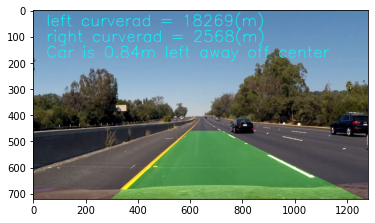

In [24]:
white_output = '../project_video_out.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
#clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,1)
clip1 = VideoFileClip("../project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)